# **Data Cleaning**

## Objectives
---

* Perform feature engineering for regression features.

## Steps
---

* Load data from the cleaned data outputs
* Analyse 

## Change working directory
---

First we set the working directory for the notebook.

In [1]:
import os
current_dir = os.getcwd()
current_dir
os.chdir(os.path.dirname(current_dir))
current_dir = os.getcwd()
print(current_dir)

/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor


## Load Data
---

Load the data in from the outputs section of the last notebook. We can drop the SalePrice column as it is the target varialbe in this study.

In [2]:
import pandas as pd
df = pd.read_csv("outputs/datasets/cleaned/clean_house_price_records.csv")
train_set = pd.read_csv("outputs/datasets/cleaned/train_set.csv")
test_set = pd.read_csv("outputs/datasets/cleaned/test_set.csv")

* The function below allows us to apply a set of defined transformers to the data.
* Requires that only either numerical or categorical data is passed, not a mixture of both.

In [3]:
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import OrdinalEncoder
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set(style="whitegrid")
import warnings
warnings.filterwarnings('ignore')



def FeatureEngineeringAnalysis(df,analysis_type=None):


  """
  - used for quick feature engineering on numerical and categorical variables
  to decide which transformation can better transform the distribution shape 
  - Once transformed, use a reporting tool, like pandas-profiling, to evaluate distributions

  """
  check_missing_values(df)
  allowed_types= ['numerical', 'ordinal_encoder',  'outlier_winsorizer']
  check_user_entry_on_analysis_type(analysis_type, allowed_types)
  list_column_transformers = define_list_column_transformers(analysis_type)
  
  
  # Loop over each variable and engineer the data according to the analysis type
  df_feat_eng = pd.DataFrame([])
  for column in df.columns:
    # create additional columns (column_method) to apply the methods
    df_feat_eng = pd.concat([df_feat_eng, df[column]], axis=1)
    for method in list_column_transformers:
      df_feat_eng[f"{column}_{method}"] = df[column]
      
    # Apply transformers in respectives column_transformers
    df_feat_eng, list_applied_transformers = apply_transformers(analysis_type, df_feat_eng, column)

    # For each variable, assess how the transformations perform
    transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng)

  return df_feat_eng


def check_user_entry_on_analysis_type(analysis_type, allowed_types):
  ### Check analyis type
  if analysis_type == None:
    raise SystemExit(f"You should pass analysis_type parameter as one of the following options: {allowed_types}")
  if analysis_type not in allowed_types:
      raise SystemExit(f"analysis_type argument should be one of these options: {allowed_types}")

def check_missing_values(df):
  if df.isna().sum().sum() != 0:
    raise SystemExit(
        f"There is missing values in your dataset. Please handle that before getting into feature engineering.")



def define_list_column_transformers(analysis_type):
  ### Set suffix colummns acording to analysis_type
  if analysis_type=='numerical':
    list_column_transformers = ["log_e","log_10","reciprocal", "power","box_cox","yeo_johnson"]
  
  elif analysis_type=='ordinal_encoder':
    list_column_transformers = ["ordinal_encoder"]

  elif analysis_type=='outlier_winsorizer':
    list_column_transformers = ['iqr']

  return list_column_transformers



def apply_transformers(analysis_type, df_feat_eng, column):


  for col in df_feat_eng.select_dtypes(include='category').columns:
    df_feat_eng[col] = df_feat_eng[col].astype('object')


  if analysis_type=='numerical':
    df_feat_eng,list_applied_transformers = FeatEngineering_Numerical(df_feat_eng,column)
  
  elif analysis_type=='outlier_winsorizer':
    df_feat_eng,list_applied_transformers = FeatEngineering_OutlierWinsorizer(df_feat_eng,column)

  elif analysis_type=='ordinal_encoder':
    df_feat_eng,list_applied_transformers = FeatEngineering_CategoricalEncoder(df_feat_eng,column)

  return df_feat_eng,list_applied_transformers



def transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng):
  # For each variable, assess how the transformations perform
  print(f"* Variable Analyzed: {column}")
  print(f"* Applied transformation: {list_applied_transformers} \n")
  for col in [column] + list_applied_transformers:
    
    if analysis_type!='ordinal_encoder':
      DiagnosticPlots_Numerical(df_feat_eng, col)
    
    else:
      if col == column: 
        DiagnosticPlots_Categories(df_feat_eng, col)
      else:
        DiagnosticPlots_Numerical(df_feat_eng, col)

    print("\n")



def DiagnosticPlots_Categories(df_feat_eng, col):
  plt.figure(figsize=(20, 5))
  sns.countplot(data=df_feat_eng, x=col,palette=['#432371'],order = df_feat_eng[col].value_counts().index)
  plt.xticks(rotation=90) 
  plt.suptitle(f"{col}", fontsize=30,y=1.05)        
  plt.show();
  print("\n")



def DiagnosticPlots_Numerical(df, variable):
  fig, axes = plt.subplots(1, 3, figsize=(20, 6))
  sns.histplot(data=df, x=variable, kde=True,element="step",ax=axes[0]) 
  stats.probplot(df[variable], dist="norm", plot=axes[1])
  sns.boxplot(x=df[variable],ax=axes[2])
  
  axes[0].set_title('Histogram')
  axes[1].set_title('QQ Plot')
  axes[2].set_title('Boxplot')
  fig.suptitle(f"{variable}", fontsize=30,y=1.05)
  plt.show();


def FeatEngineering_CategoricalEncoder(df_feat_eng,column):
  list_methods_worked = []
  try:  
    encoder= OrdinalEncoder(encoding_method='arbitrary', variables = [f"{column}_ordinal_encoder"])
    df_feat_eng = encoder.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_ordinal_encoder")
  
  except: 
    df_feat_eng.drop([f"{column}_ordinal_encoder"],axis=1,inplace=True)
    
  return df_feat_eng,list_methods_worked


def FeatEngineering_OutlierWinsorizer(df_feat_eng,column):
  list_methods_worked = []

  ### Winsorizer iqr
  try: 
    disc=Winsorizer(
        capping_method='iqr', tail='both', fold=1.5, variables = [f"{column}_iqr"])
    df_feat_eng = disc.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_iqr")
  except: 
    df_feat_eng.drop([f"{column}_iqr"],axis=1,inplace=True)


  return df_feat_eng,list_methods_worked




def FeatEngineering_Numerical(df_feat_eng,column):

  list_methods_worked = []

  ### LogTransformer base e
  try: 
    lt = vt.LogTransformer(variables = [f"{column}_log_e"])
    df_feat_eng = lt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_log_e")
  except: 
    df_feat_eng.drop([f"{column}_log_e"],axis=1,inplace=True)

    ### LogTransformer base 10
  try: 
    lt = vt.LogTransformer(variables = [f"{column}_log_10"],base='10')
    df_feat_eng = lt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_log_10")
  except: 
    df_feat_eng.drop([f"{column}_log_10"],axis=1,inplace=True)

  ### ReciprocalTransformer
  try:
    rt = vt.ReciprocalTransformer(variables = [f"{column}_reciprocal"])
    df_feat_eng =  rt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_reciprocal")
  except:
    df_feat_eng.drop([f"{column}_reciprocal"],axis=1,inplace=True)

  ### PowerTransformer
  try:
    pt = vt.PowerTransformer(variables = [f"{column}_power"])
    df_feat_eng = pt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_power")
  except:
    df_feat_eng.drop([f"{column}_power"],axis=1,inplace=True)

  ### BoxCoxTransformer
  try:
    bct = vt.BoxCoxTransformer(variables = [f"{column}_box_cox"])
    df_feat_eng = bct.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_box_cox")
  except:
    df_feat_eng.drop([f"{column}_box_cox"],axis=1,inplace=True)


  ### YeoJohnsonTransformer
  try:
    yjt = vt.YeoJohnsonTransformer(variables = [f"{column}_yeo_johnson"])
    df_feat_eng = yjt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_yeo_johnson")
  except:
        df_feat_eng.drop([f"{column}_yeo_johnson"],axis=1,inplace=True)


  return df_feat_eng,list_methods_worked

This function is taken from the codeinstitute modules for feature engineering. It creates a heatmap for correlation scores and PPS.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps


def heatmap_corr(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
        mask[abs(df) < threshold] = True

        fig, axes = plt.subplots(figsize=figsize)
        sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                    mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
                    linewidth=0.5
                    )
        axes.set_yticklabels(df.columns, rotation=0)
        plt.ylim(len(df.columns), 0)
        plt.show()


def heatmap_pps(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=np.bool)
        mask[abs(df) < threshold] = True
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                         mask=mask, cmap='rocket_r', annot_kws={"size": font_annot},
                         linewidth=0.05, linecolor='grey')
        plt.ylim(len(df.columns), 0)
        plt.show()


def CalculateCorrAndPPS(df):
    df_corr_spearman = df.corr(method="spearman")
    df_corr_pearson = df.corr(method="pearson")

    pps_matrix_raw = pps.matrix(df)
    pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

    pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
    print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
    print(pps_score_stats.round(3))

    return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix, CorrThreshold, PPS_Threshold,
                      figsize=(20, 12), font_annot=8):

    print("\n")
    print("* Analyse how the target variable for your ML models are correlated with other variables (features and target)")
    print("* Analyse multi-colinearity, that is, how the features are correlated among themselves")

    print("\n")
    print("*** Heatmap: Spearman Correlation ***")
    print("It evaluates monotonic relationship \n")
    heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Pearson Correlation ***")
    print("It evaluates the linear relationship between two continuous variables \n")
    heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Power Predictive Score (PPS) ***")
    print(f"PPS detects linear or non-linear relationships between two columns.\n"
          f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
    heatmap_pps(df=pps_matrix, threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)

In [5]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1168 entries, 0 to 1167
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   1stFlrSF      1168 non-null   int64  
 1   2ndFlrSF      1168 non-null   int64  
 2   BedroomAbvGr  1168 non-null   int64  
 3   BsmtExposure  1168 non-null   object 
 4   BsmtFinSF1    1168 non-null   int64  
 5   BsmtFinType1  1168 non-null   object 
 6   BsmtUnfSF     1168 non-null   int64  
 7   GarageArea    1168 non-null   int64  
 8   GarageFinish  1168 non-null   object 
 9   GarageYrBlt   1168 non-null   float64
 10  GrLivArea     1168 non-null   int64  
 11  KitchenQual   1168 non-null   object 
 12  LotArea       1168 non-null   int64  
 13  LotFrontage   1168 non-null   int64  
 14  MasVnrArea    1168 non-null   int64  
 15  OpenPorchSF   1168 non-null   int64  
 16  OverallCond   1168 non-null   int64  
 17  OverallQual   1168 non-null   int64  
 18  TotalBsmtSF   1168 non-null 

* Some of the data is type int, but is actually categorical.
* We can change it to type object using the astype() function.

In [6]:
categorical_variables = ['GarageFinish', 'BsmtFinType1', 'GarageYrBlt', 'BsmtExposure', 'OverallCond', 'OverallQual', 'KitchenQual']
df[categorical_variables]=df[categorical_variables].astype('object')
df_feat_eng = train_set.copy()
df_feat_eng[categorical_variables]=df_feat_eng[categorical_variables].astype('object')
df_numerical = df_feat_eng.select_dtypes(include=['int64','float64'])
df_categorical = df_feat_eng.select_dtypes(include=['object'])
# train_set[categorical_variables]=train_set[categorical_variables].astype('object')
# test_set[categorical_variables]=test_set[categorical_variables].astype('object')

We check the new data types.

In [7]:
df_numerical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1168 entries, 0 to 1167
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   1stFlrSF      1168 non-null   int64
 1   2ndFlrSF      1168 non-null   int64
 2   BedroomAbvGr  1168 non-null   int64
 3   BsmtFinSF1    1168 non-null   int64
 4   BsmtUnfSF     1168 non-null   int64
 5   GarageArea    1168 non-null   int64
 6   GrLivArea     1168 non-null   int64
 7   LotArea       1168 non-null   int64
 8   LotFrontage   1168 non-null   int64
 9   MasVnrArea    1168 non-null   int64
 10  OpenPorchSF   1168 non-null   int64
 11  TotalBsmtSF   1168 non-null   int64
 12  YearBuilt     1168 non-null   int64
 13  YearRemodAdd  1168 non-null   int64
 14  SalePrice     1168 non-null   int64
dtypes: int64(15)
memory usage: 137.0 KB


In [8]:
df_categorical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1168 entries, 0 to 1167
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   BsmtExposure  1168 non-null   object
 1   BsmtFinType1  1168 non-null   object
 2   GarageFinish  1168 non-null   object
 3   GarageYrBlt   1168 non-null   object
 4   KitchenQual   1168 non-null   object
 5   OverallCond   1168 non-null   object
 6   OverallQual   1168 non-null   object
dtypes: object(7)
memory usage: 64.0+ KB


## Numerical Analysis
---

We can run a numerical analysis on the varialbes in the dataset to see if we can normalise their distribution by using a series of numerical transformers and analysing the resulting data distributions.

* Variable Analyzed: 1stFlrSF
* Applied transformation: ['1stFlrSF_log_e', '1stFlrSF_log_10', '1stFlrSF_reciprocal', '1stFlrSF_power', '1stFlrSF_box_cox', '1stFlrSF_yeo_johnson'] 



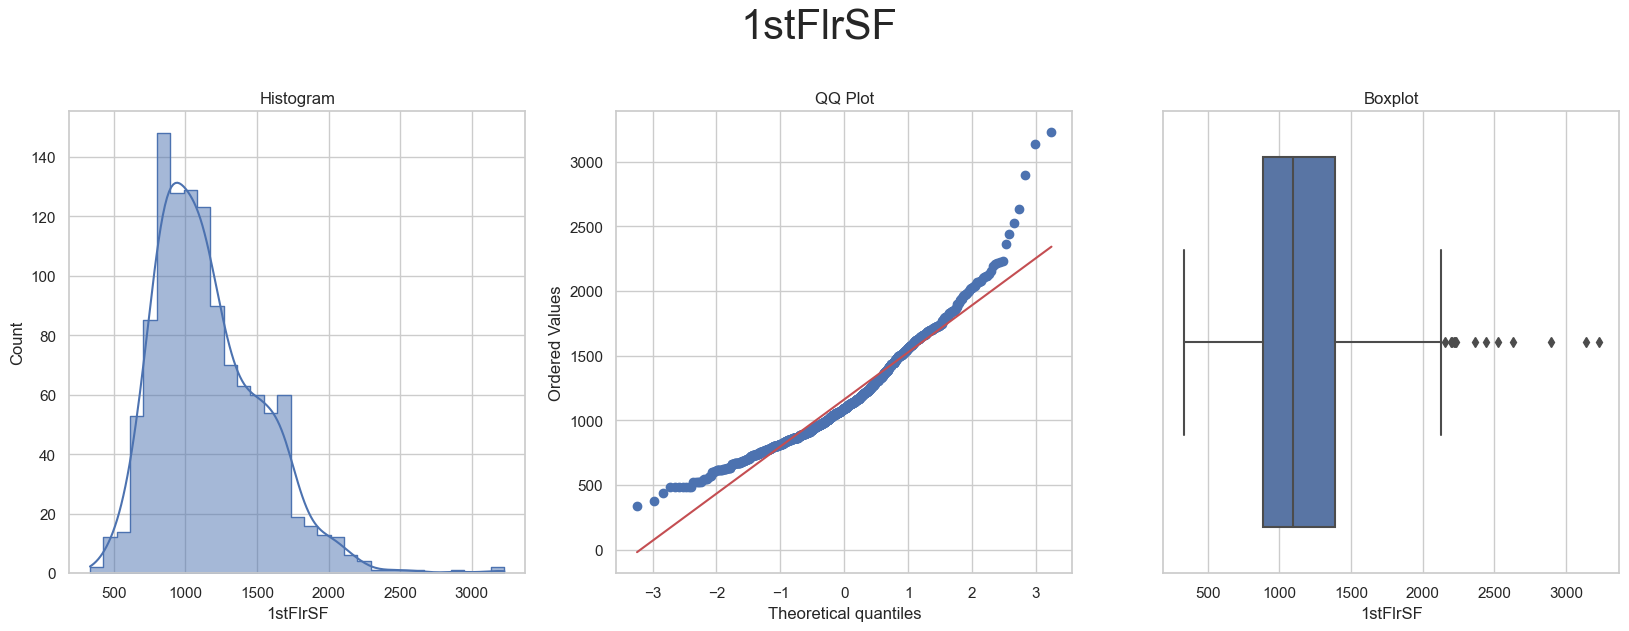

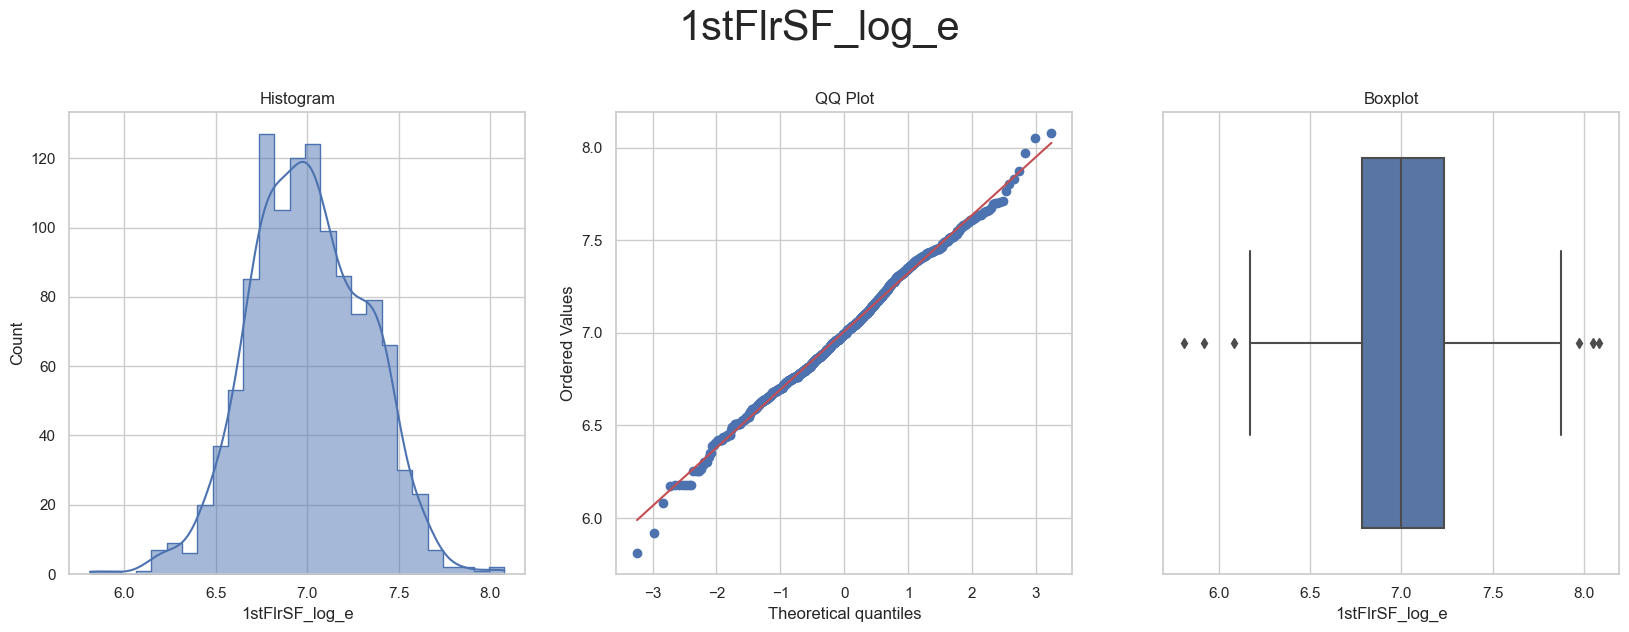

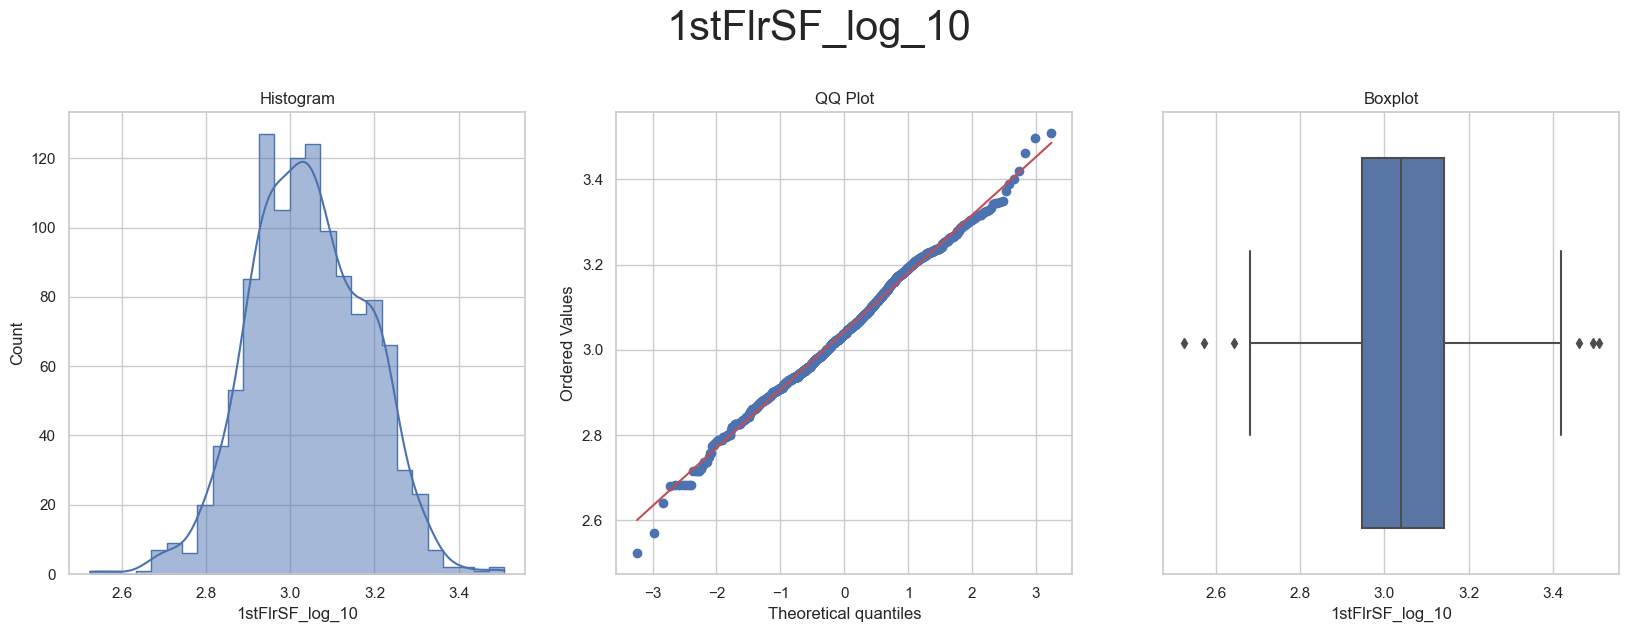

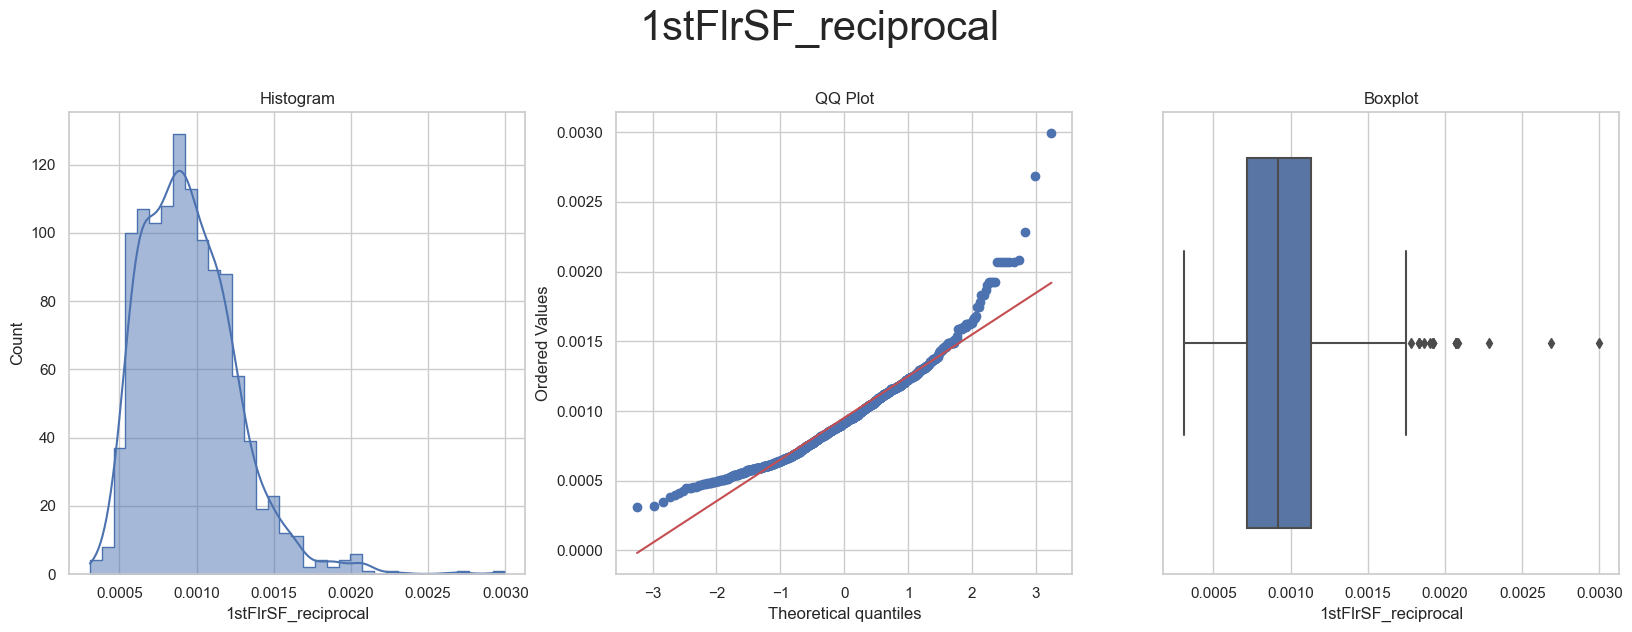

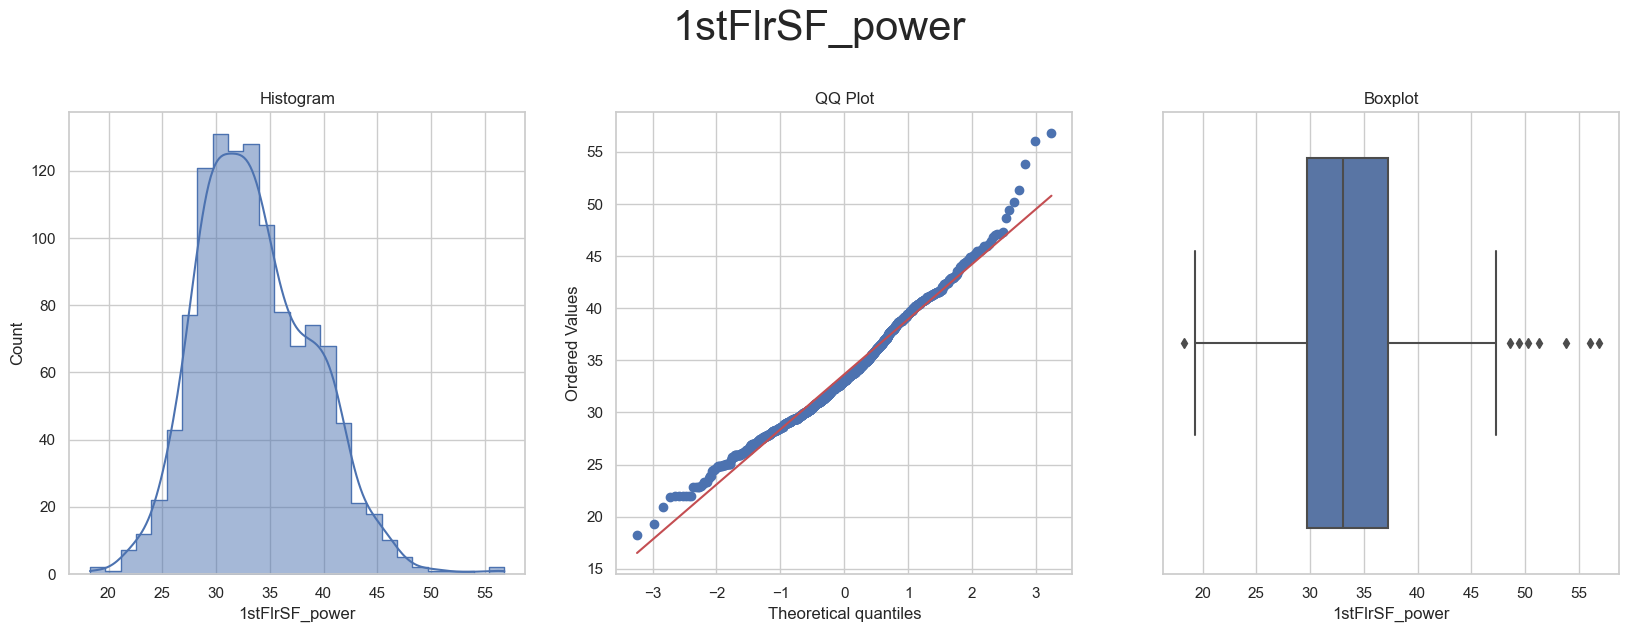

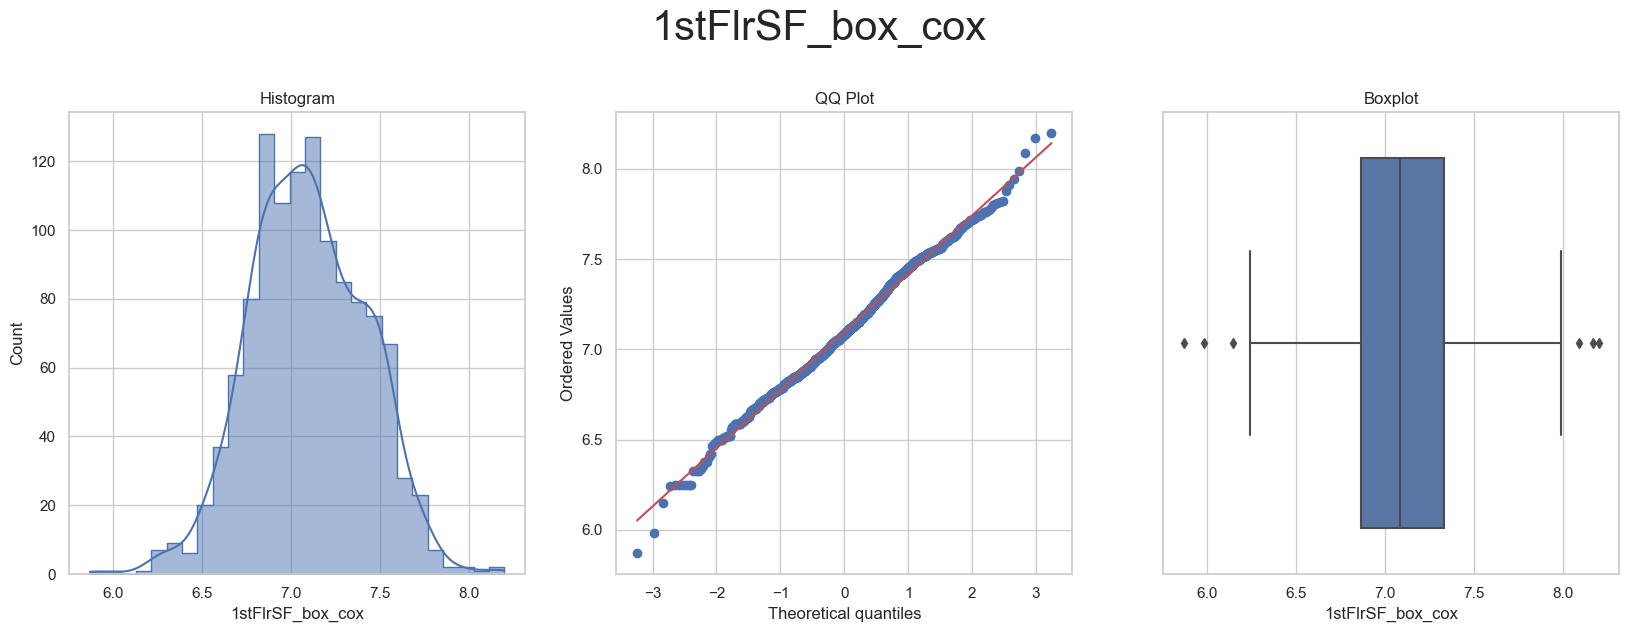

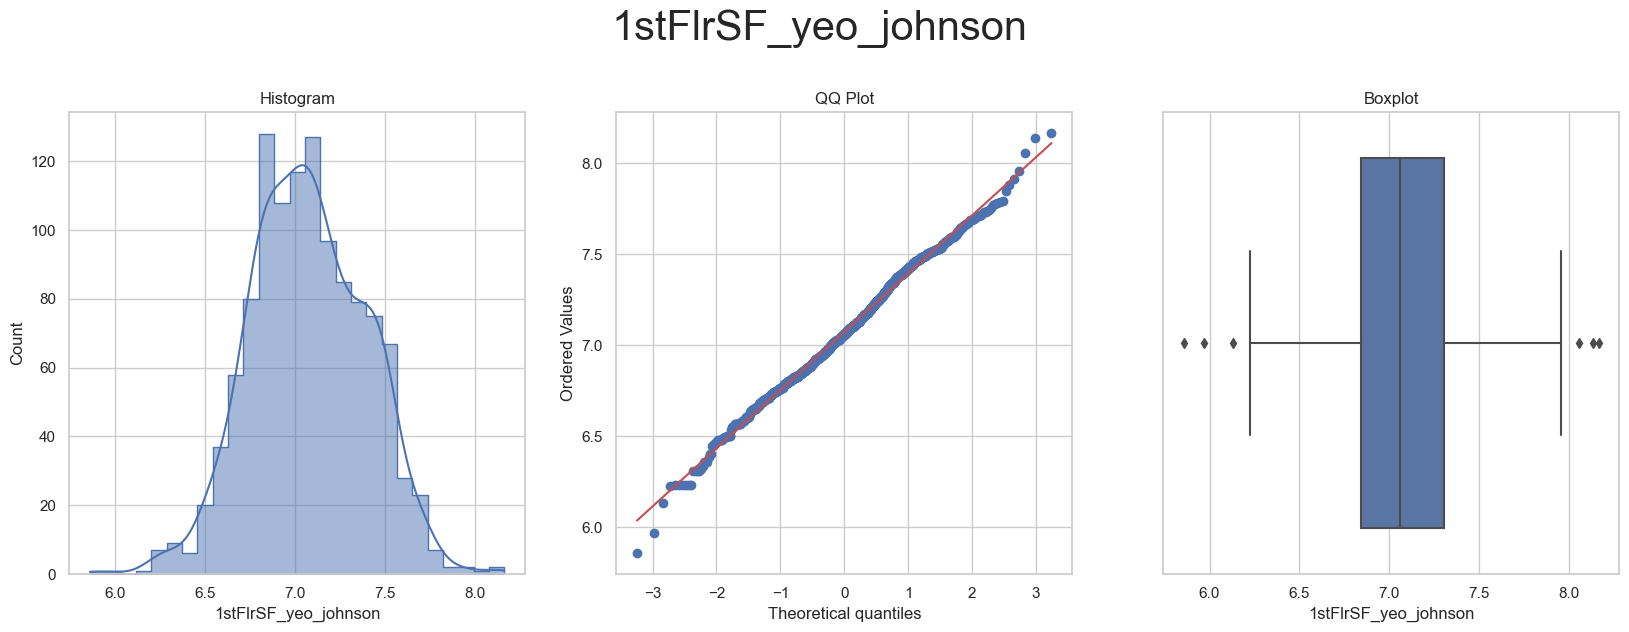



* Variable Analyzed: 2ndFlrSF
* Applied transformation: ['2ndFlrSF_power', '2ndFlrSF_yeo_johnson'] 



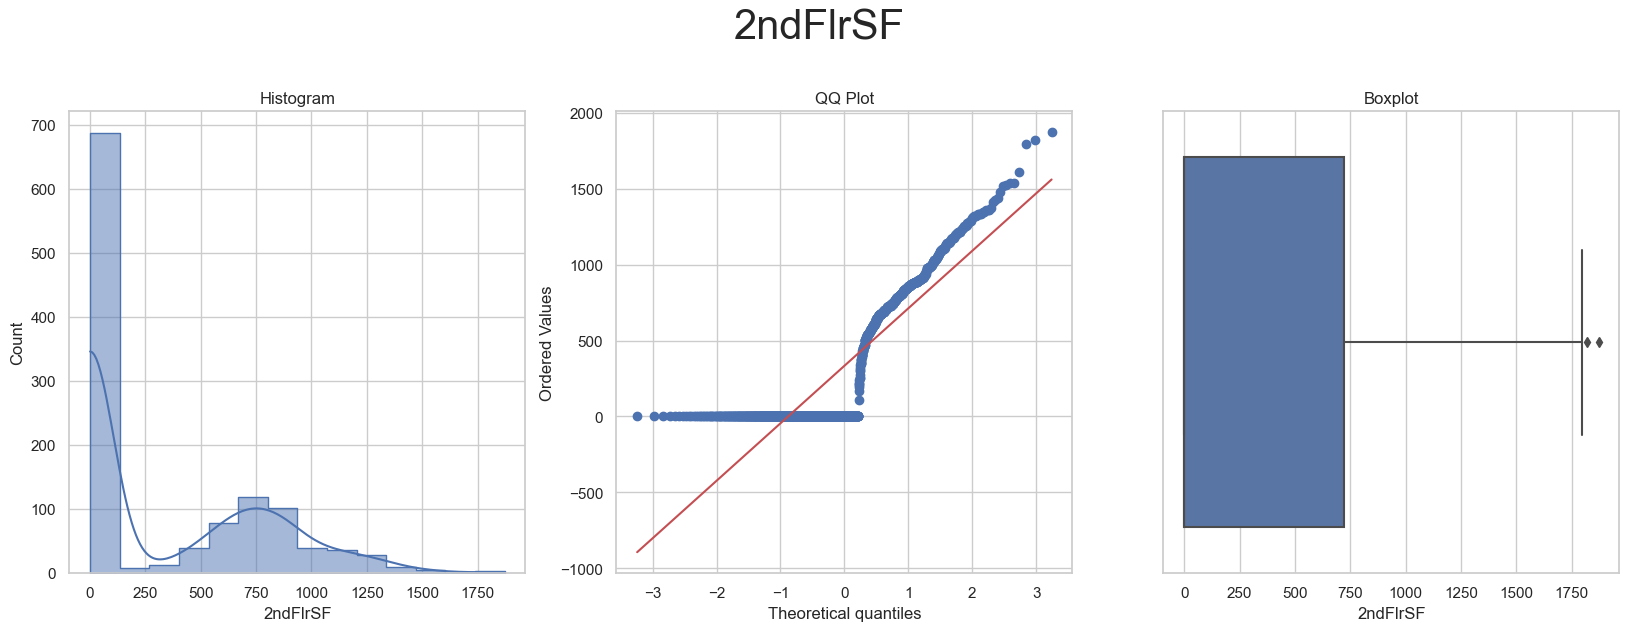

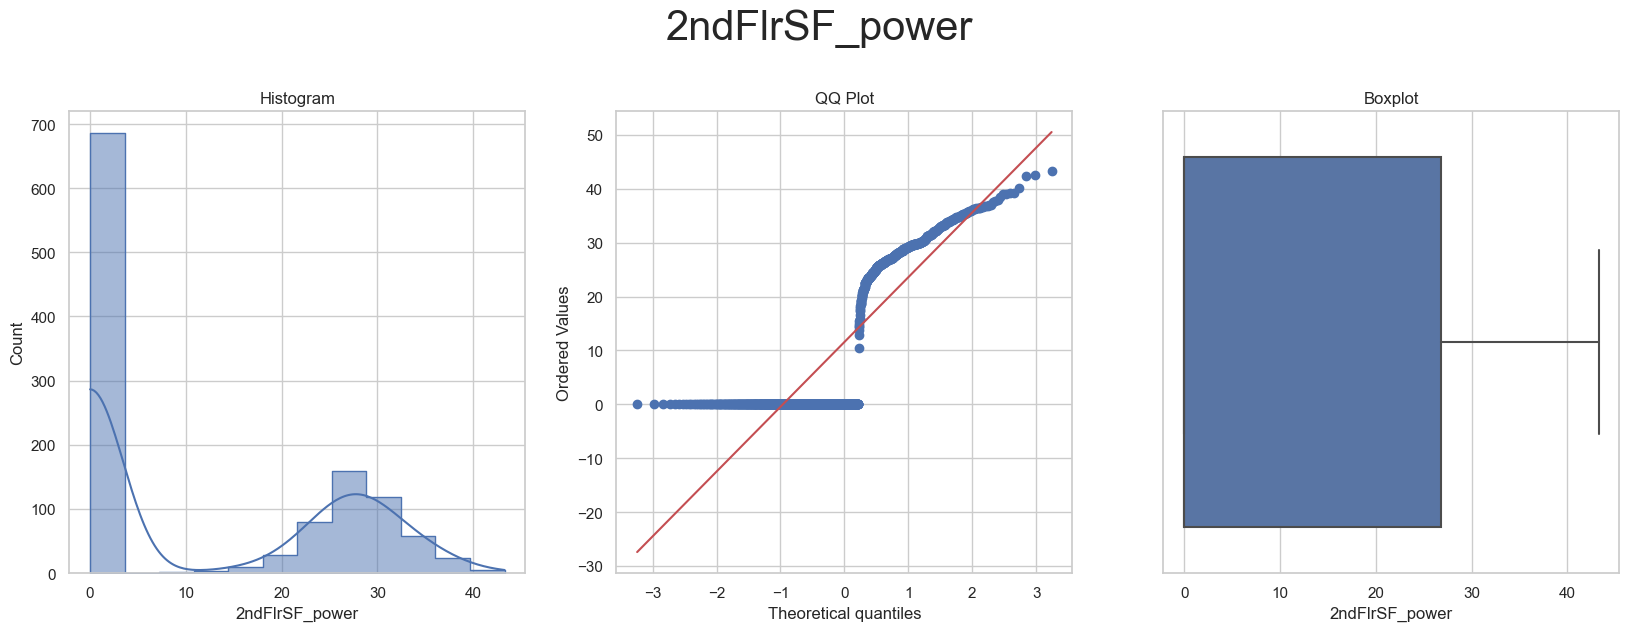

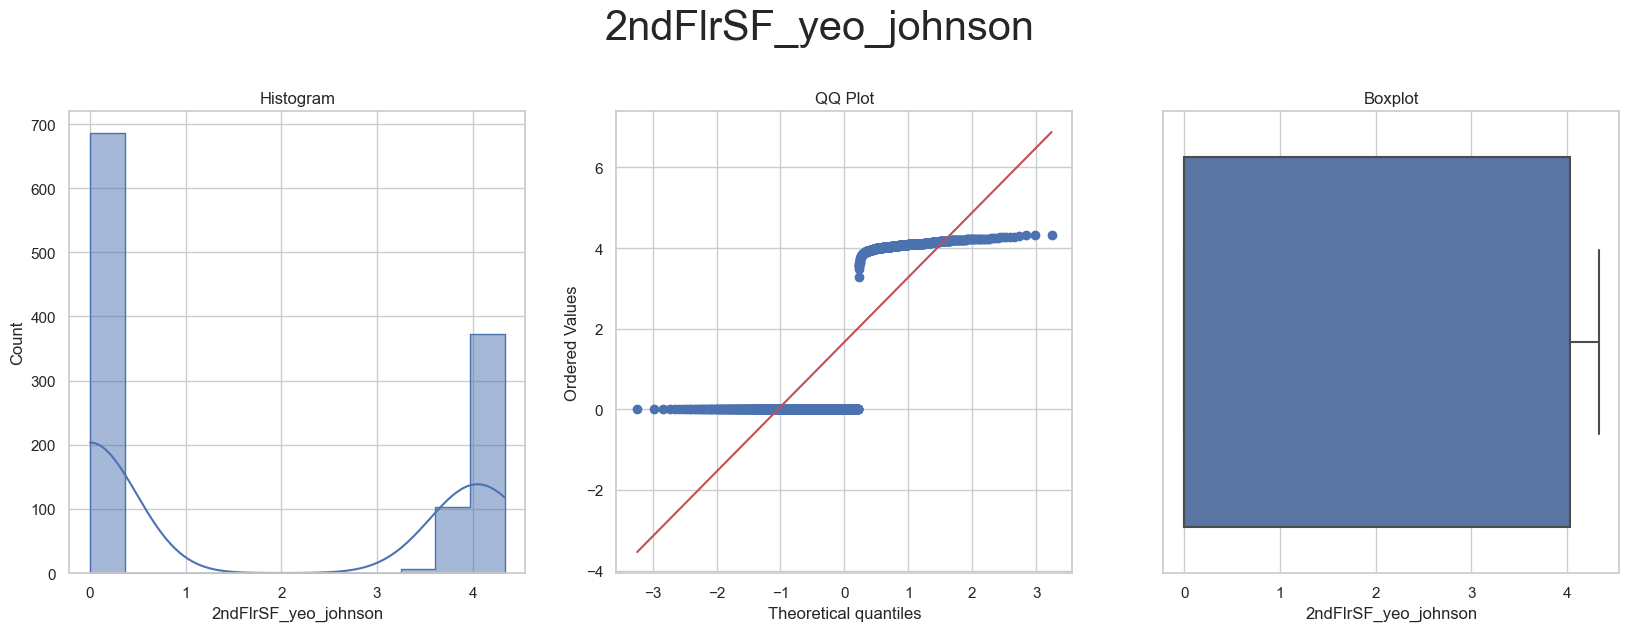



* Variable Analyzed: BedroomAbvGr
* Applied transformation: ['BedroomAbvGr_power', 'BedroomAbvGr_yeo_johnson'] 



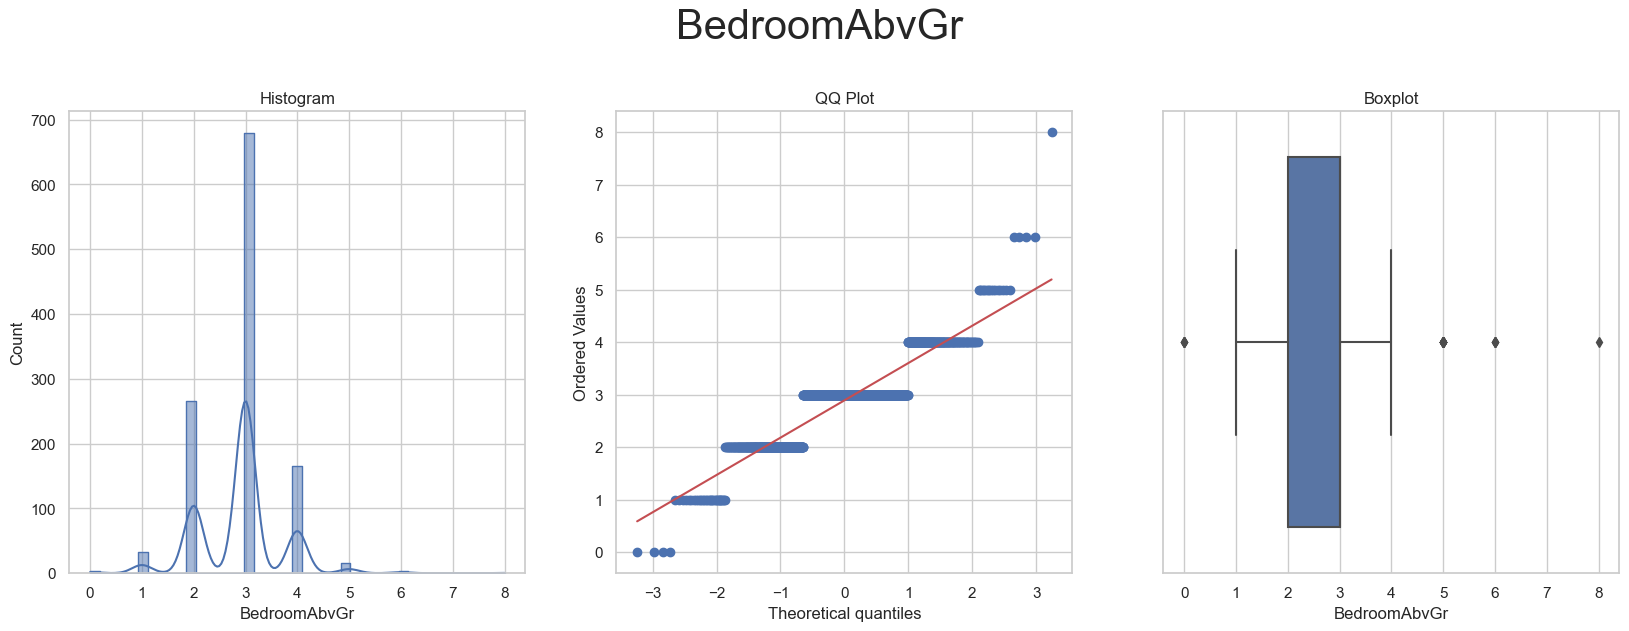

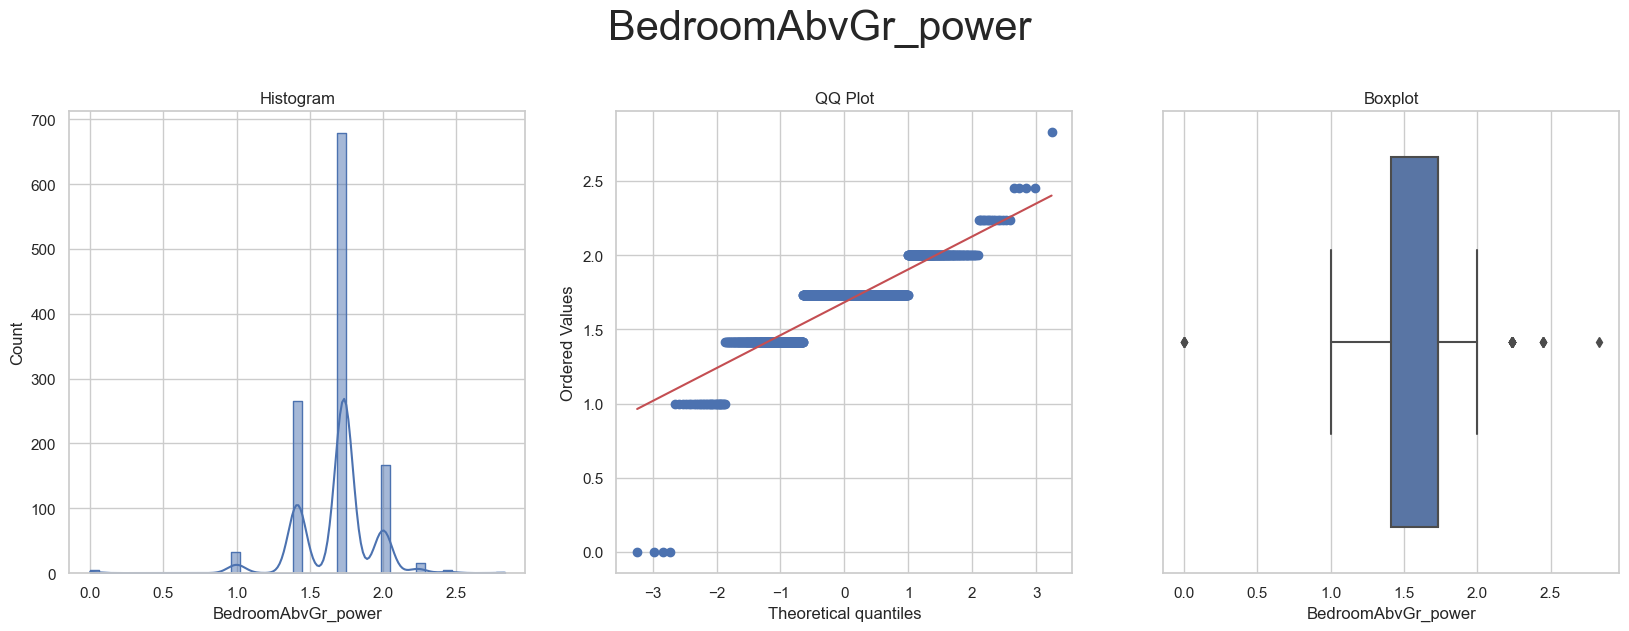

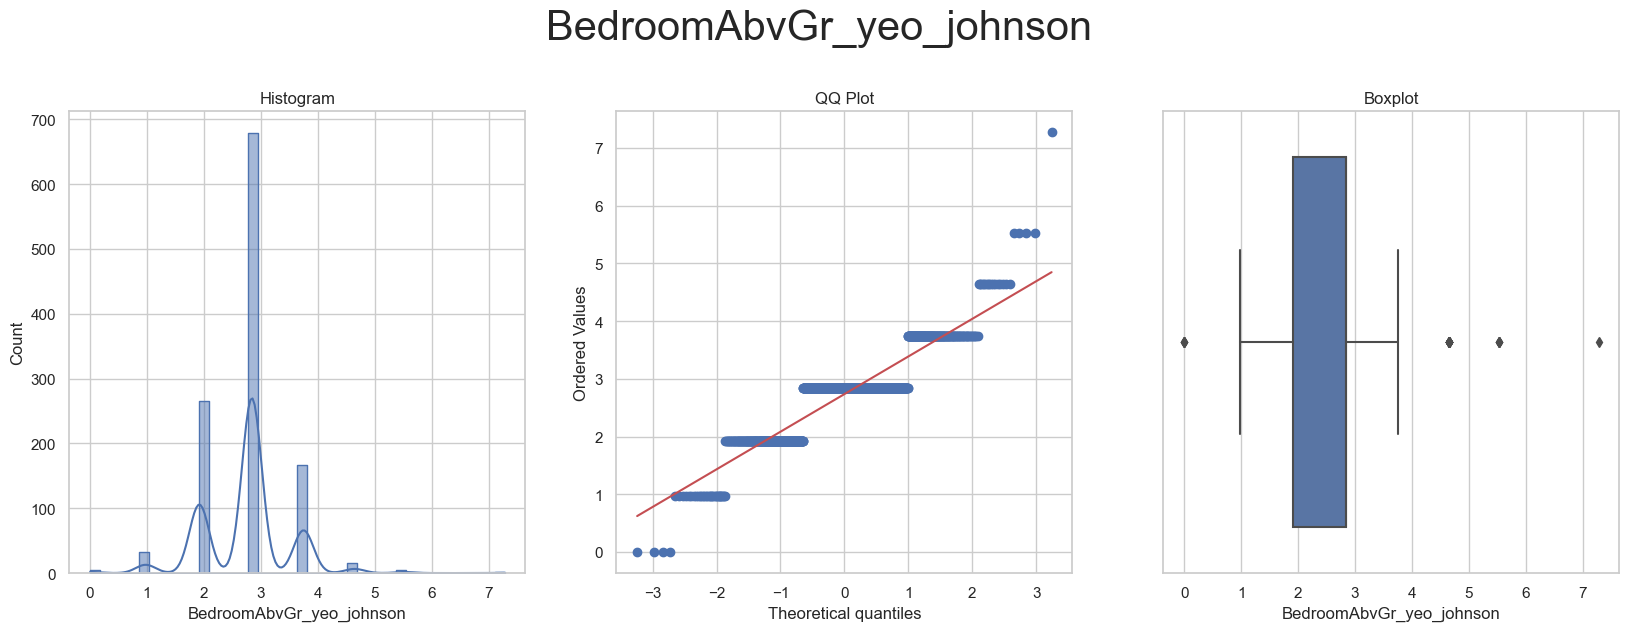



* Variable Analyzed: BsmtFinSF1
* Applied transformation: ['BsmtFinSF1_power', 'BsmtFinSF1_yeo_johnson'] 



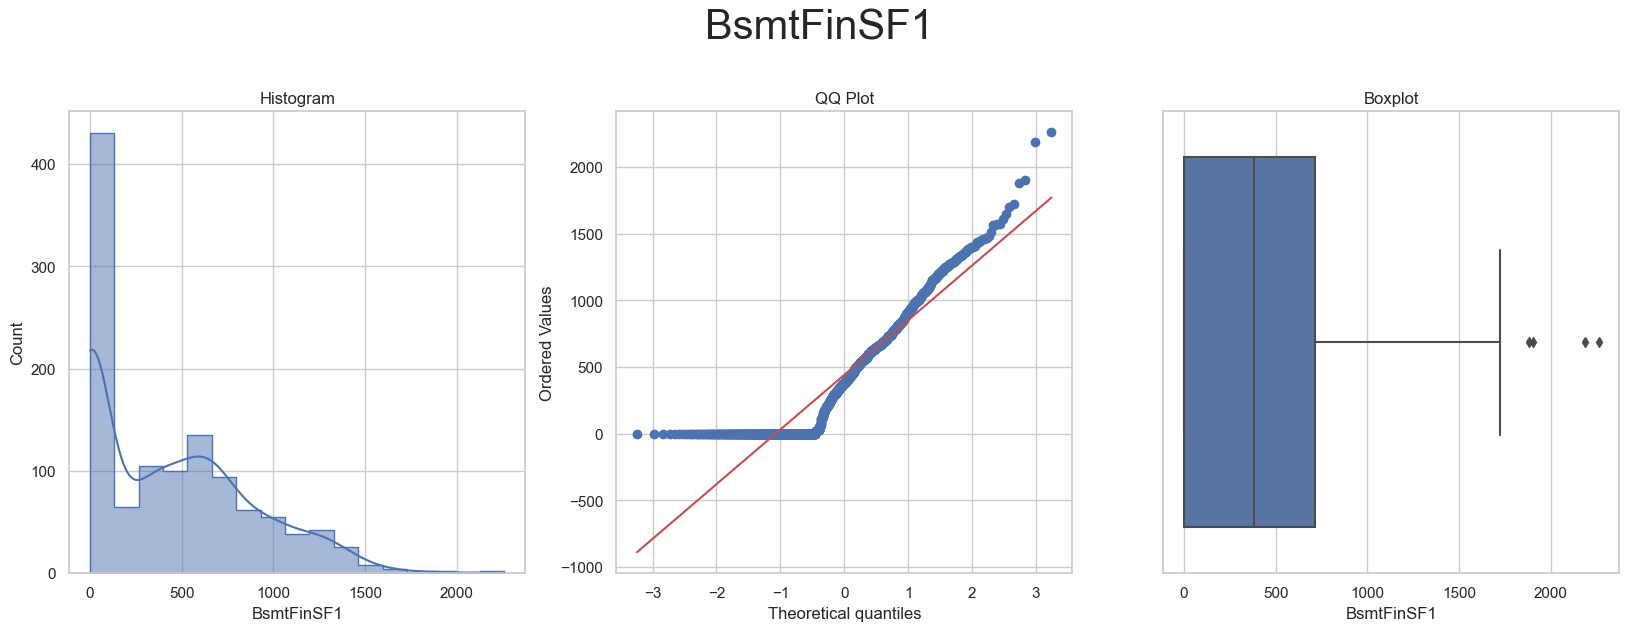

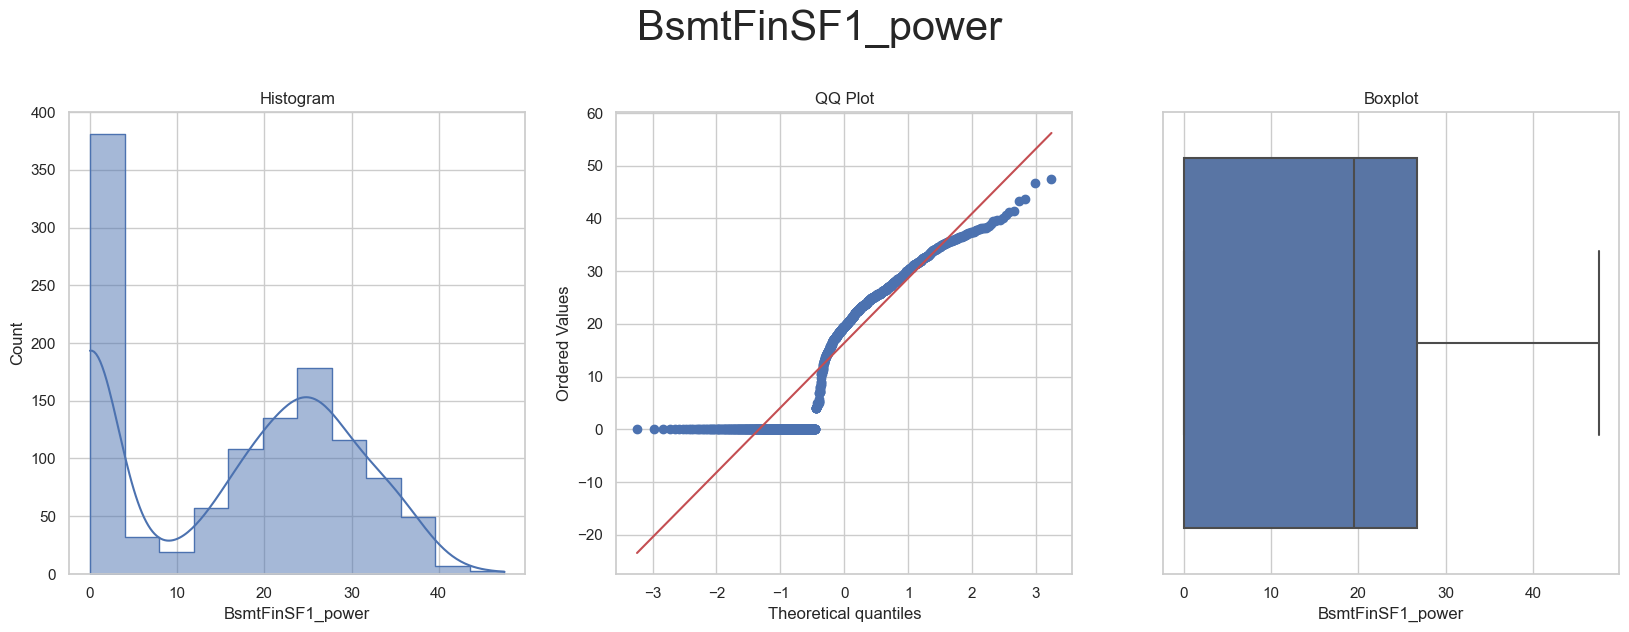

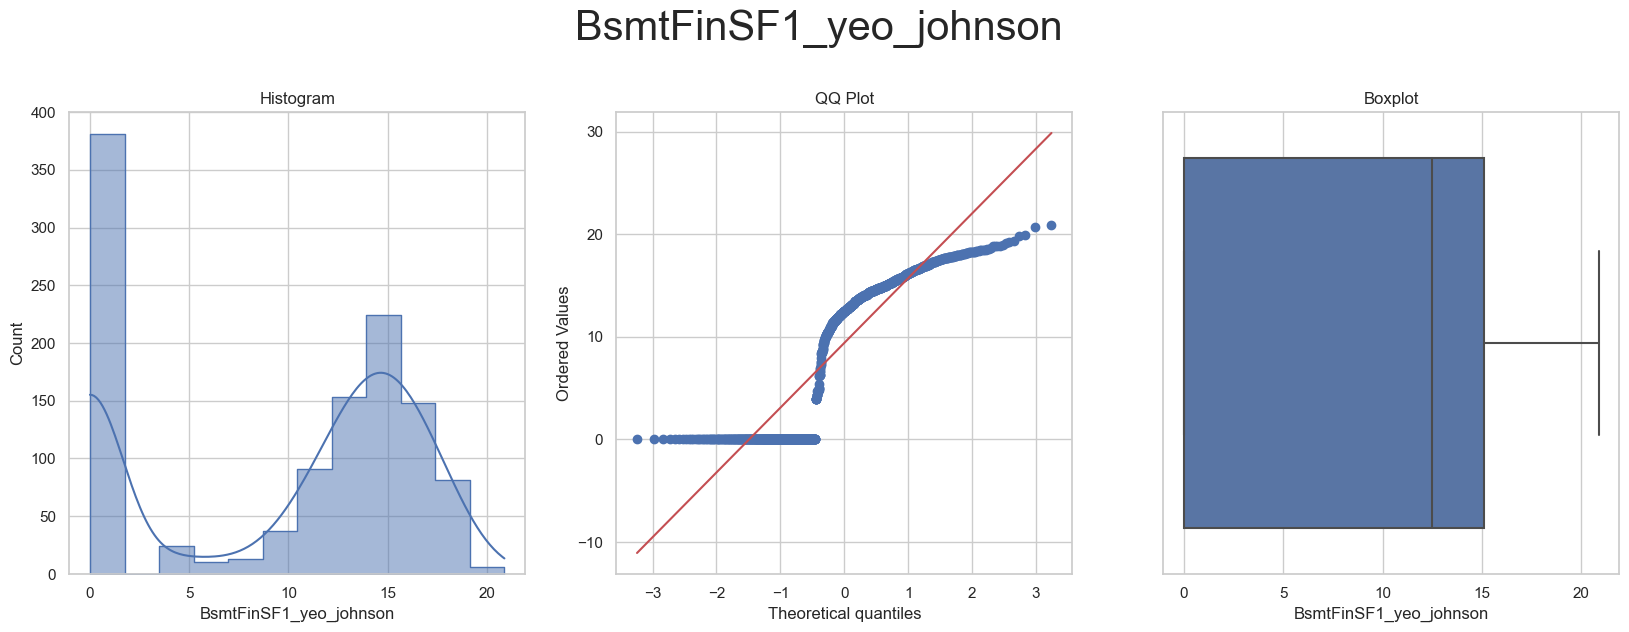



* Variable Analyzed: BsmtUnfSF
* Applied transformation: ['BsmtUnfSF_power', 'BsmtUnfSF_yeo_johnson'] 



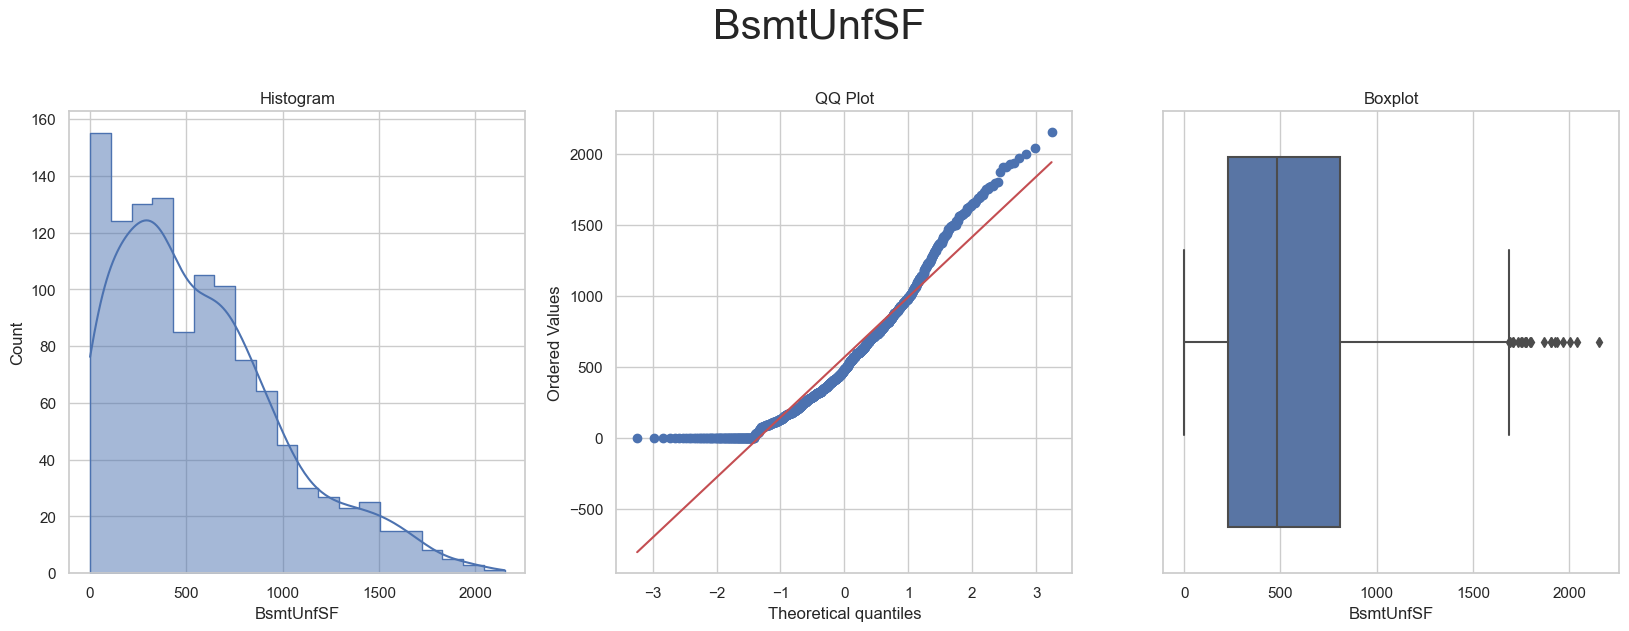

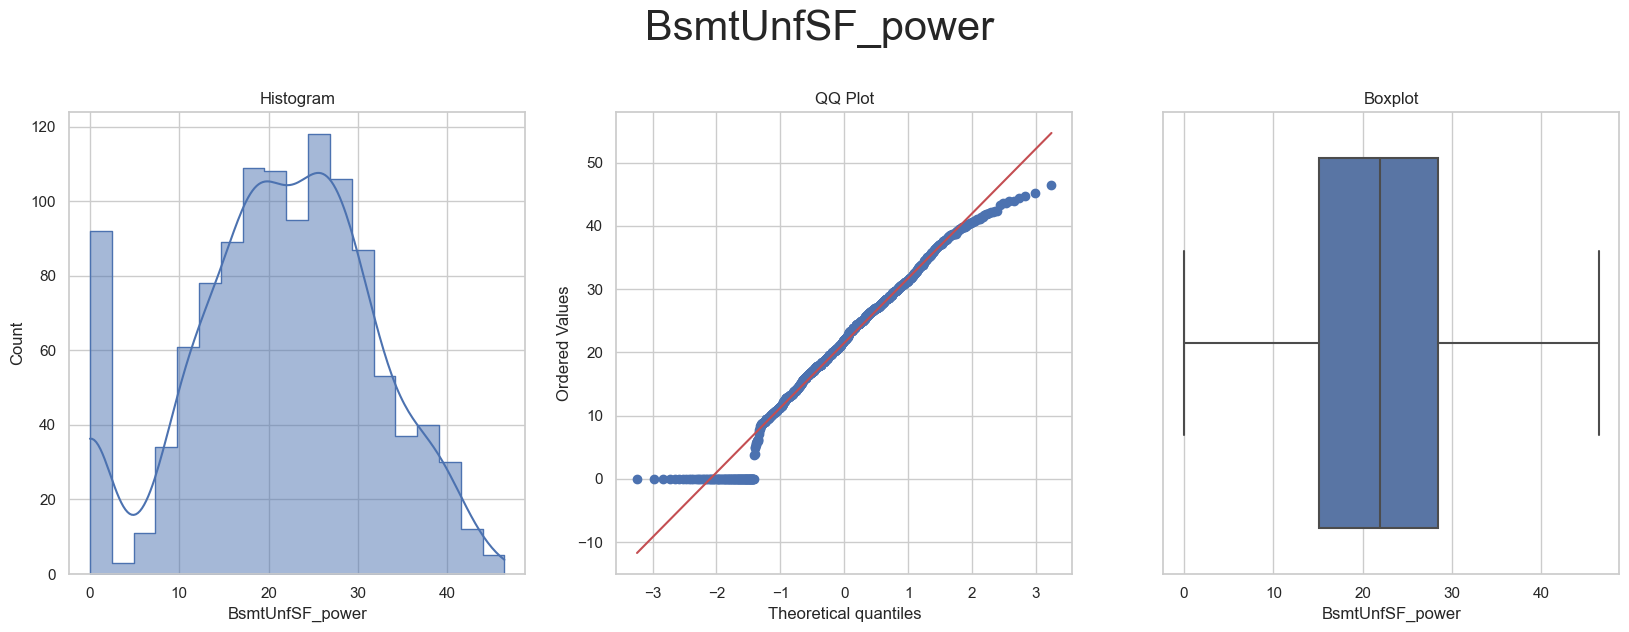

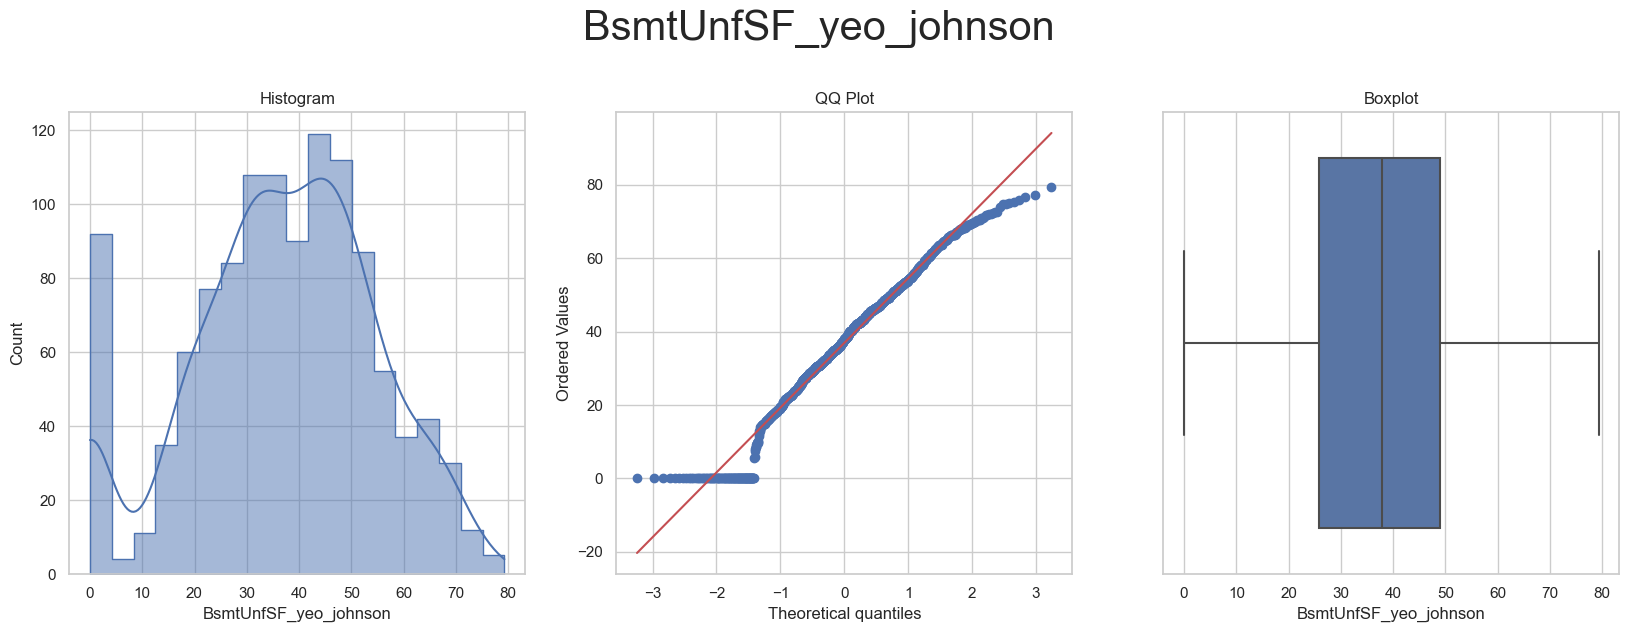



* Variable Analyzed: GarageArea
* Applied transformation: ['GarageArea_power', 'GarageArea_yeo_johnson'] 



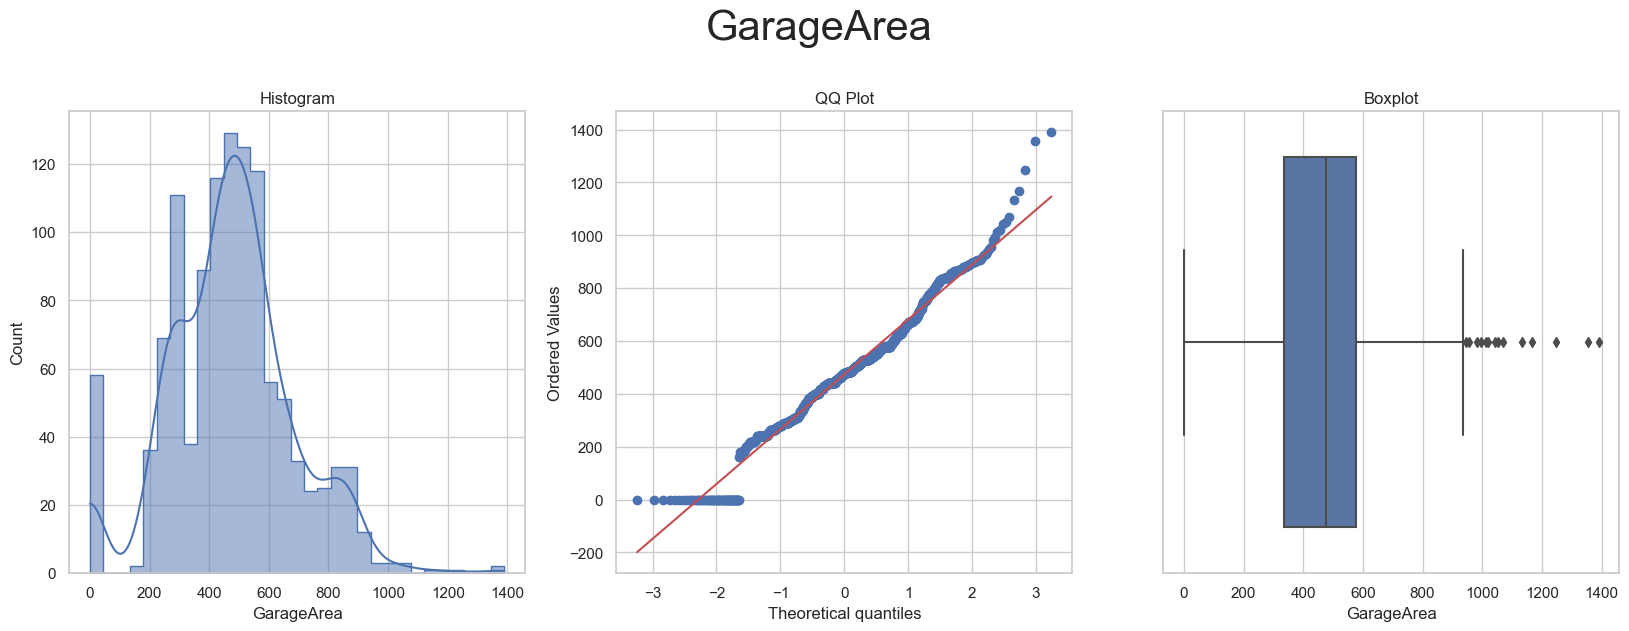

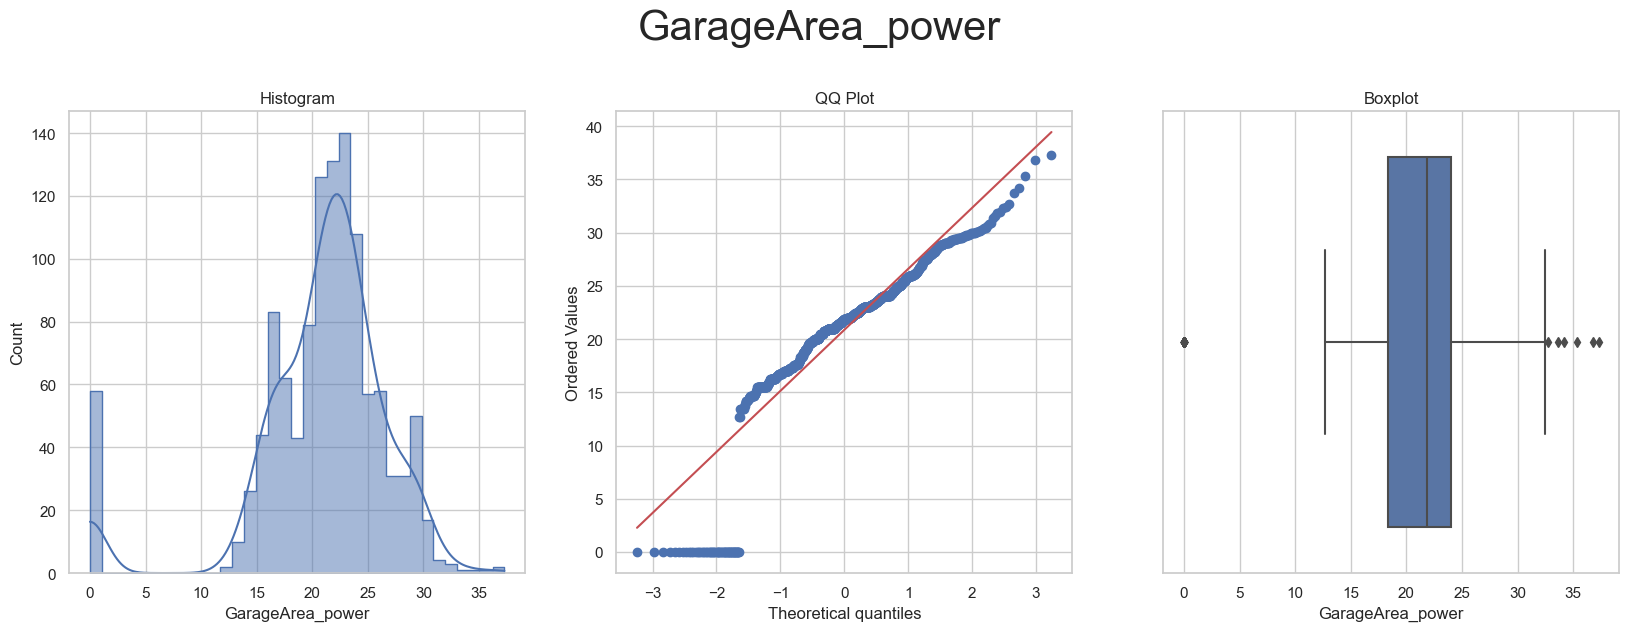

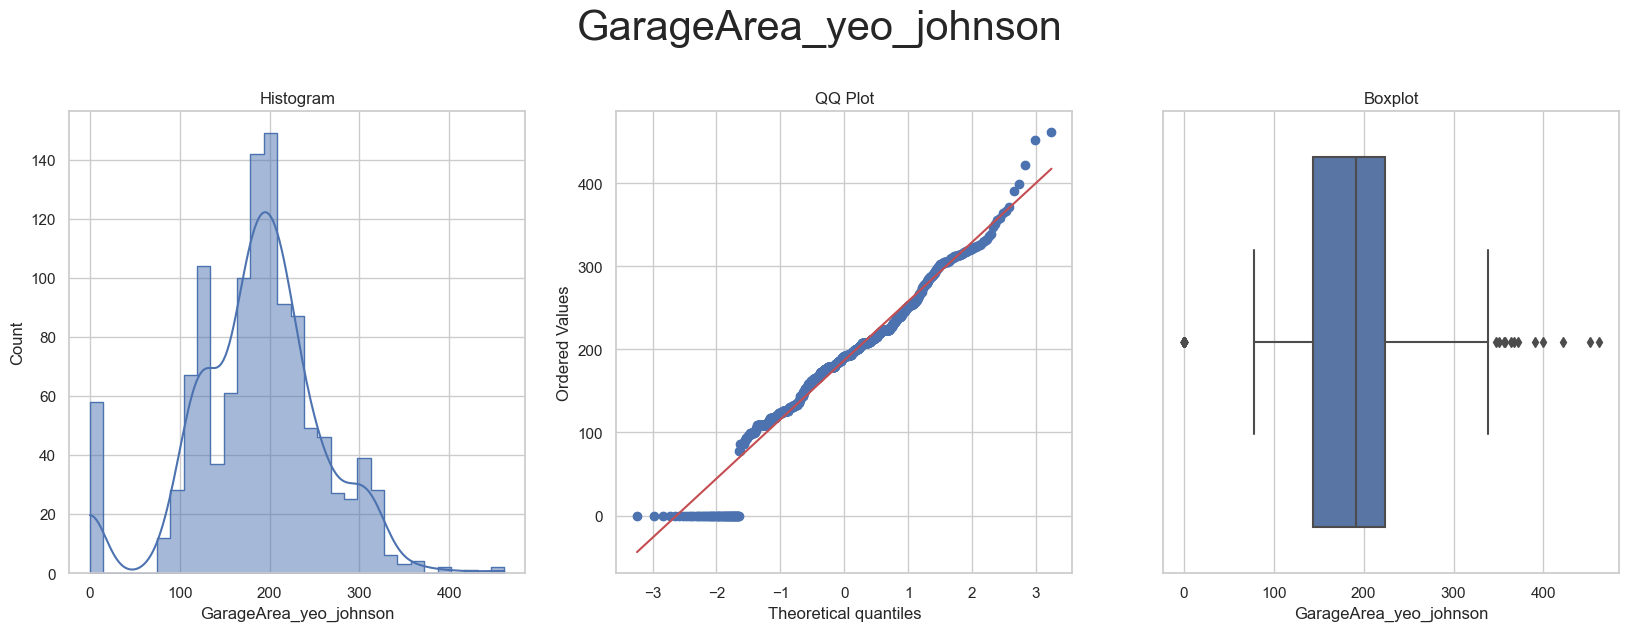



* Variable Analyzed: GrLivArea
* Applied transformation: ['GrLivArea_log_e', 'GrLivArea_log_10', 'GrLivArea_reciprocal', 'GrLivArea_power', 'GrLivArea_box_cox', 'GrLivArea_yeo_johnson'] 



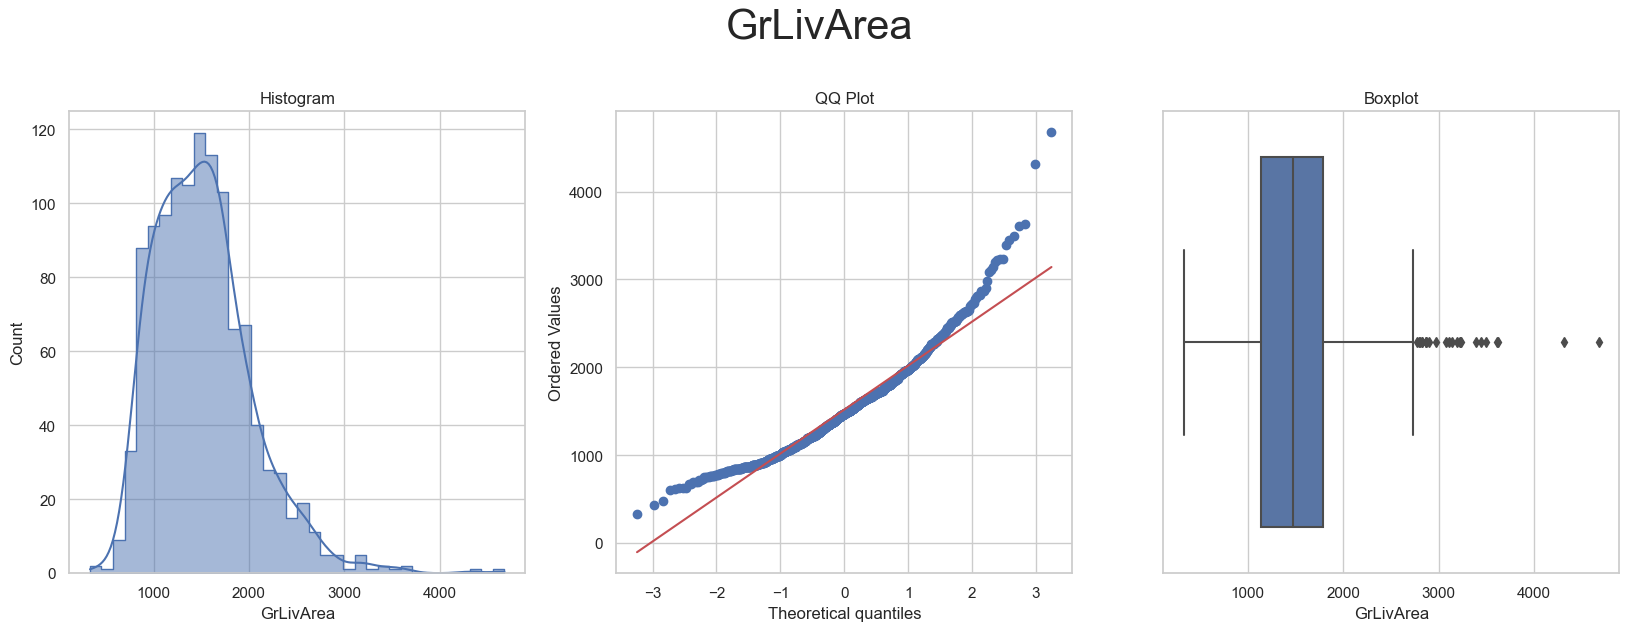

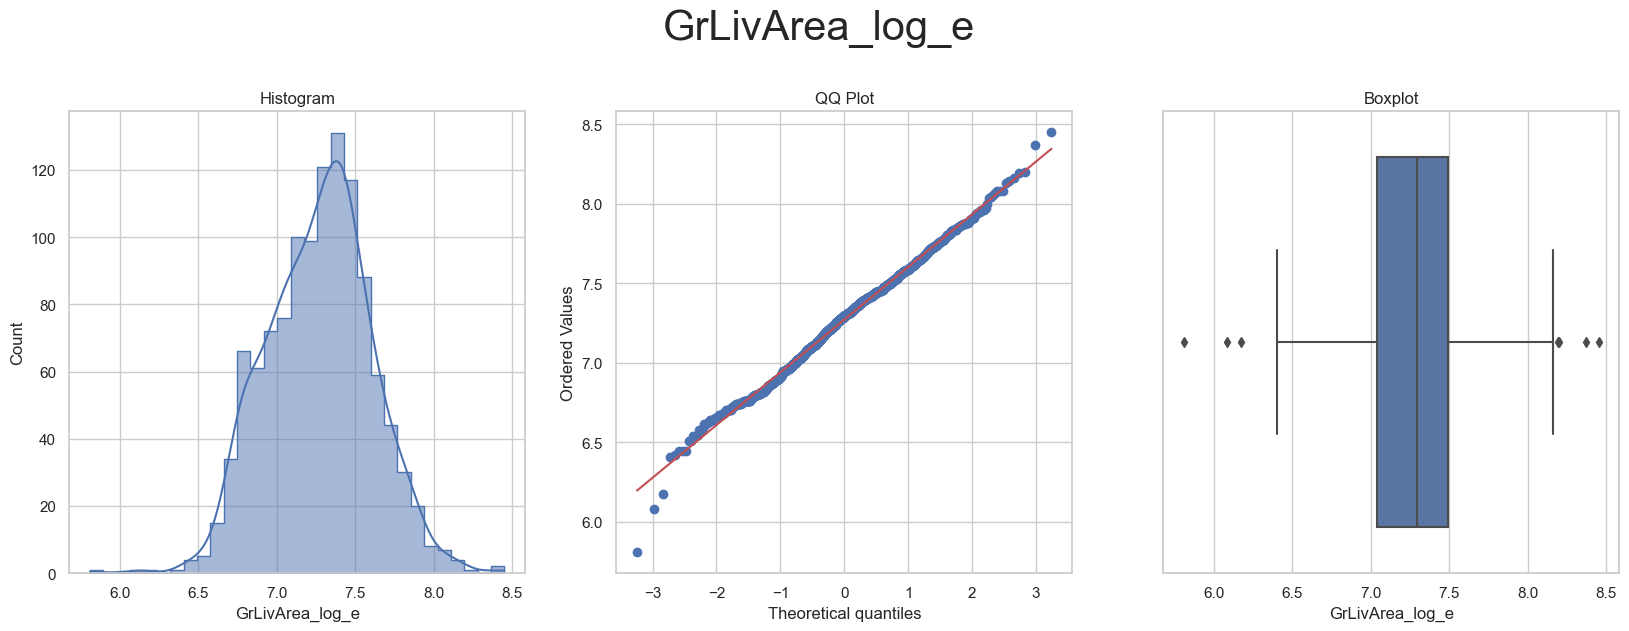

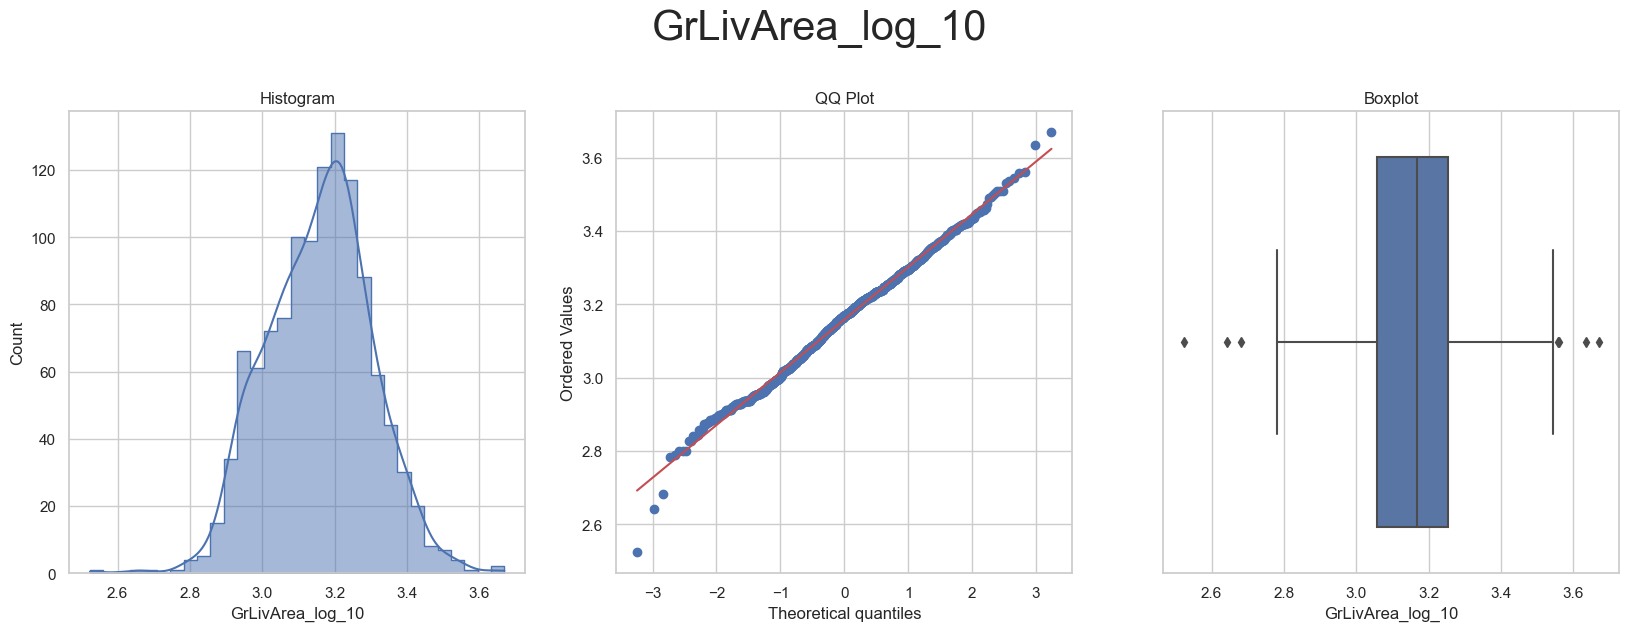

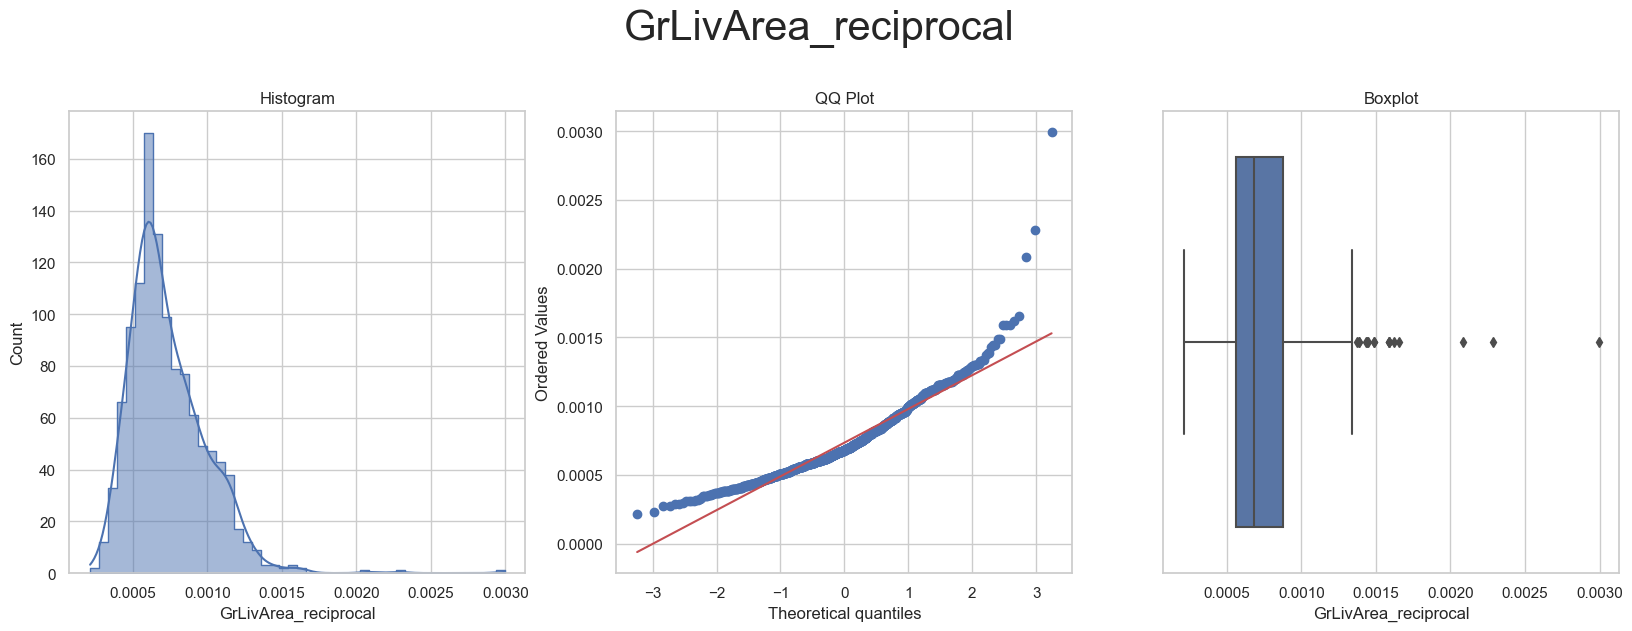

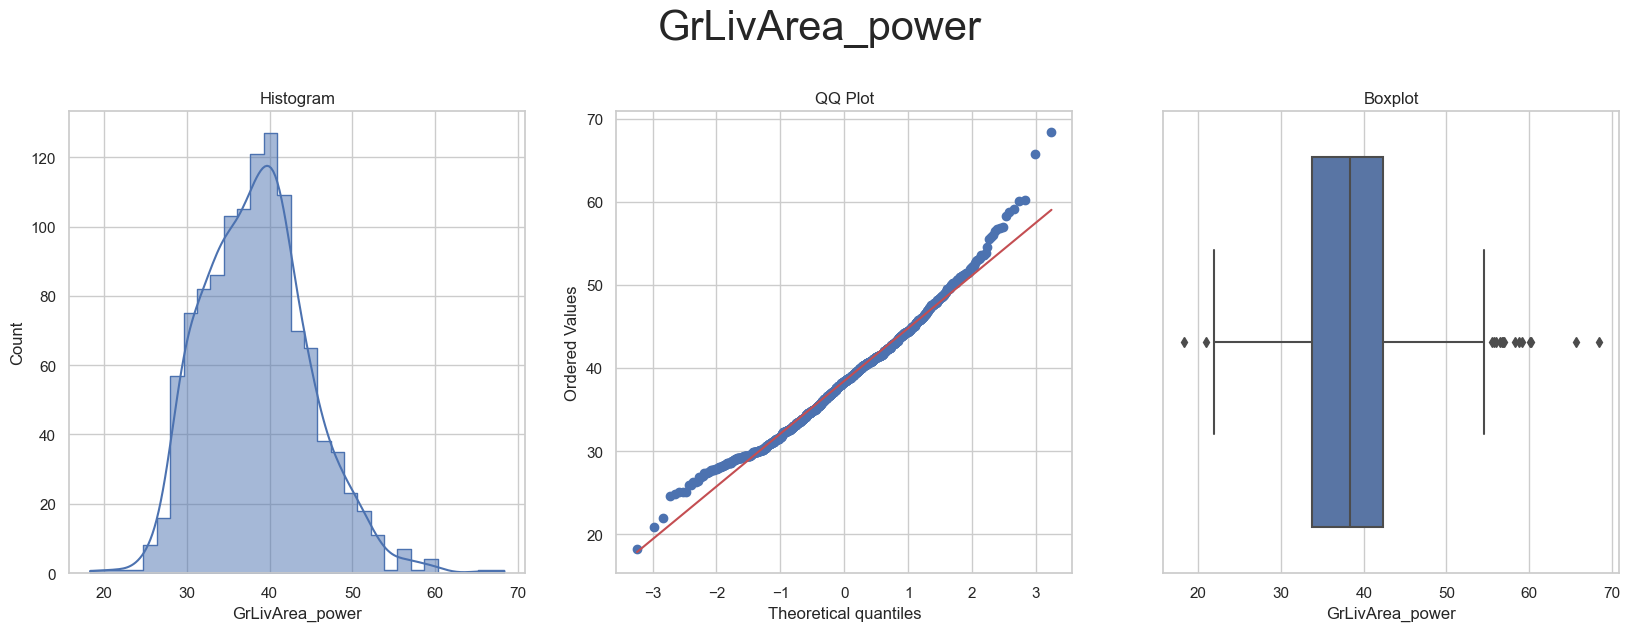

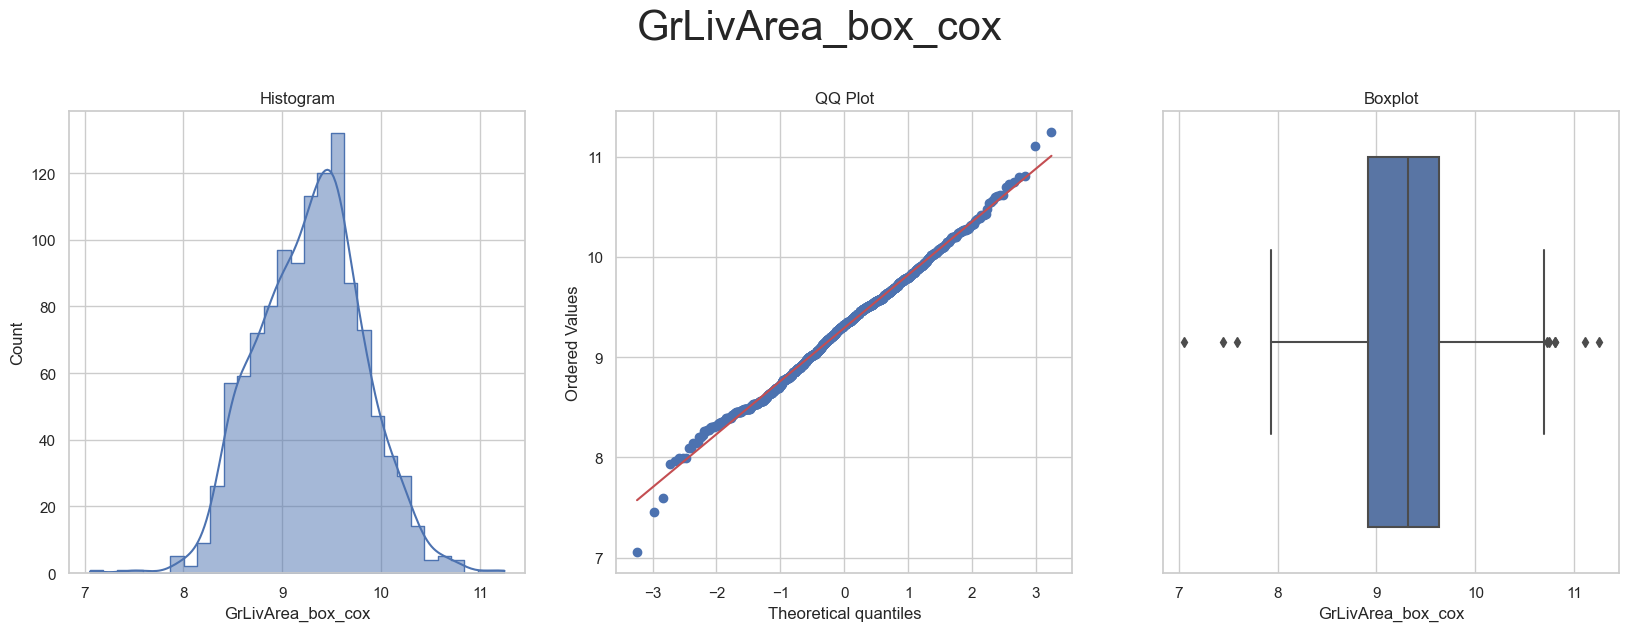

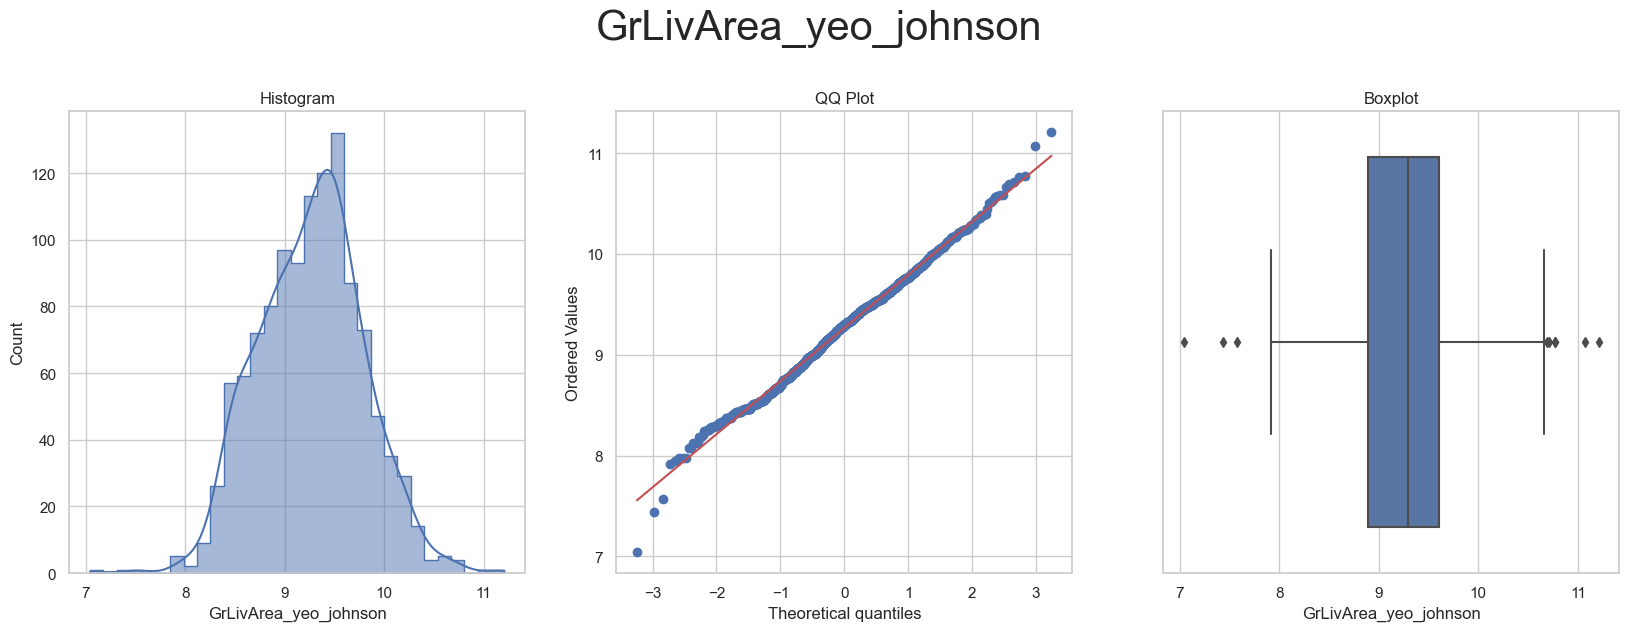



* Variable Analyzed: LotArea
* Applied transformation: ['LotArea_log_e', 'LotArea_log_10', 'LotArea_reciprocal', 'LotArea_power', 'LotArea_box_cox', 'LotArea_yeo_johnson'] 



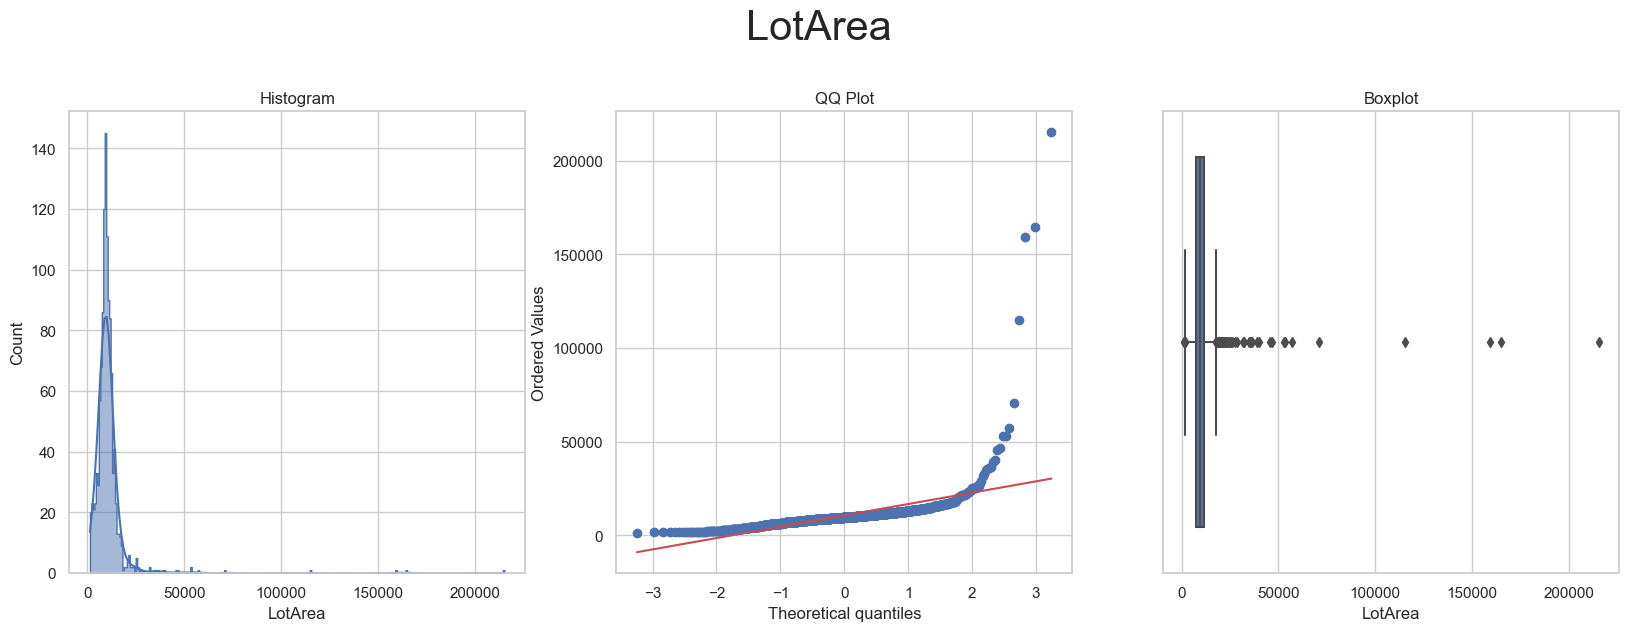

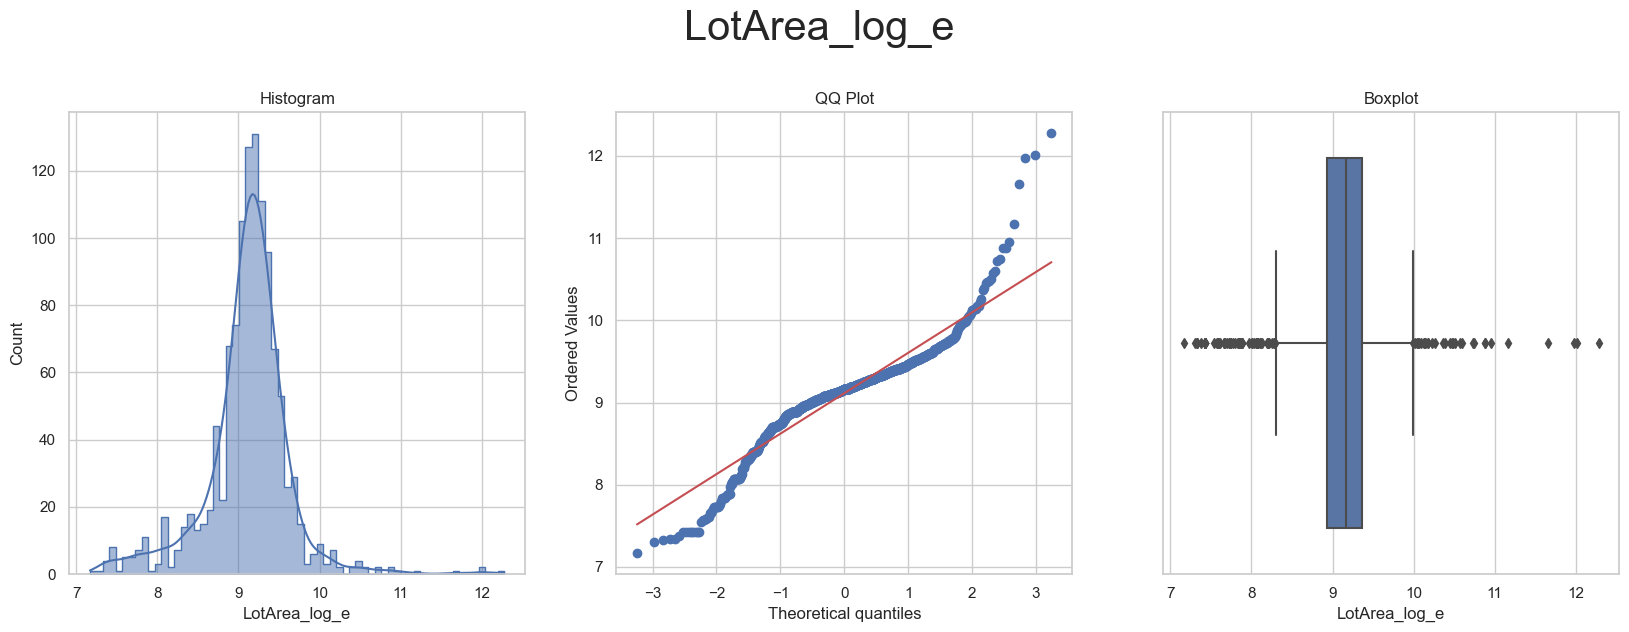

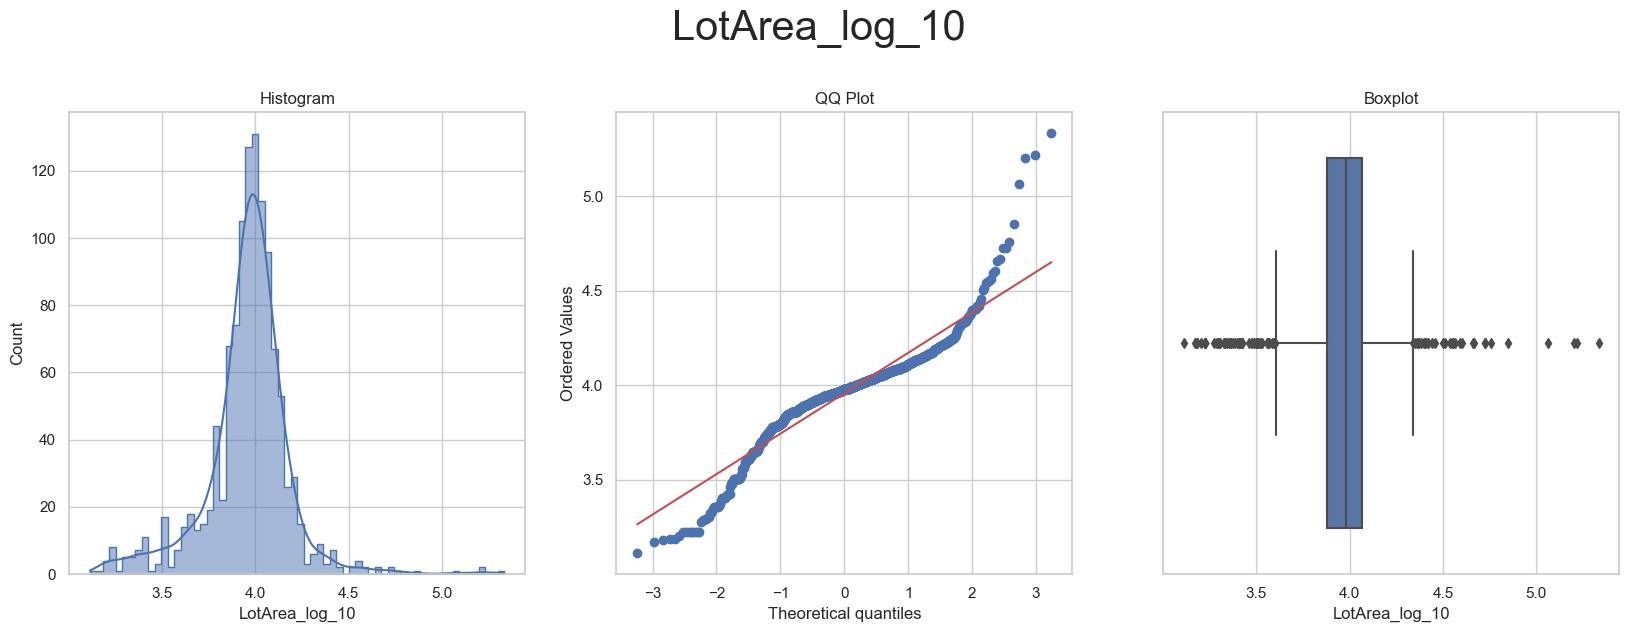

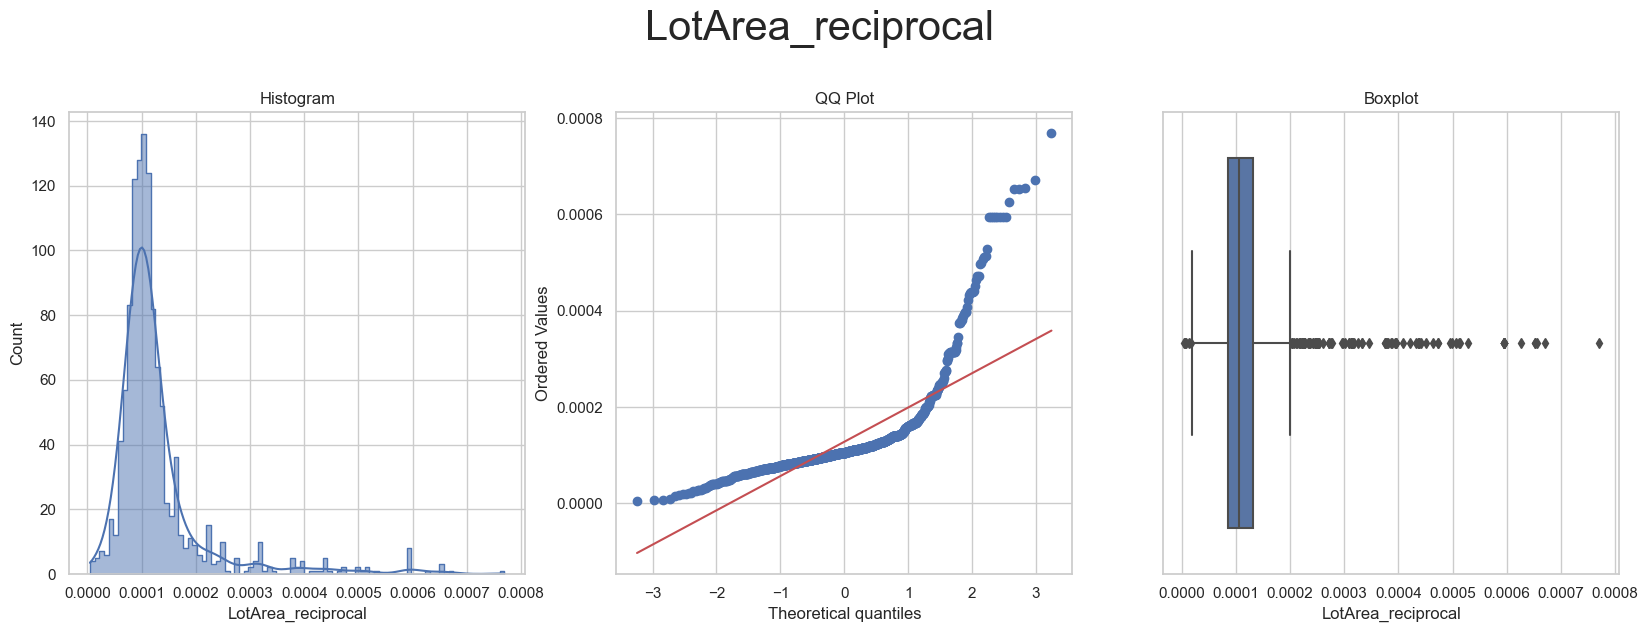

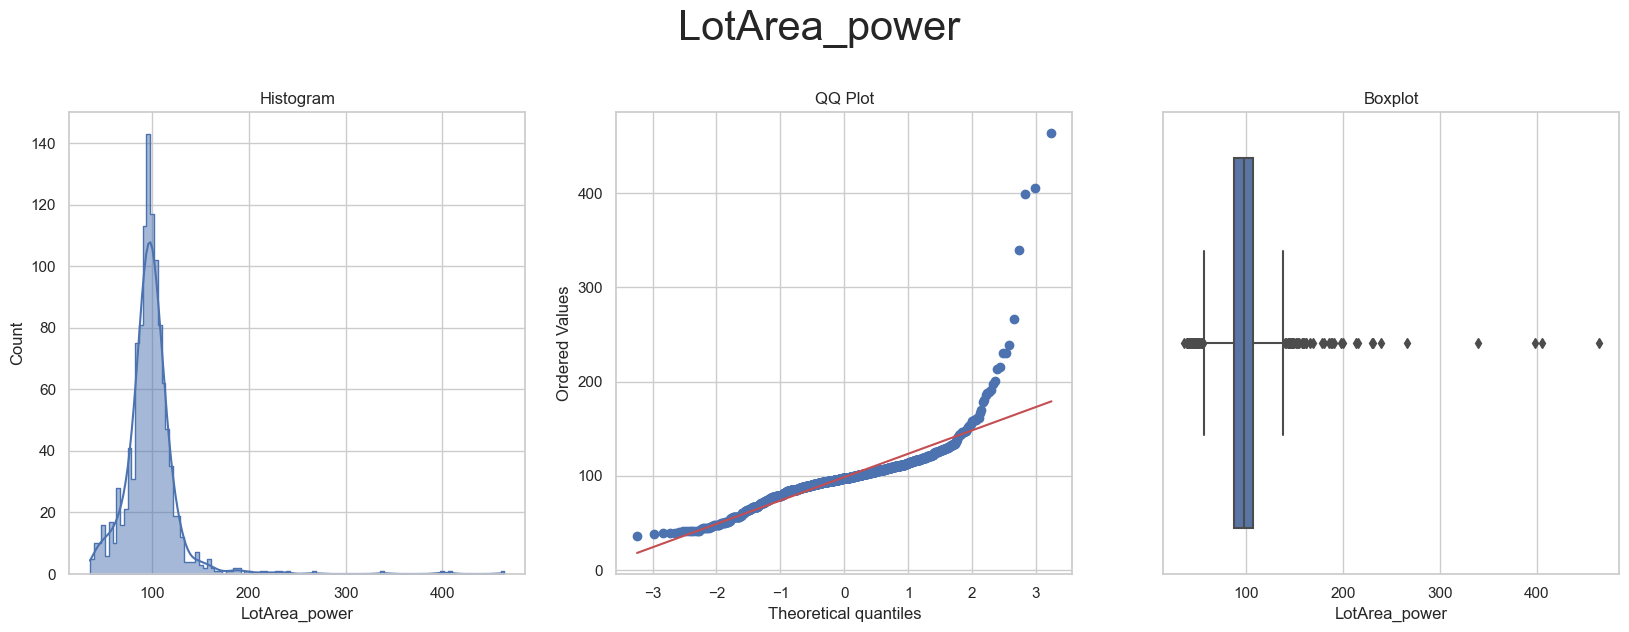

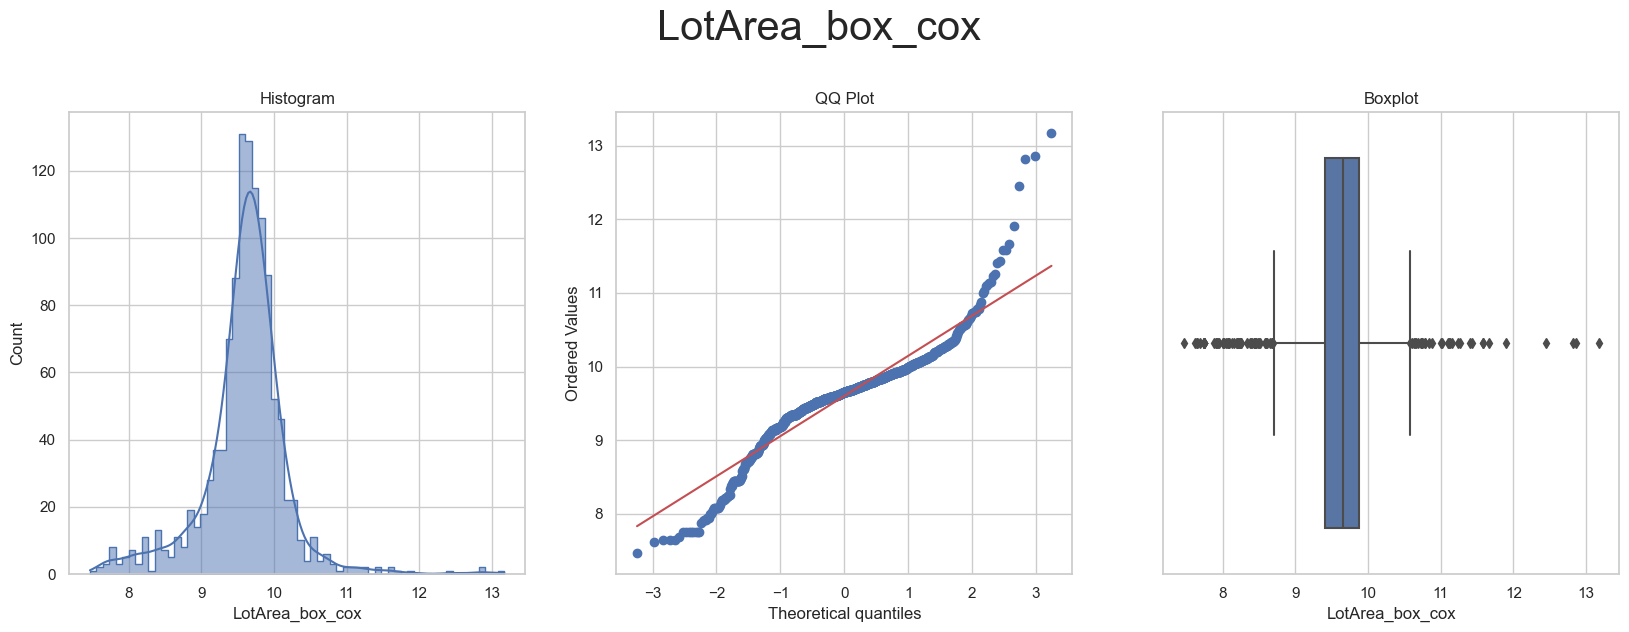

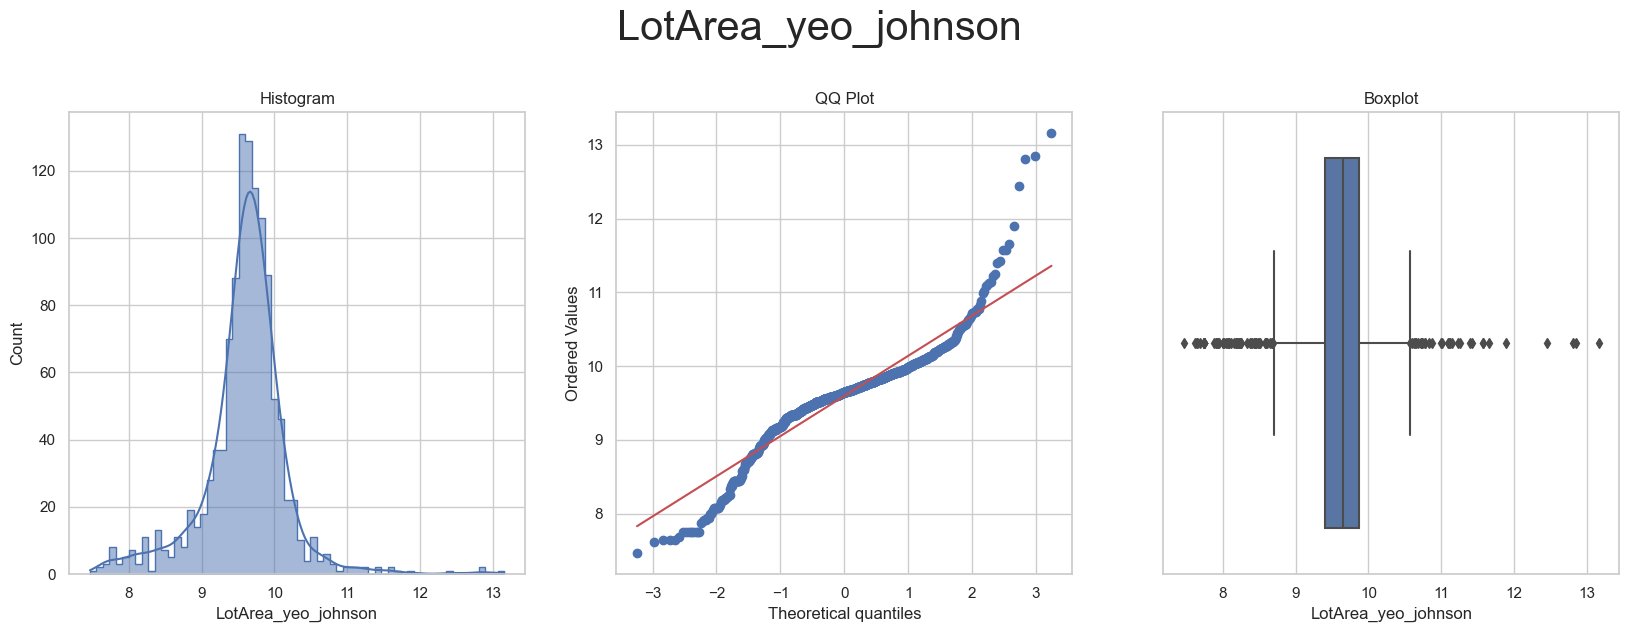



* Variable Analyzed: LotFrontage
* Applied transformation: ['LotFrontage_log_e', 'LotFrontage_log_10', 'LotFrontage_reciprocal', 'LotFrontage_power', 'LotFrontage_box_cox', 'LotFrontage_yeo_johnson'] 



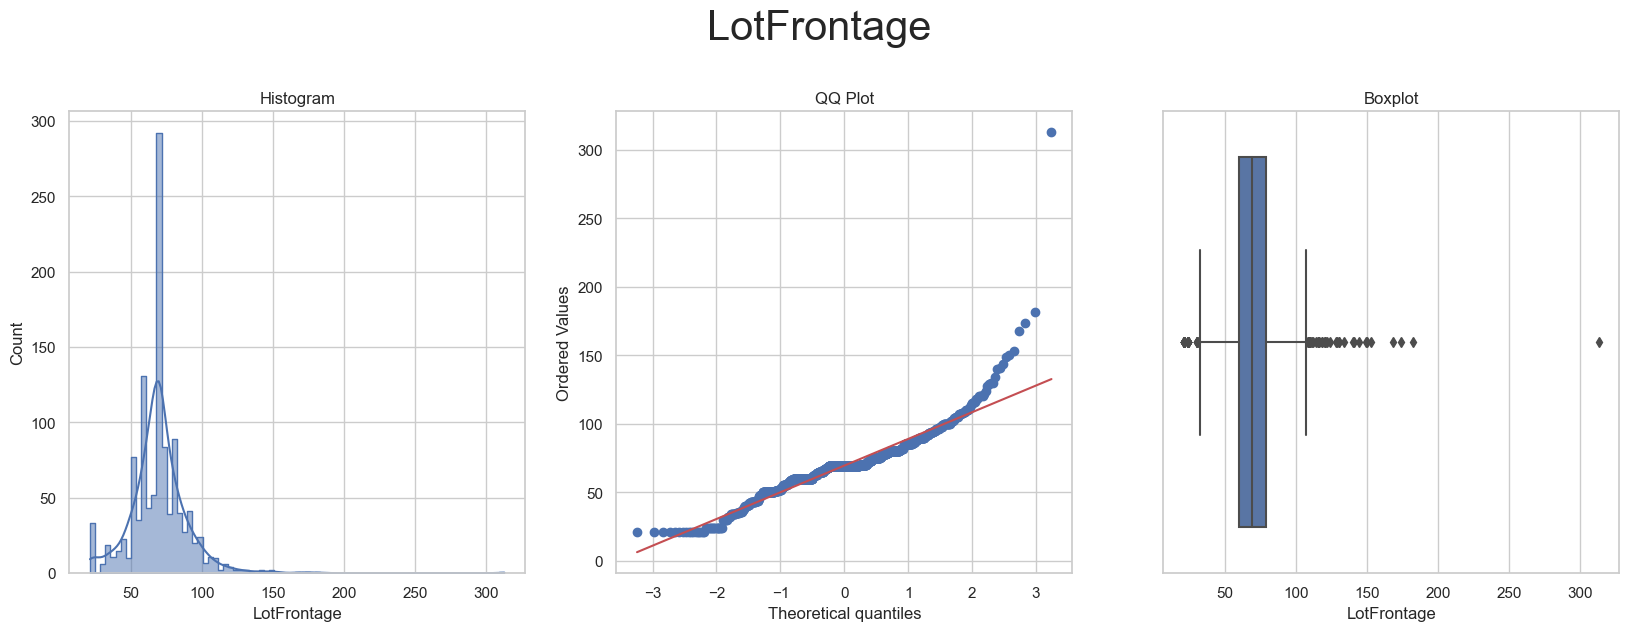

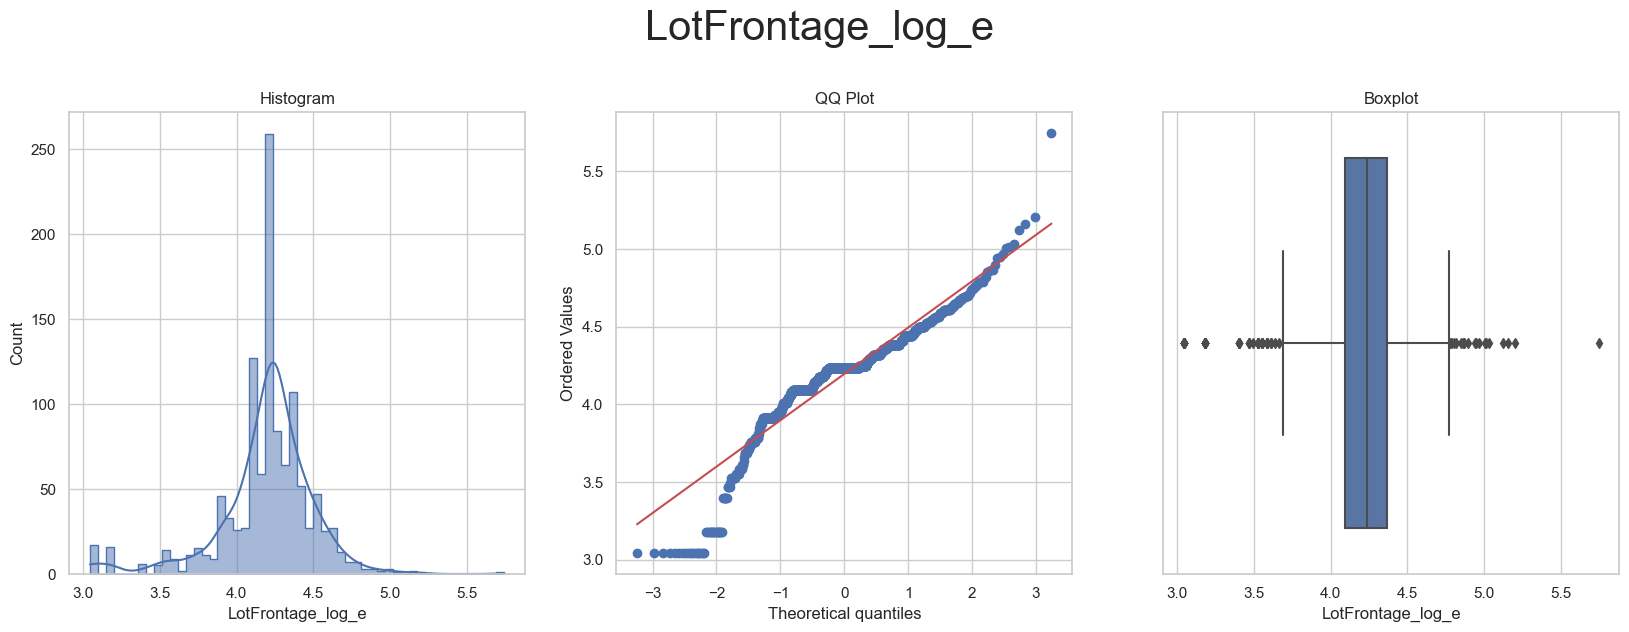

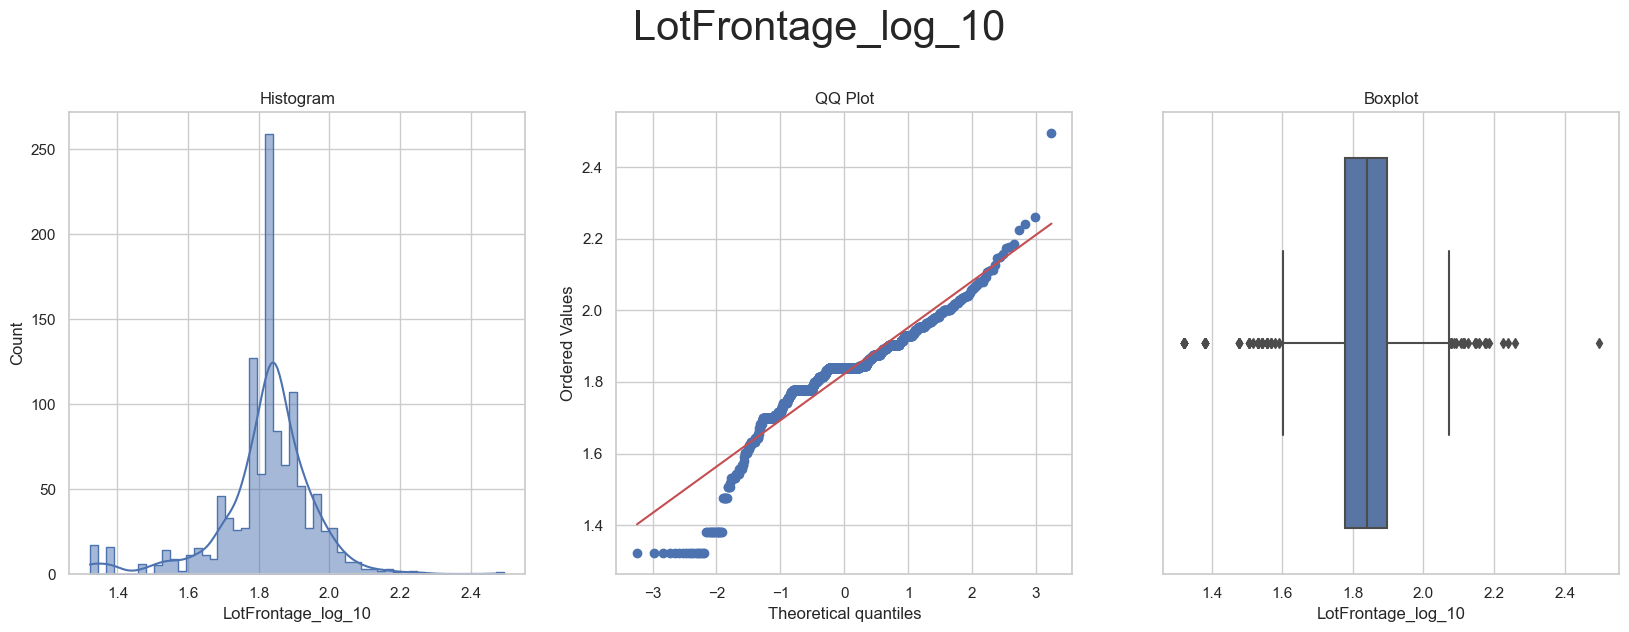

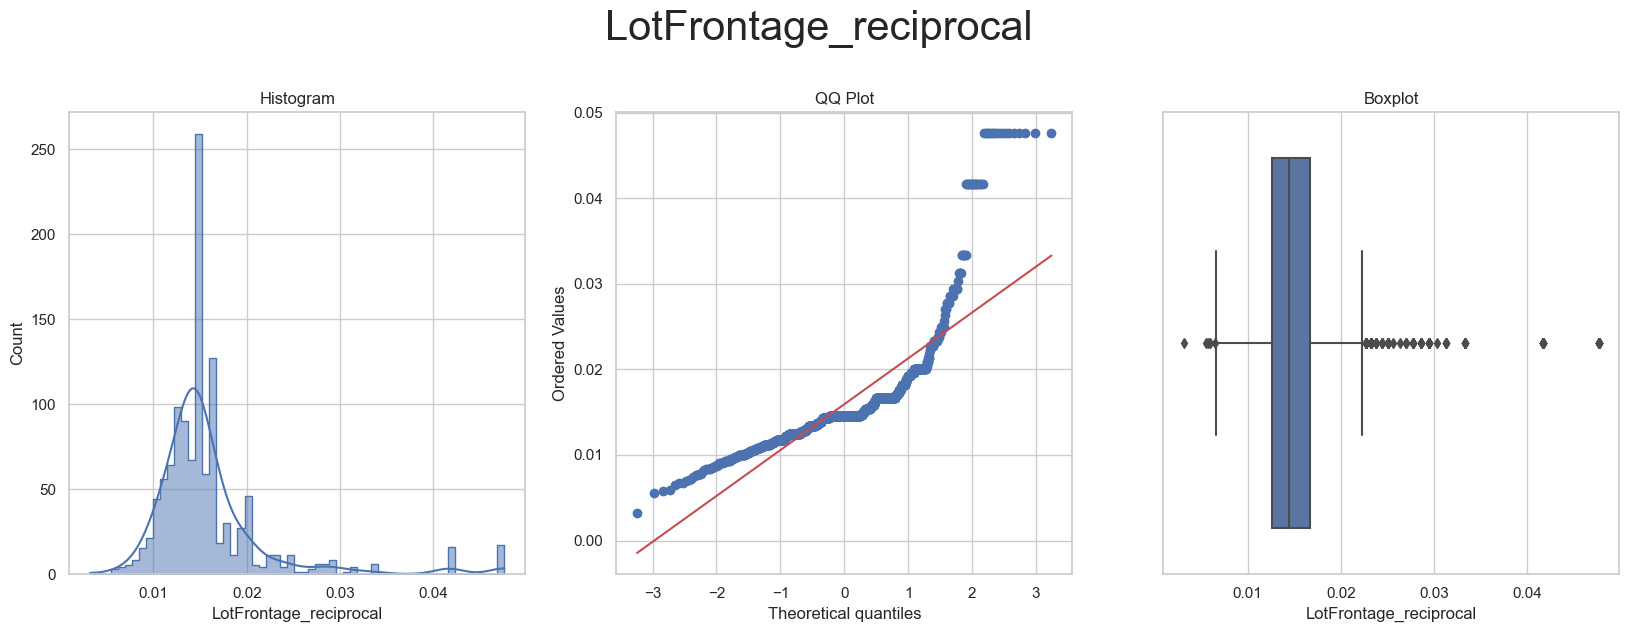

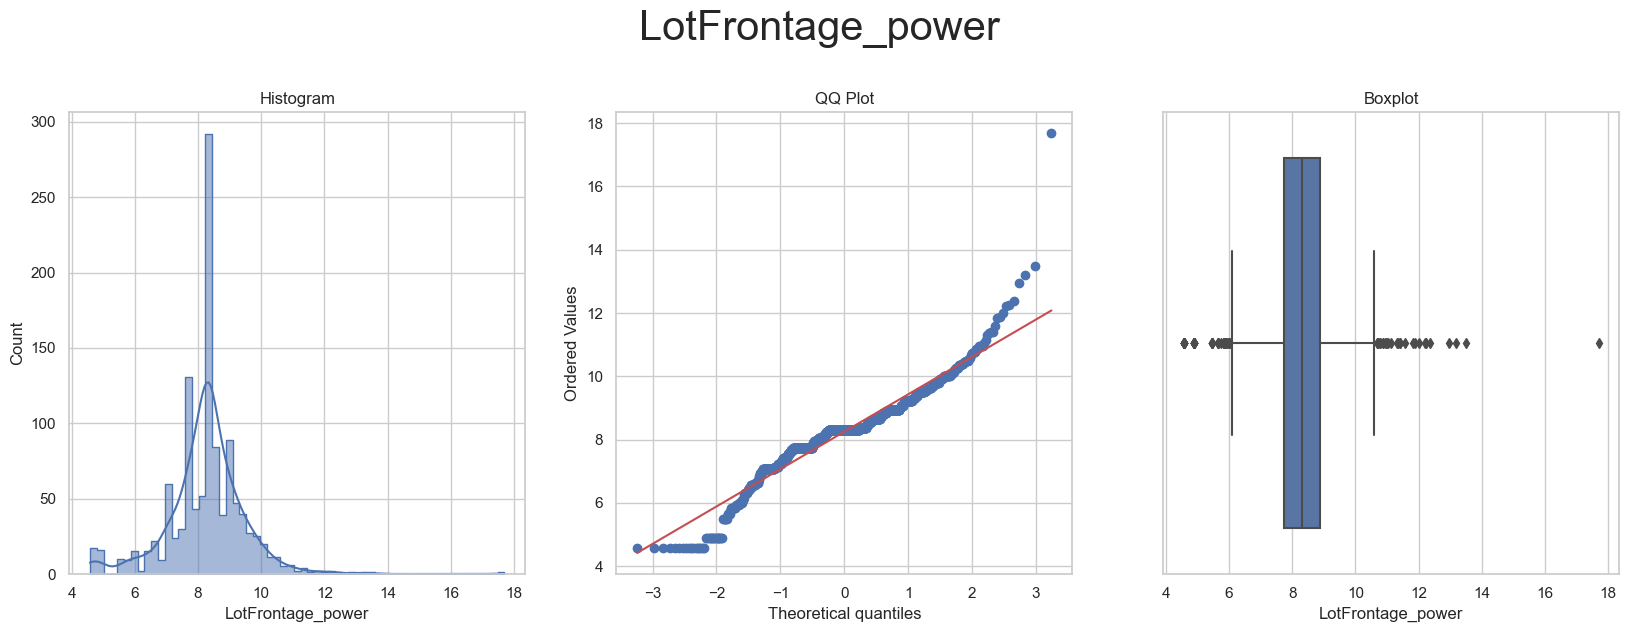

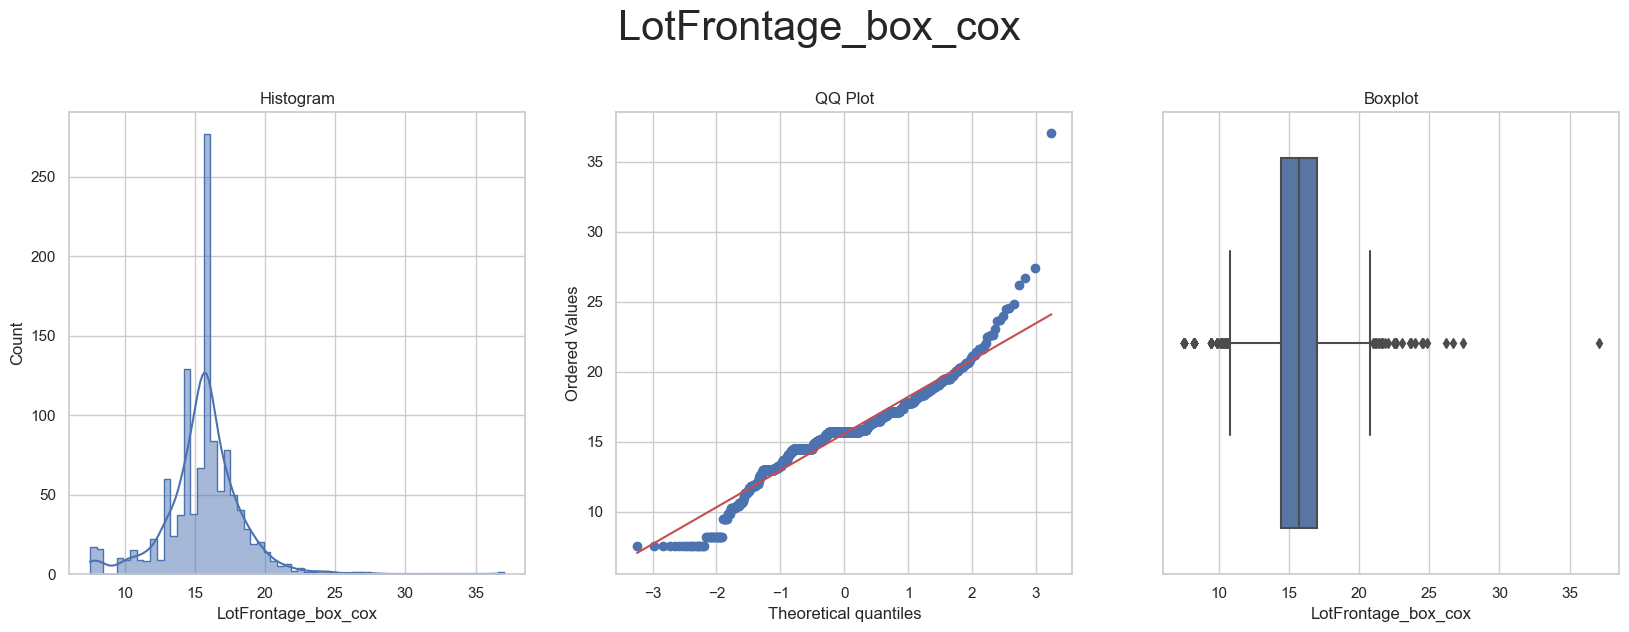

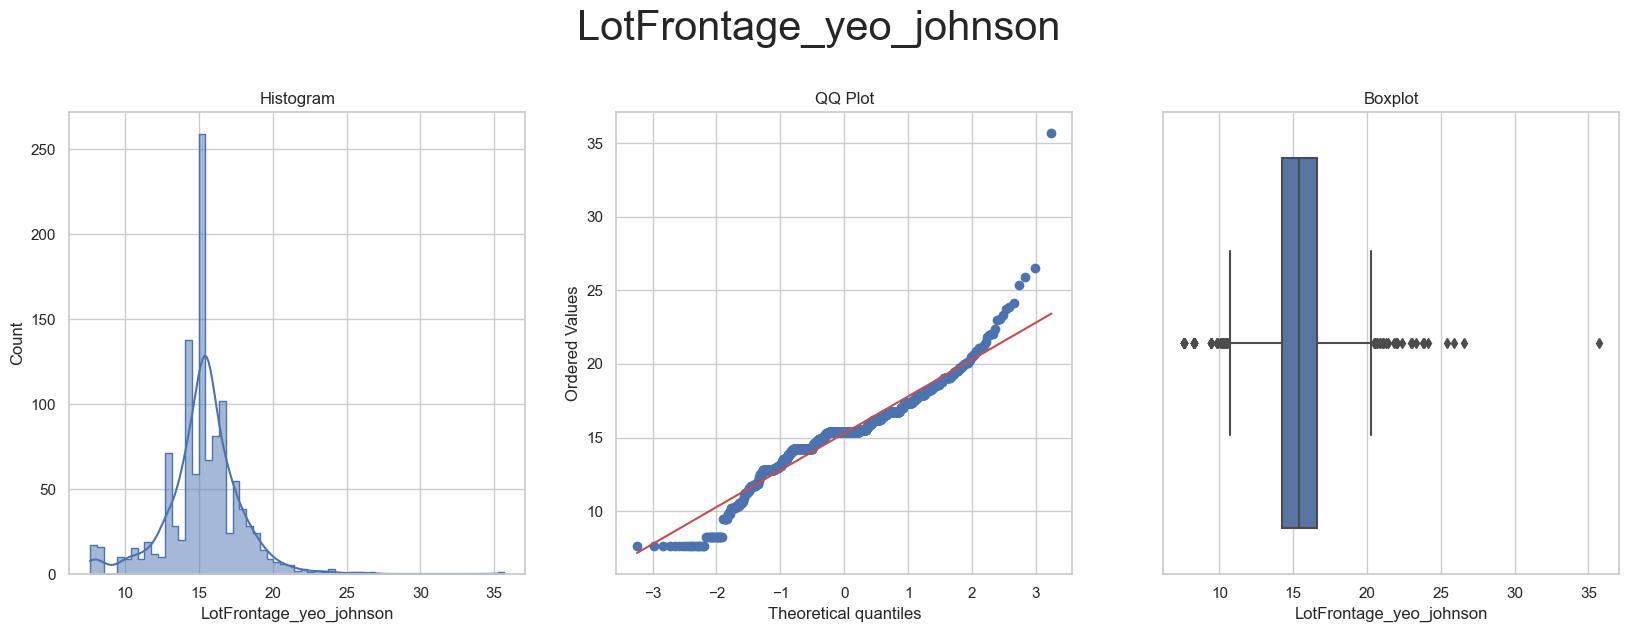



* Variable Analyzed: MasVnrArea
* Applied transformation: ['MasVnrArea_power', 'MasVnrArea_yeo_johnson'] 



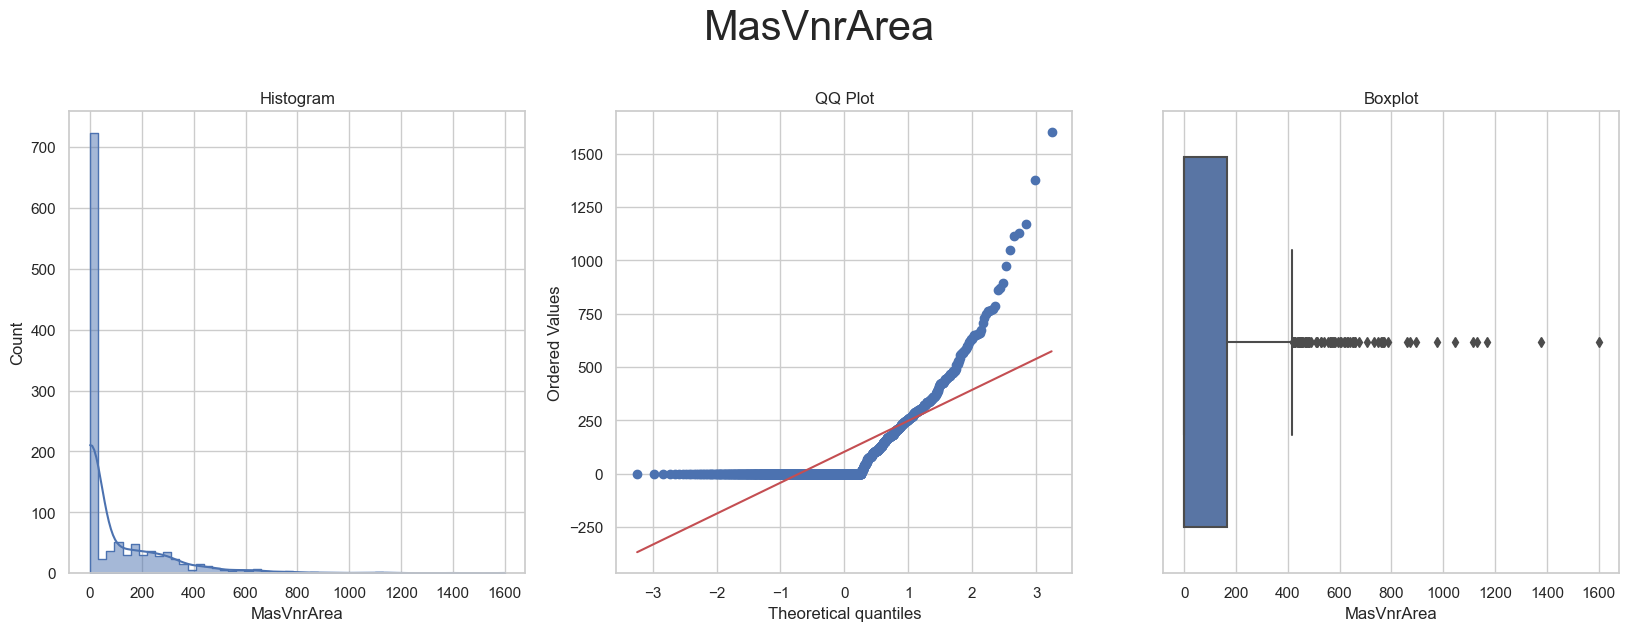

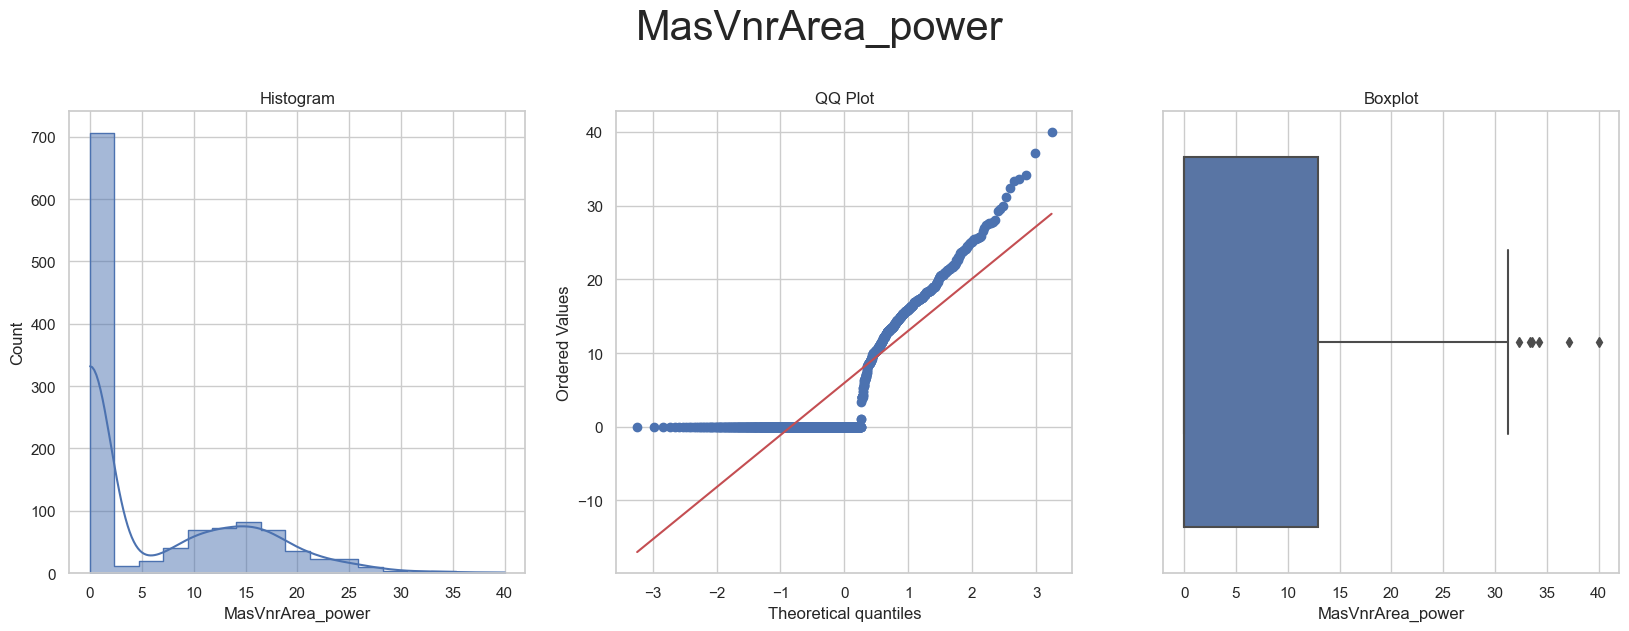

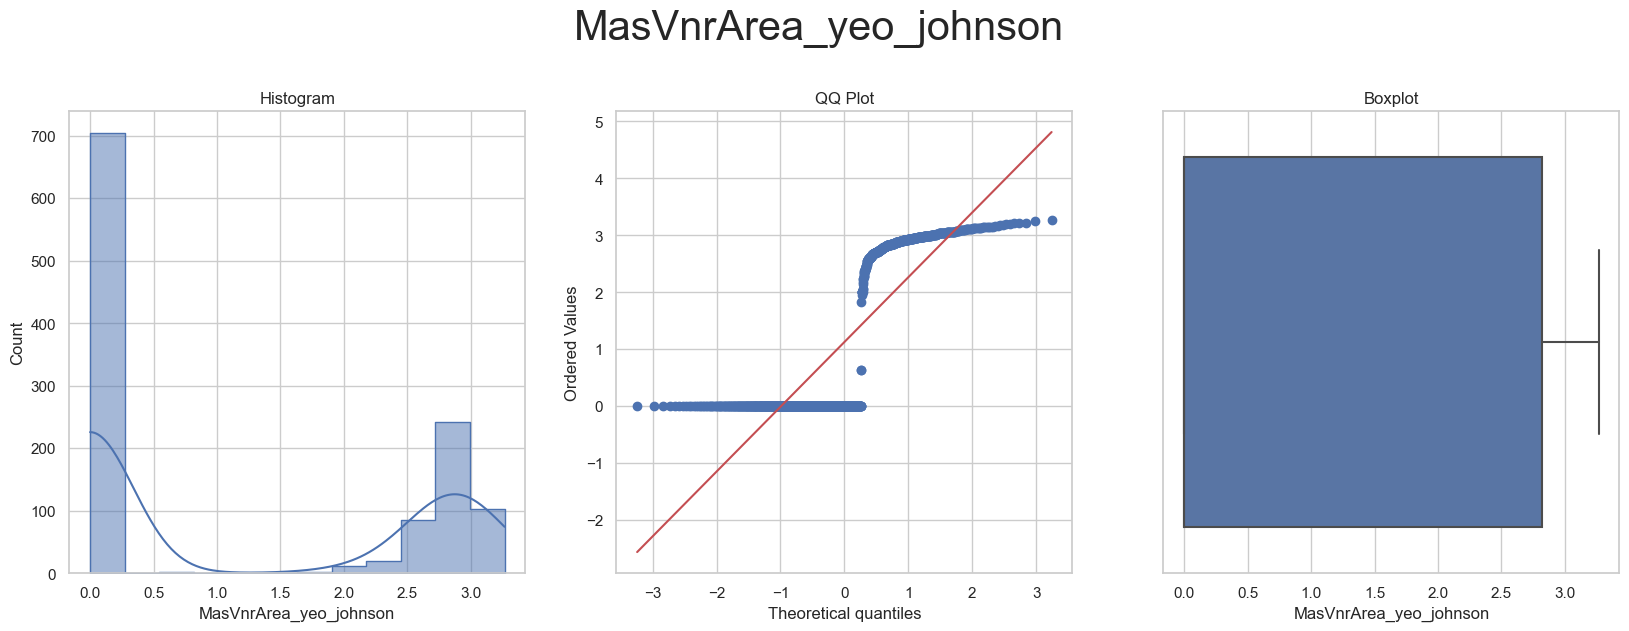



* Variable Analyzed: OpenPorchSF
* Applied transformation: ['OpenPorchSF_power', 'OpenPorchSF_yeo_johnson'] 



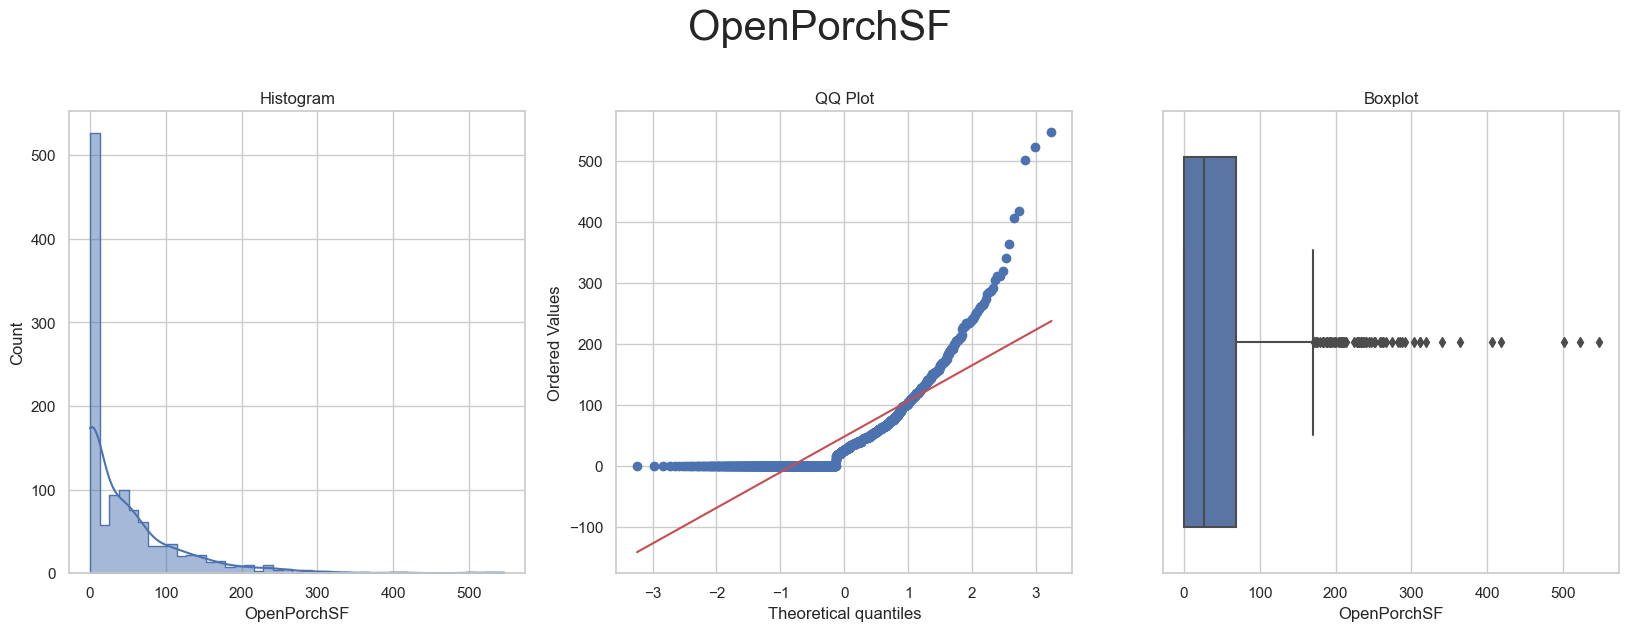

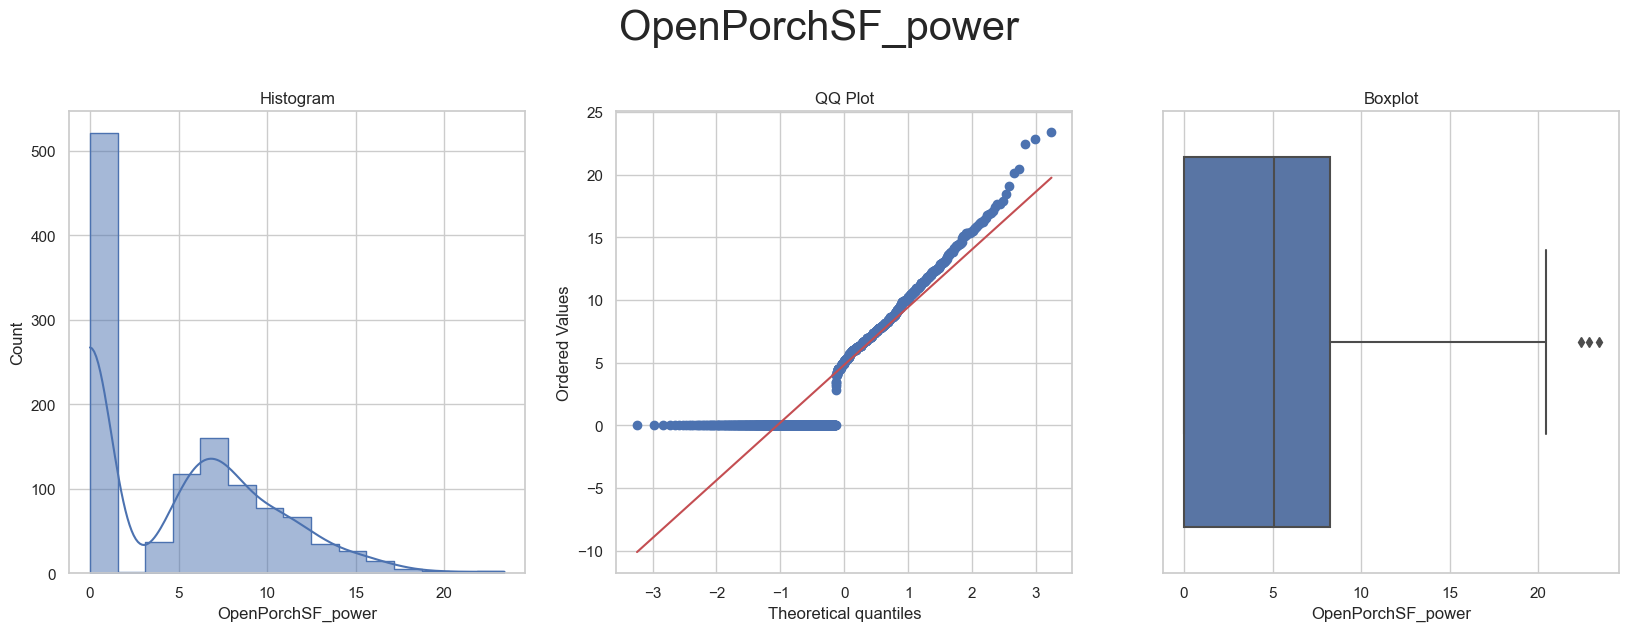

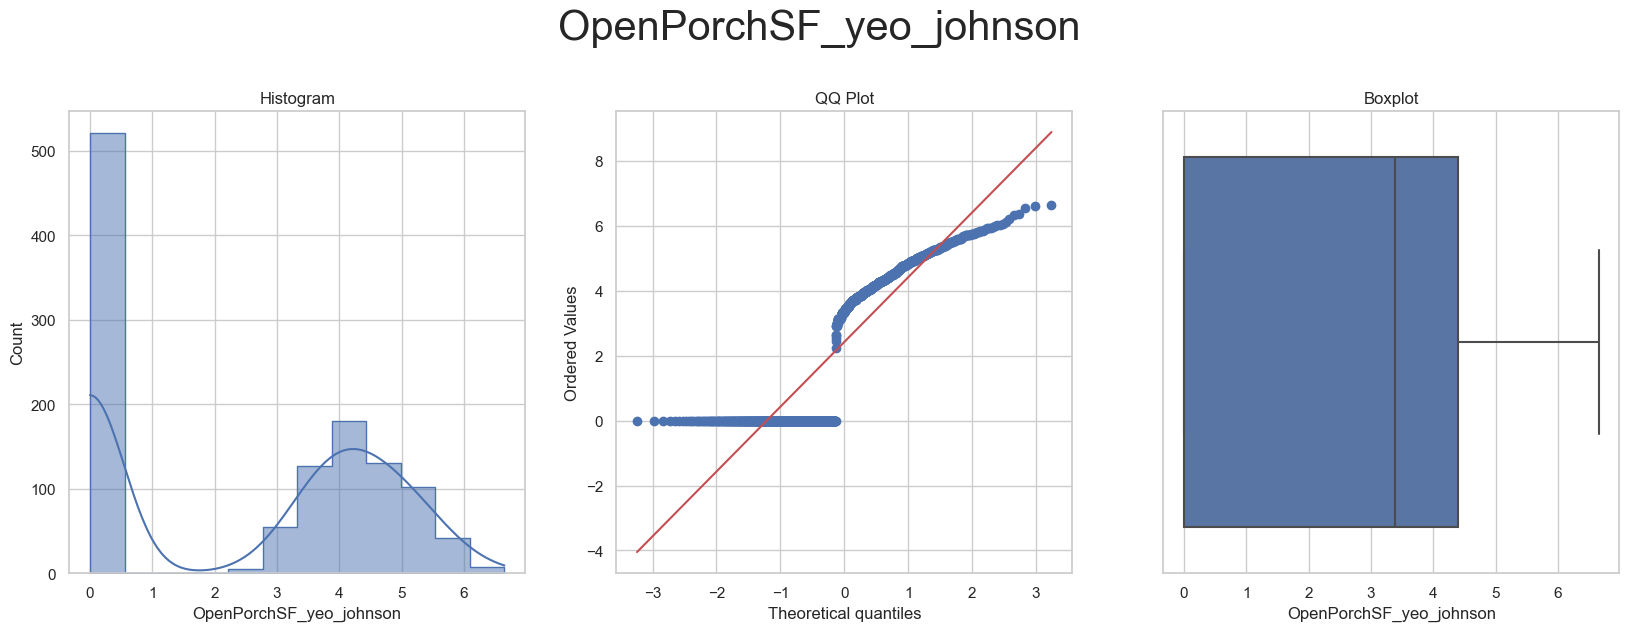



* Variable Analyzed: TotalBsmtSF
* Applied transformation: ['TotalBsmtSF_power', 'TotalBsmtSF_yeo_johnson'] 



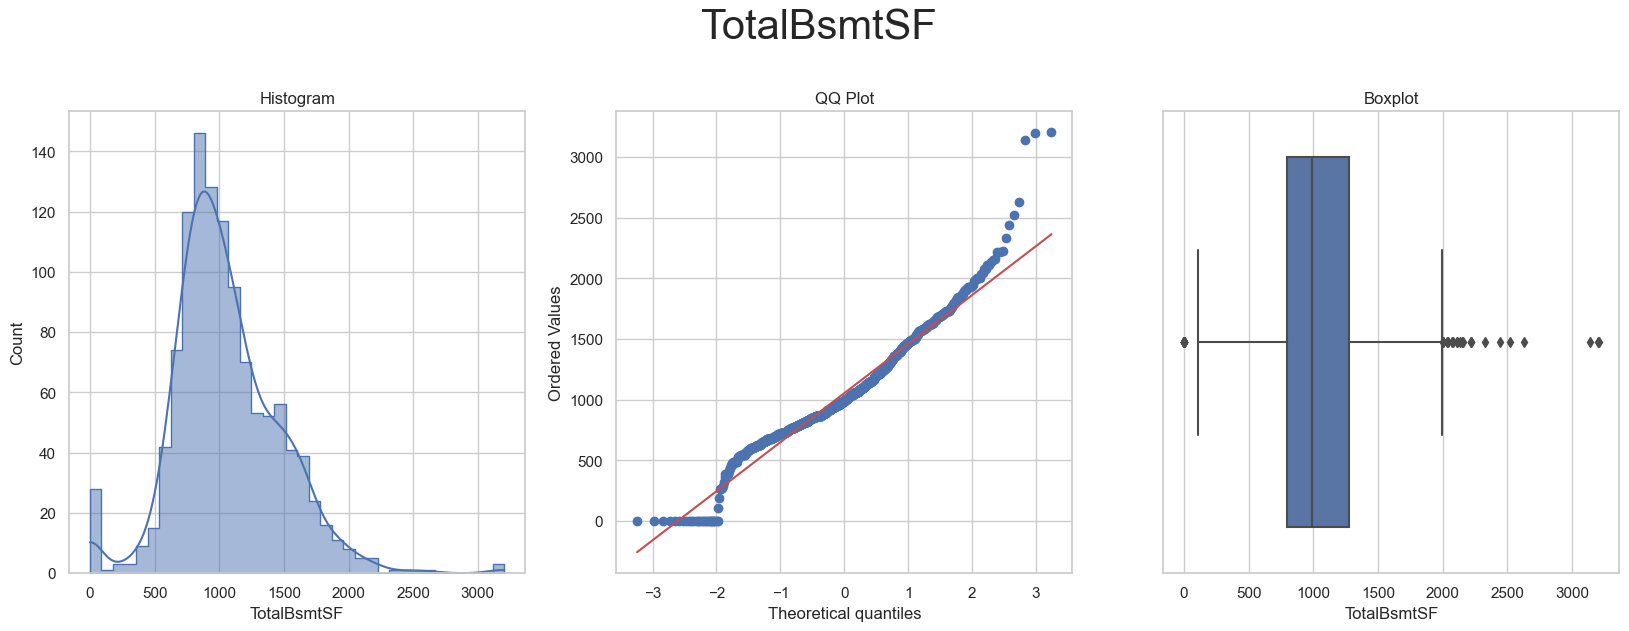

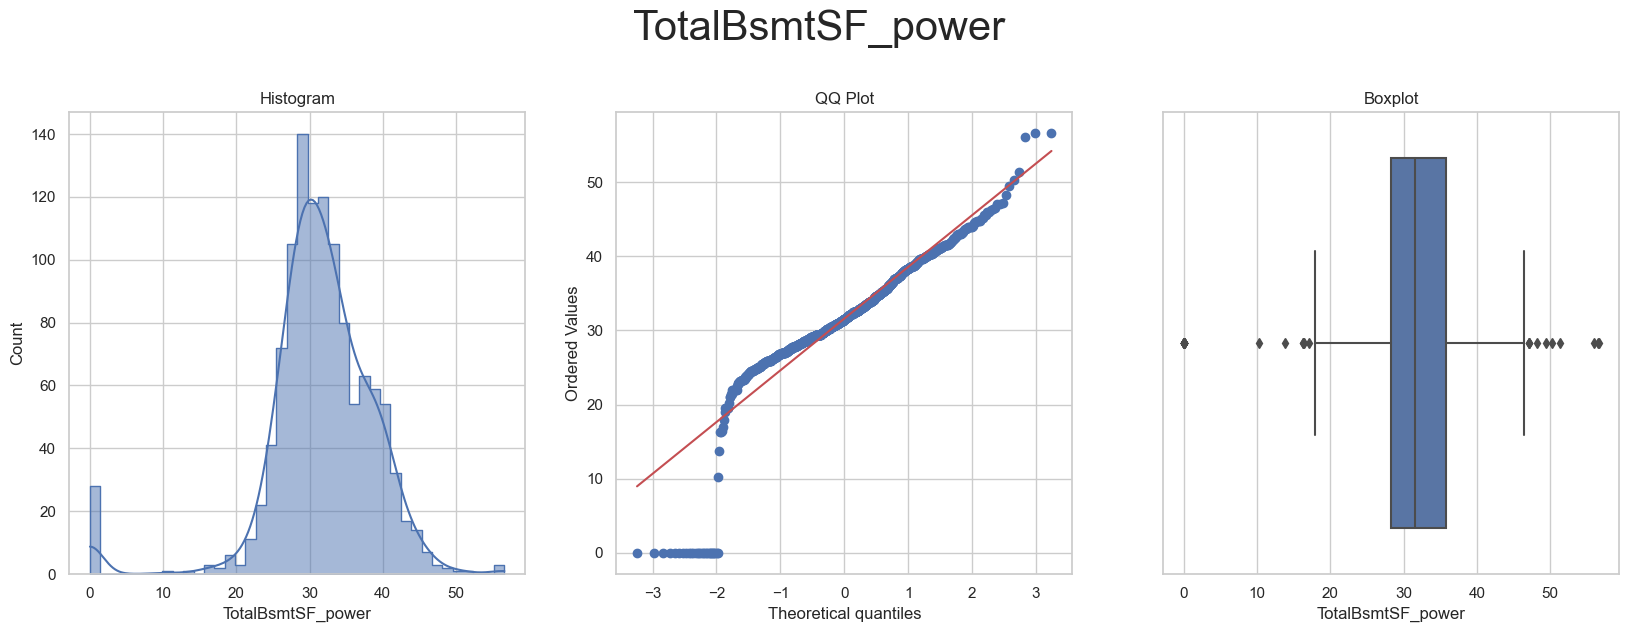

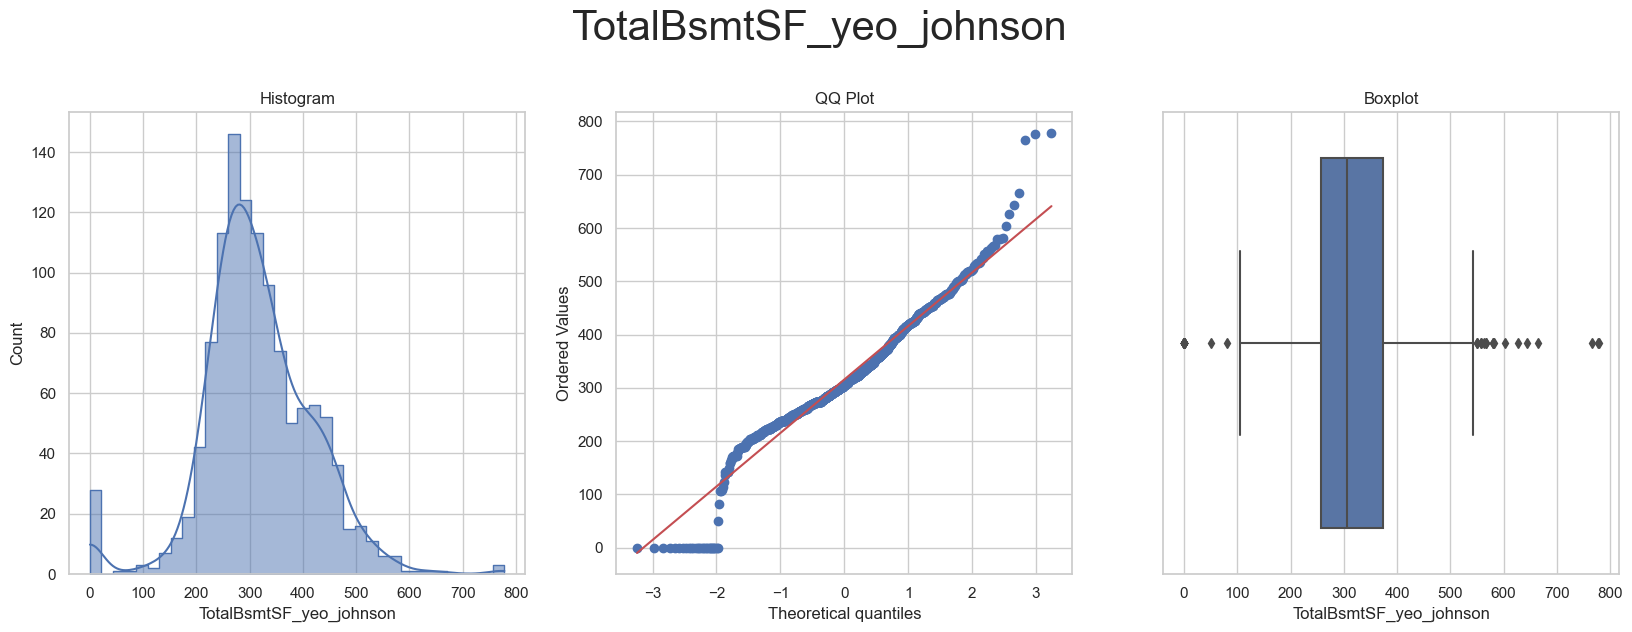



* Variable Analyzed: YearBuilt
* Applied transformation: ['YearBuilt_log_e', 'YearBuilt_log_10', 'YearBuilt_reciprocal', 'YearBuilt_power', 'YearBuilt_box_cox', 'YearBuilt_yeo_johnson'] 



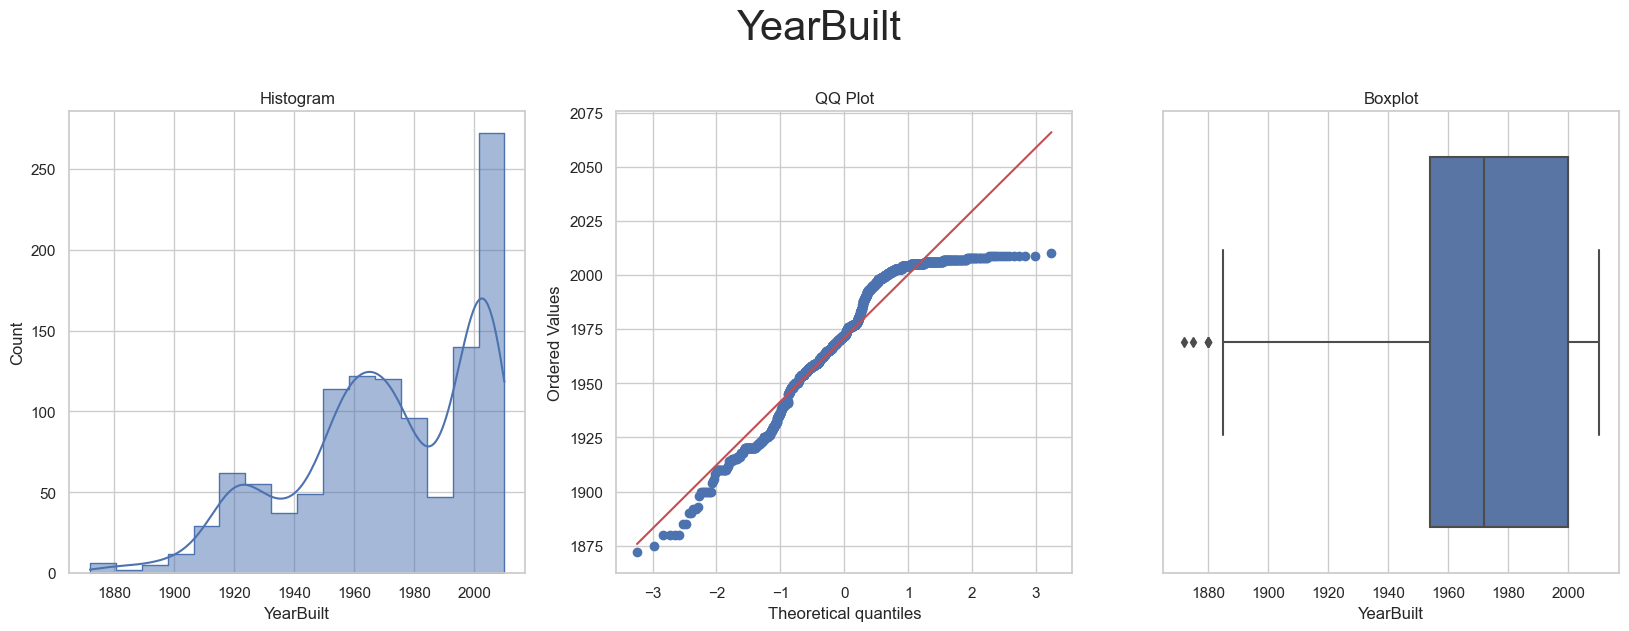

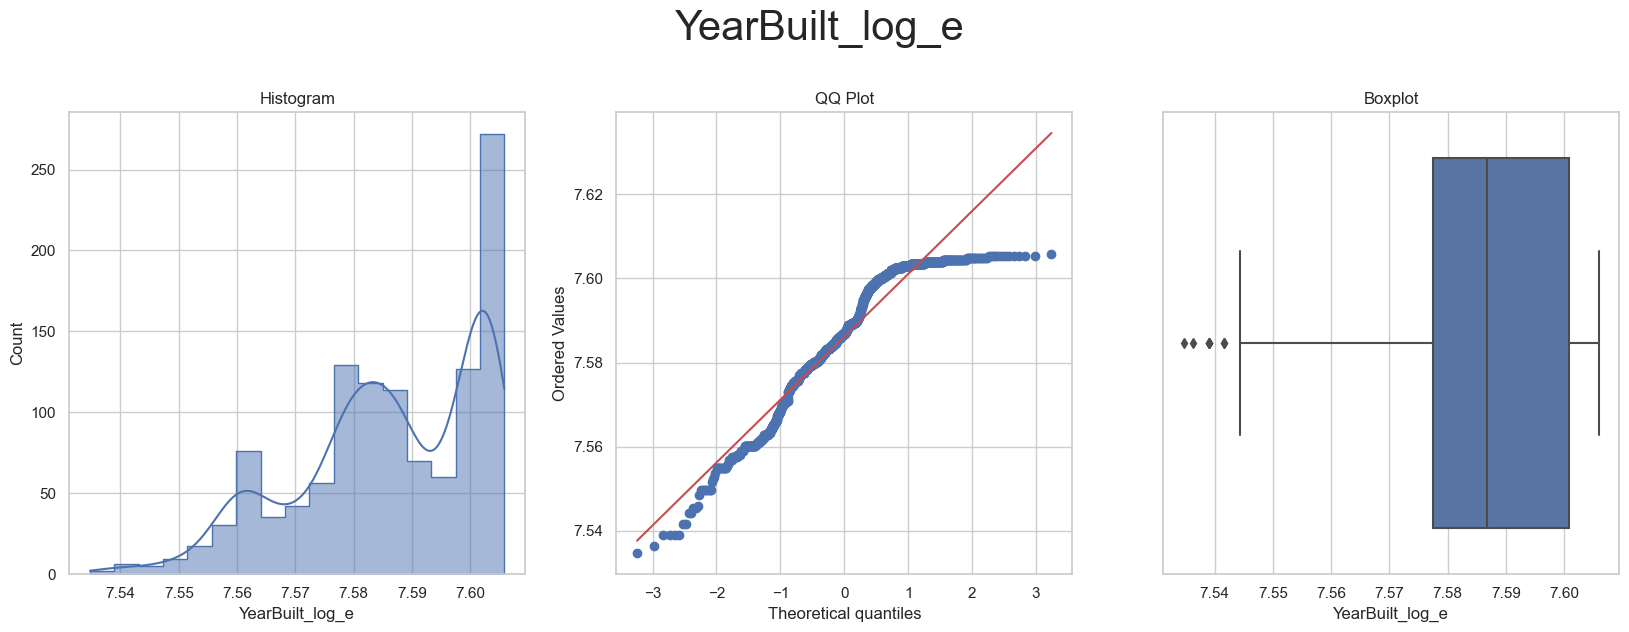

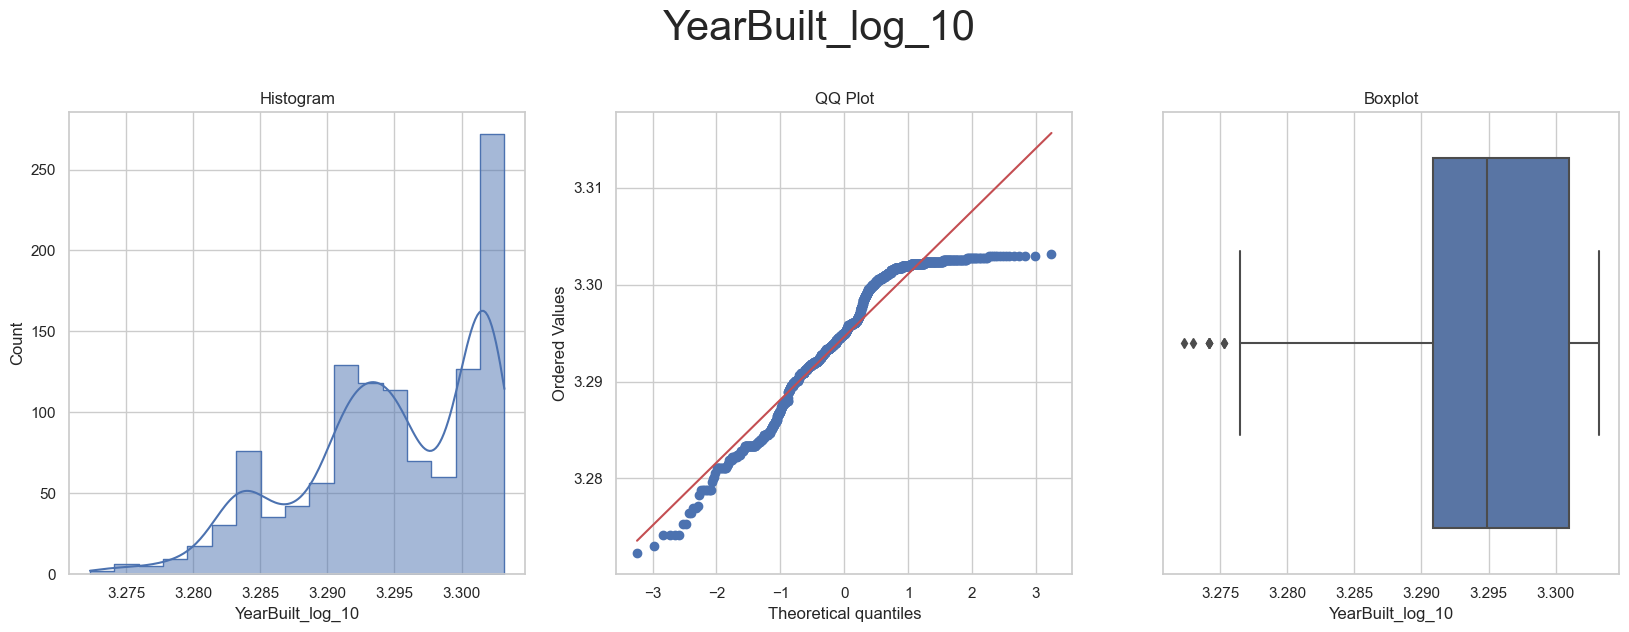

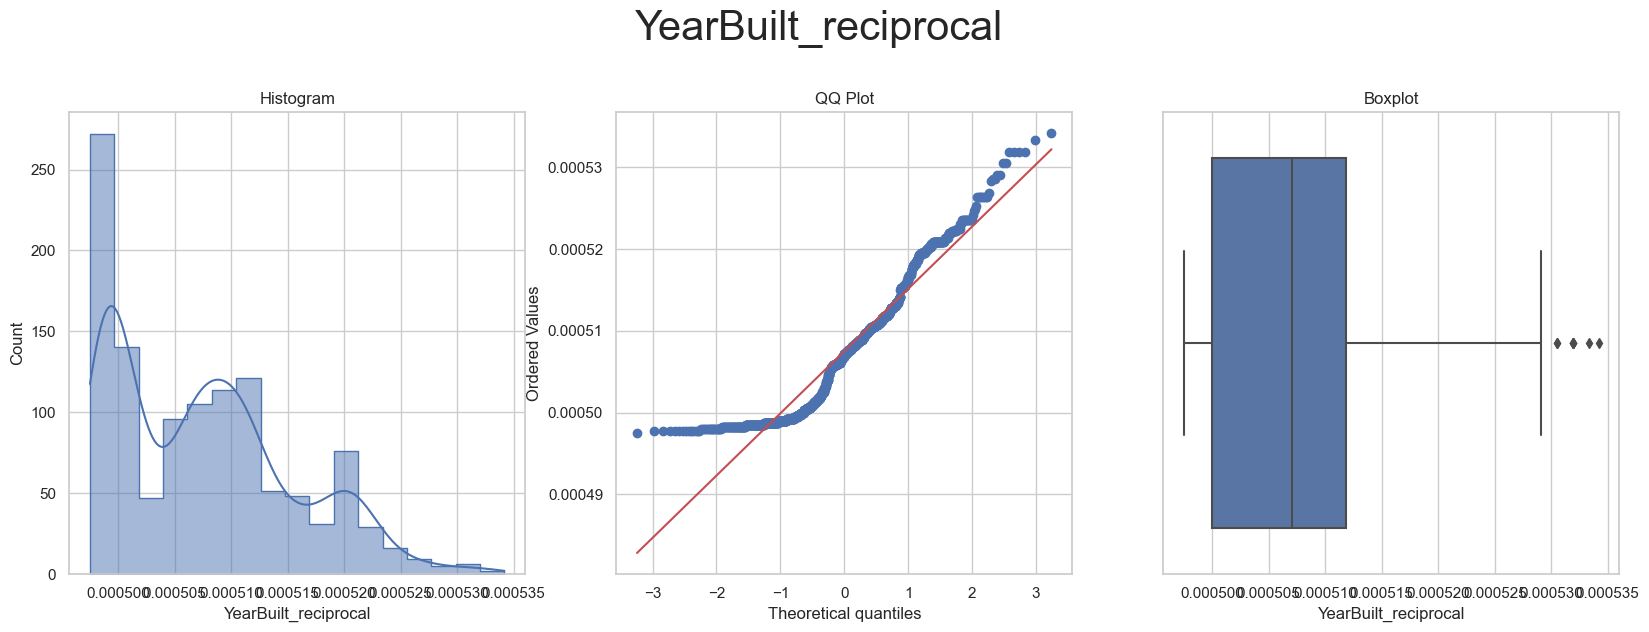

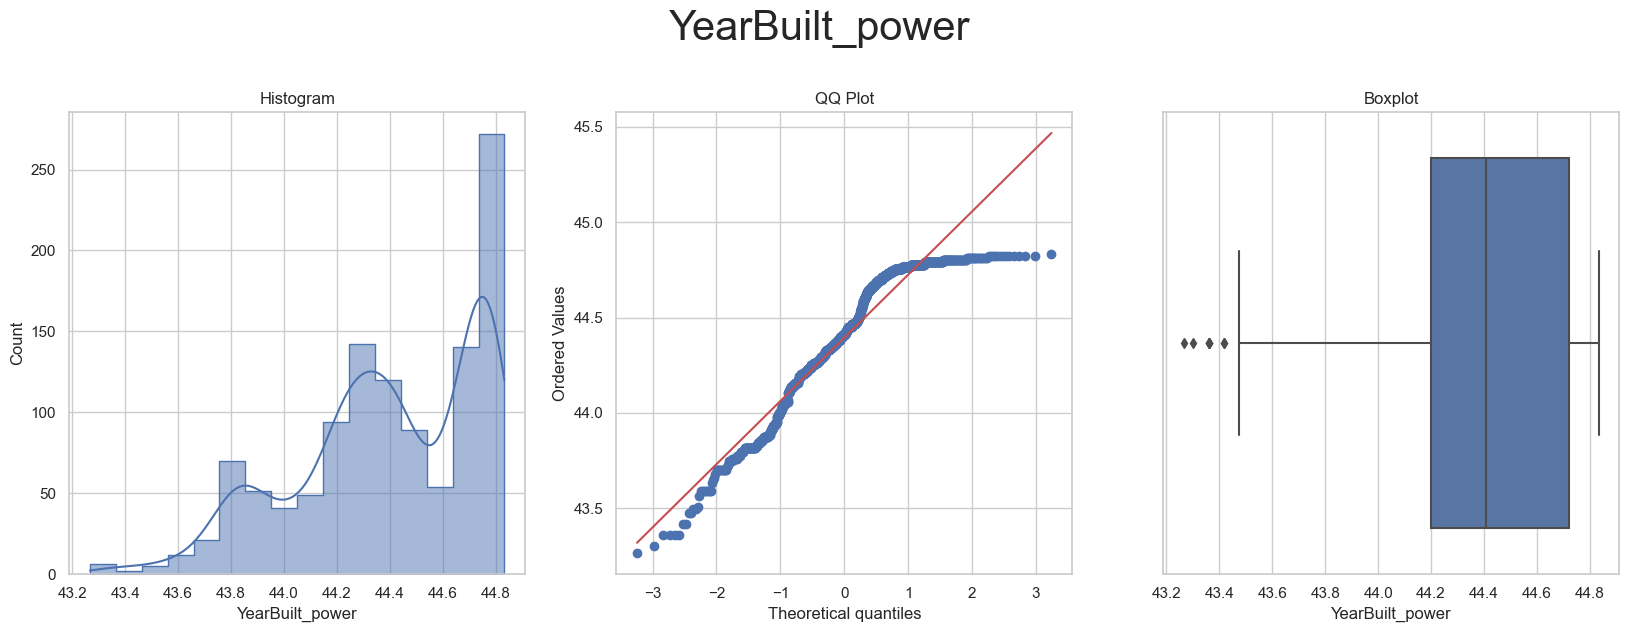

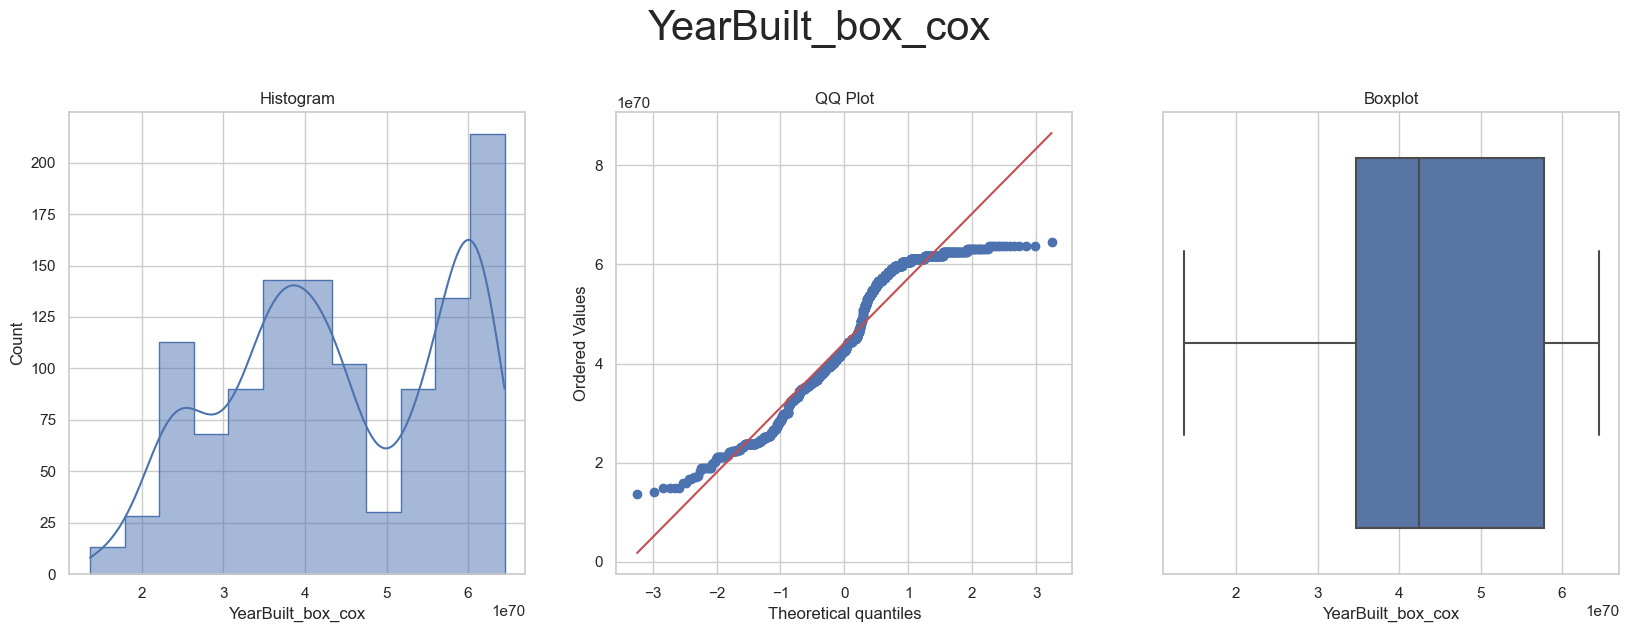

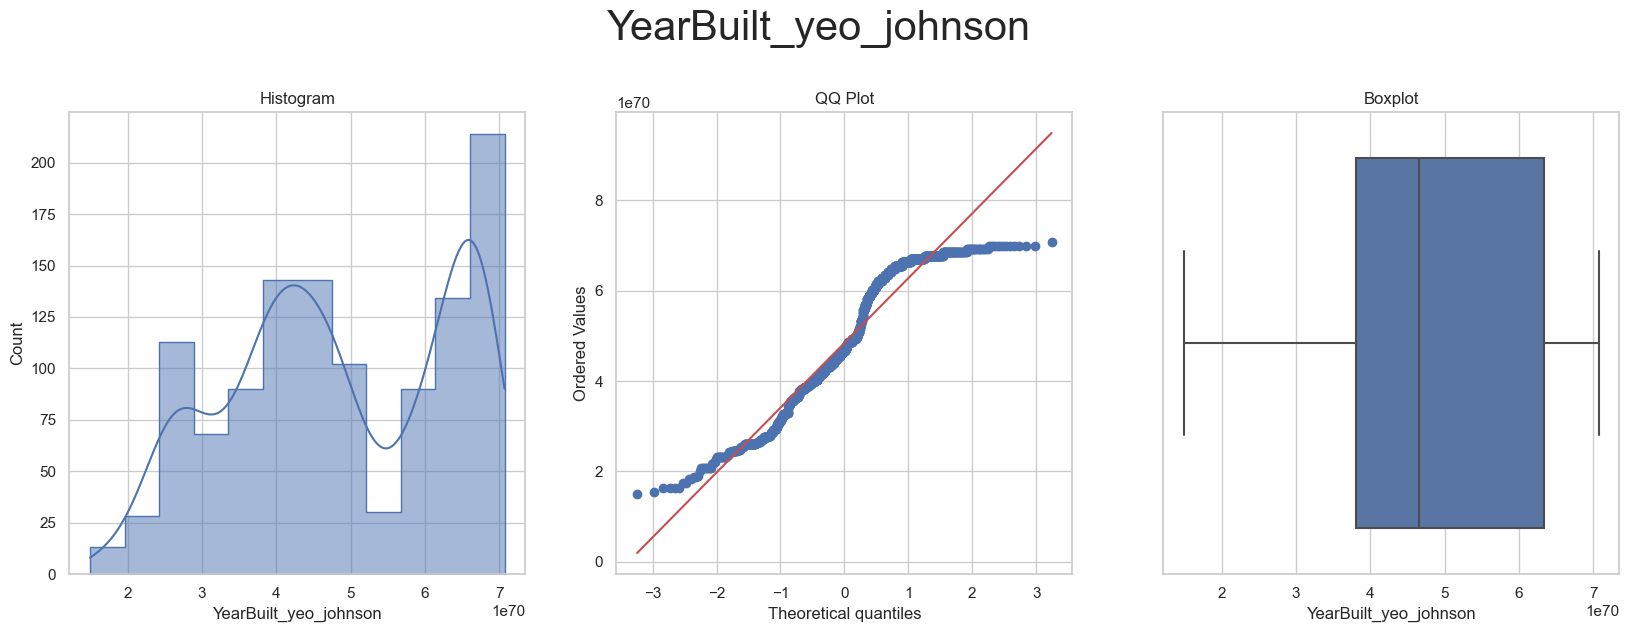



* Variable Analyzed: YearRemodAdd
* Applied transformation: ['YearRemodAdd_log_e', 'YearRemodAdd_log_10', 'YearRemodAdd_reciprocal', 'YearRemodAdd_power', 'YearRemodAdd_box_cox', 'YearRemodAdd_yeo_johnson'] 



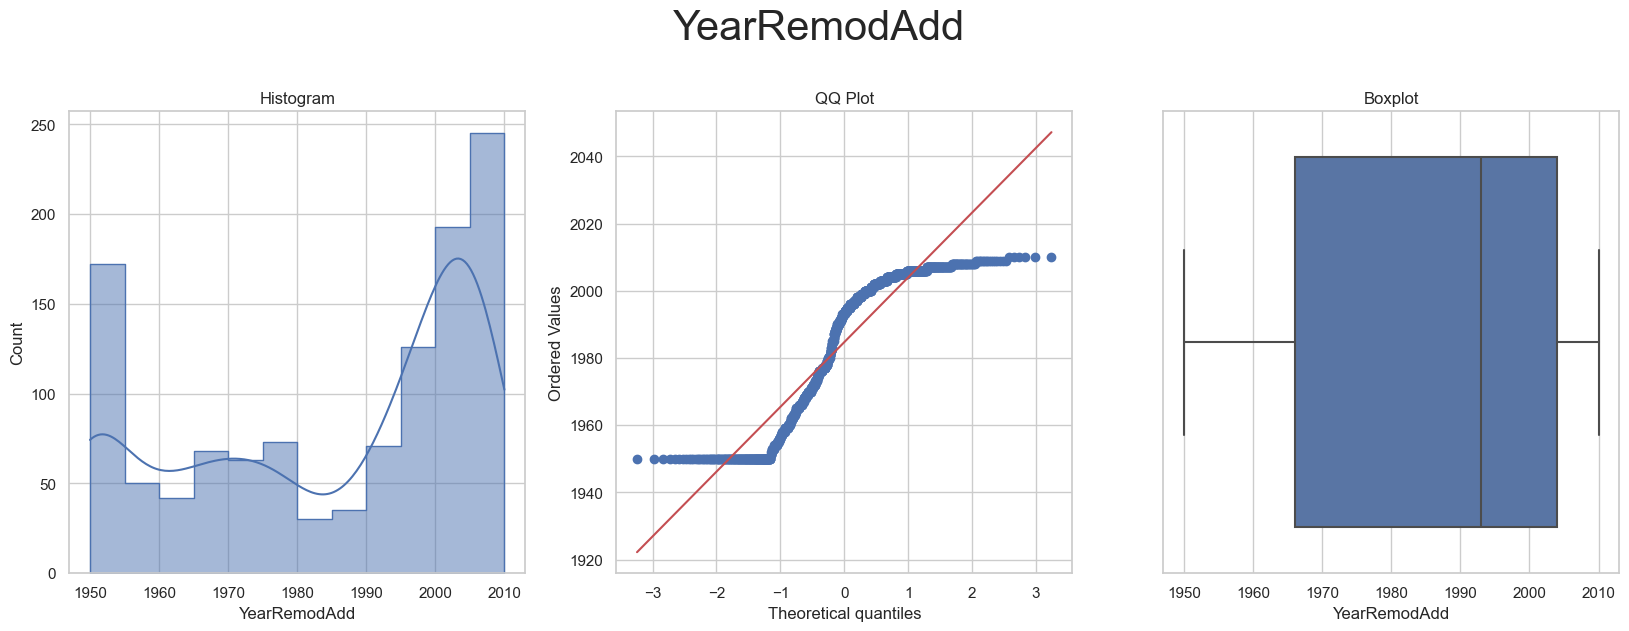

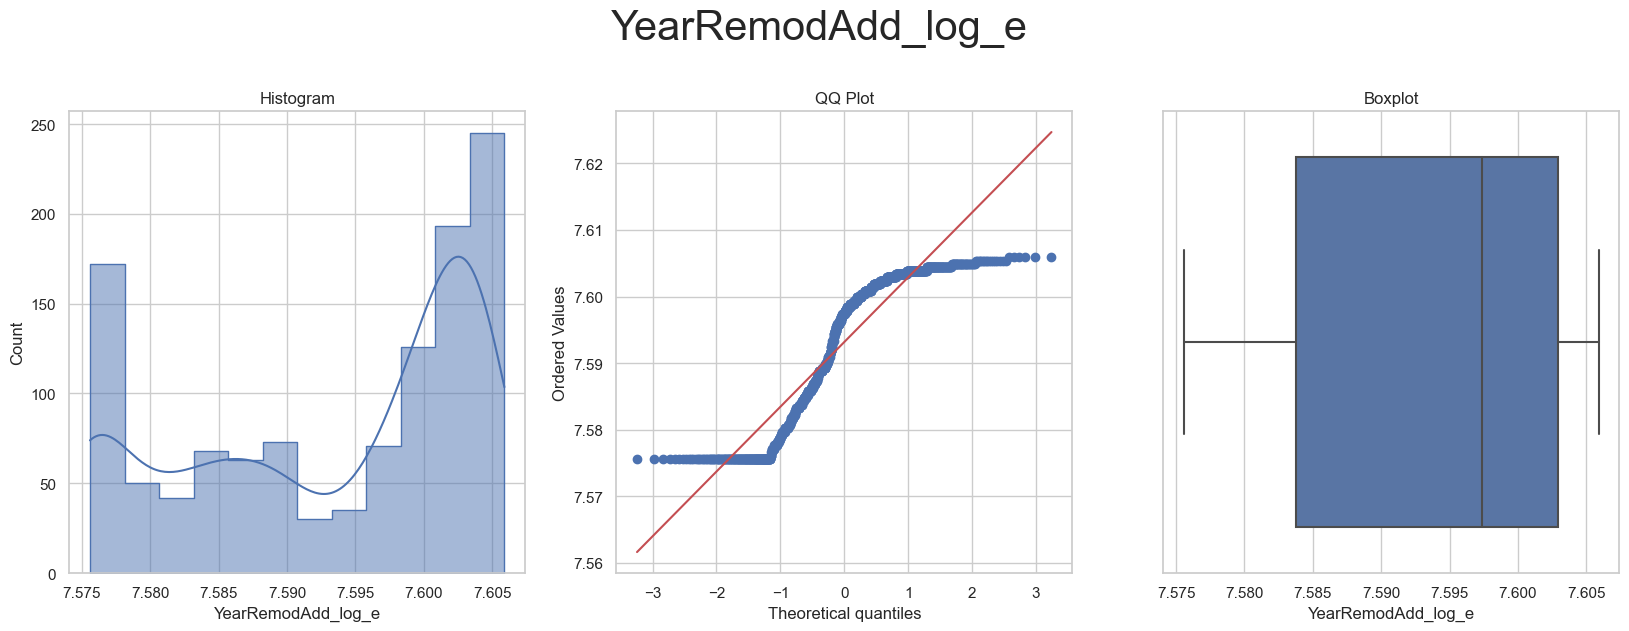

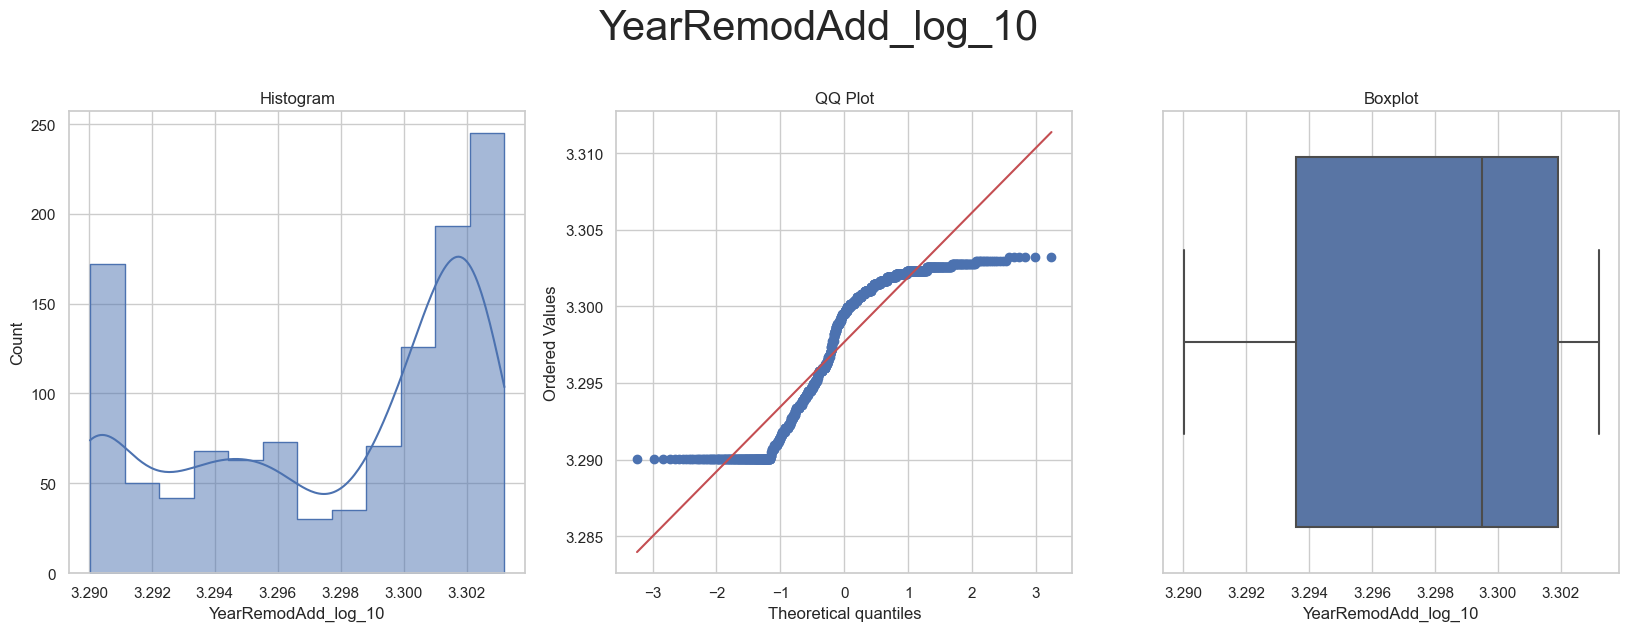

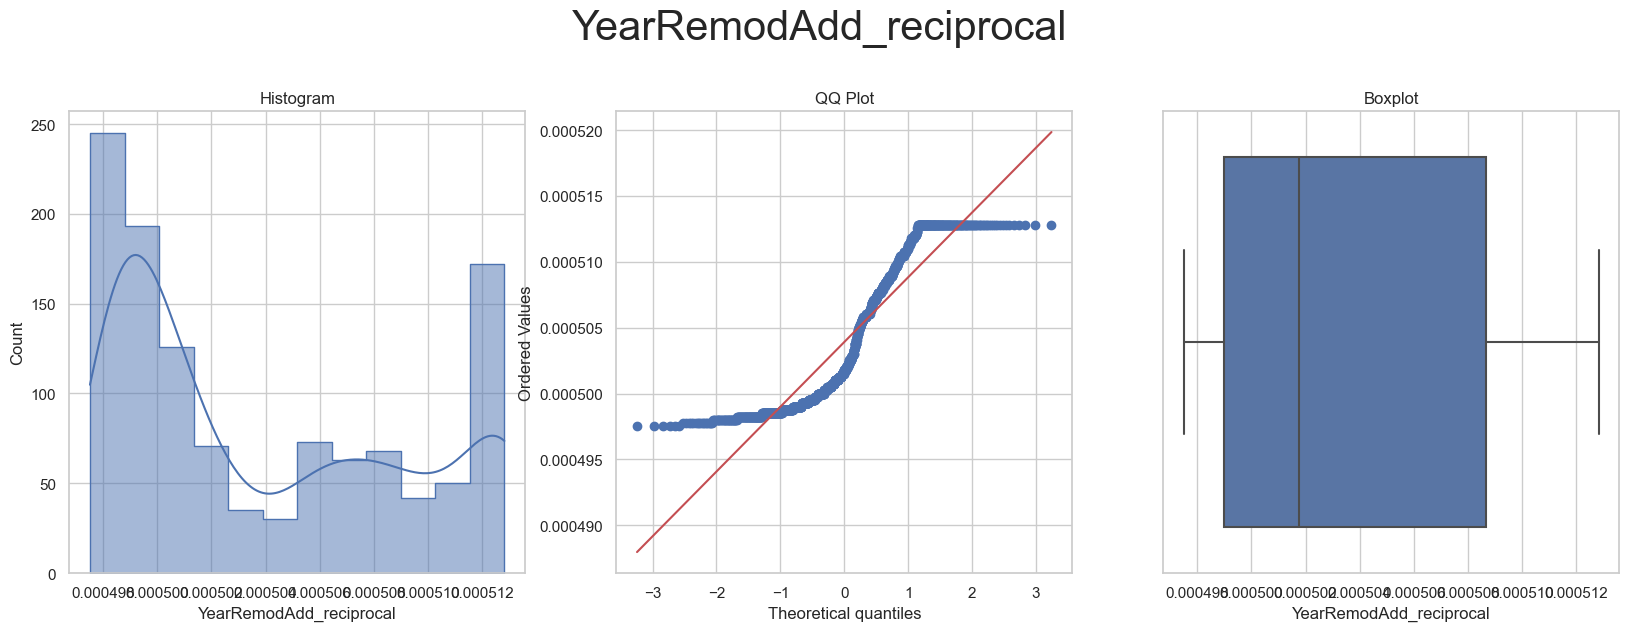

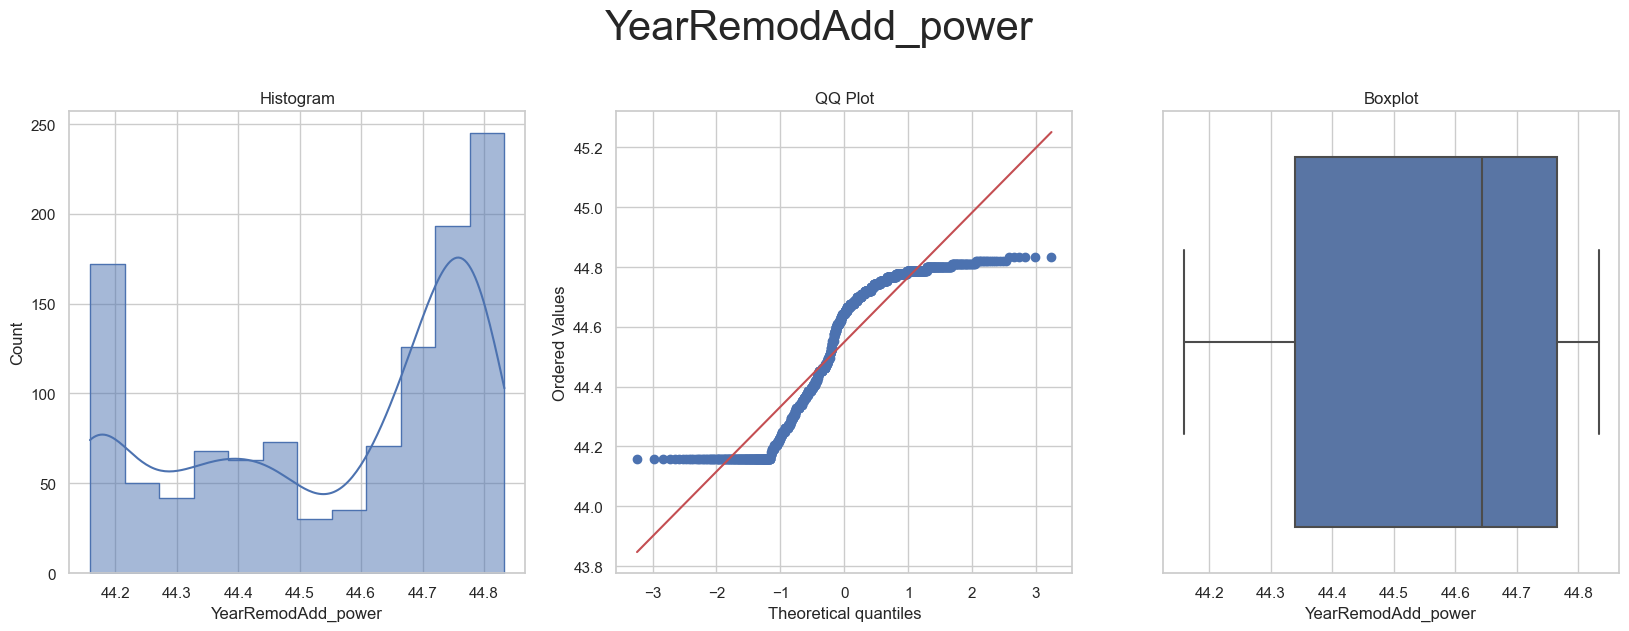

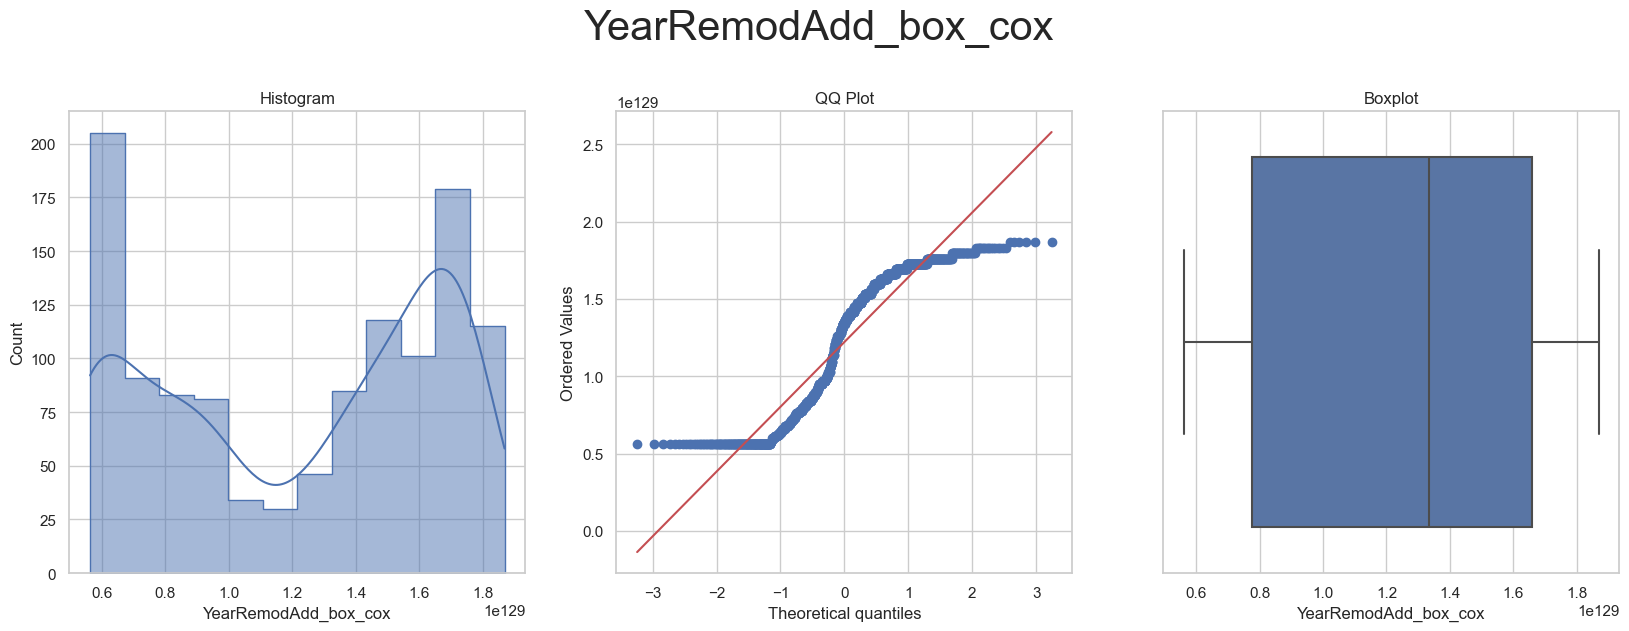

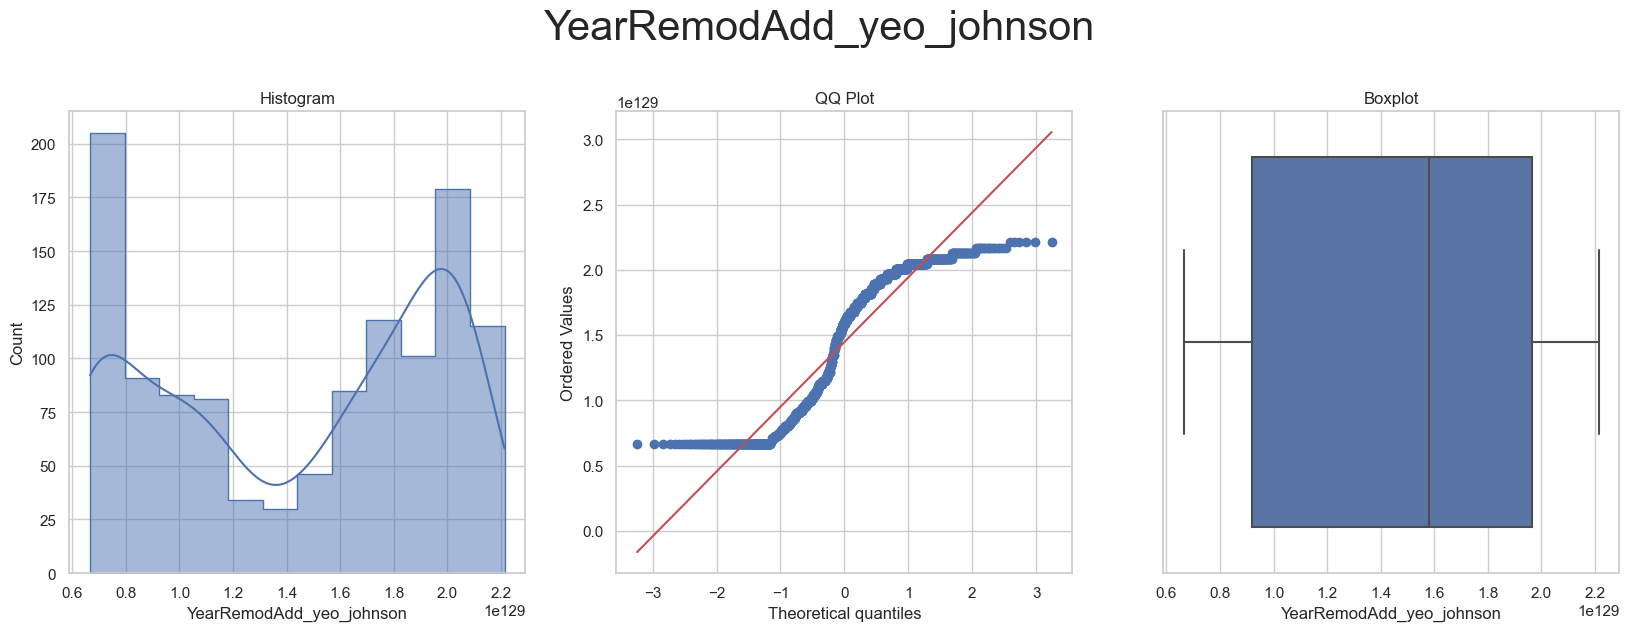



* Variable Analyzed: SalePrice
* Applied transformation: ['SalePrice_log_e', 'SalePrice_log_10', 'SalePrice_reciprocal', 'SalePrice_power', 'SalePrice_box_cox', 'SalePrice_yeo_johnson'] 



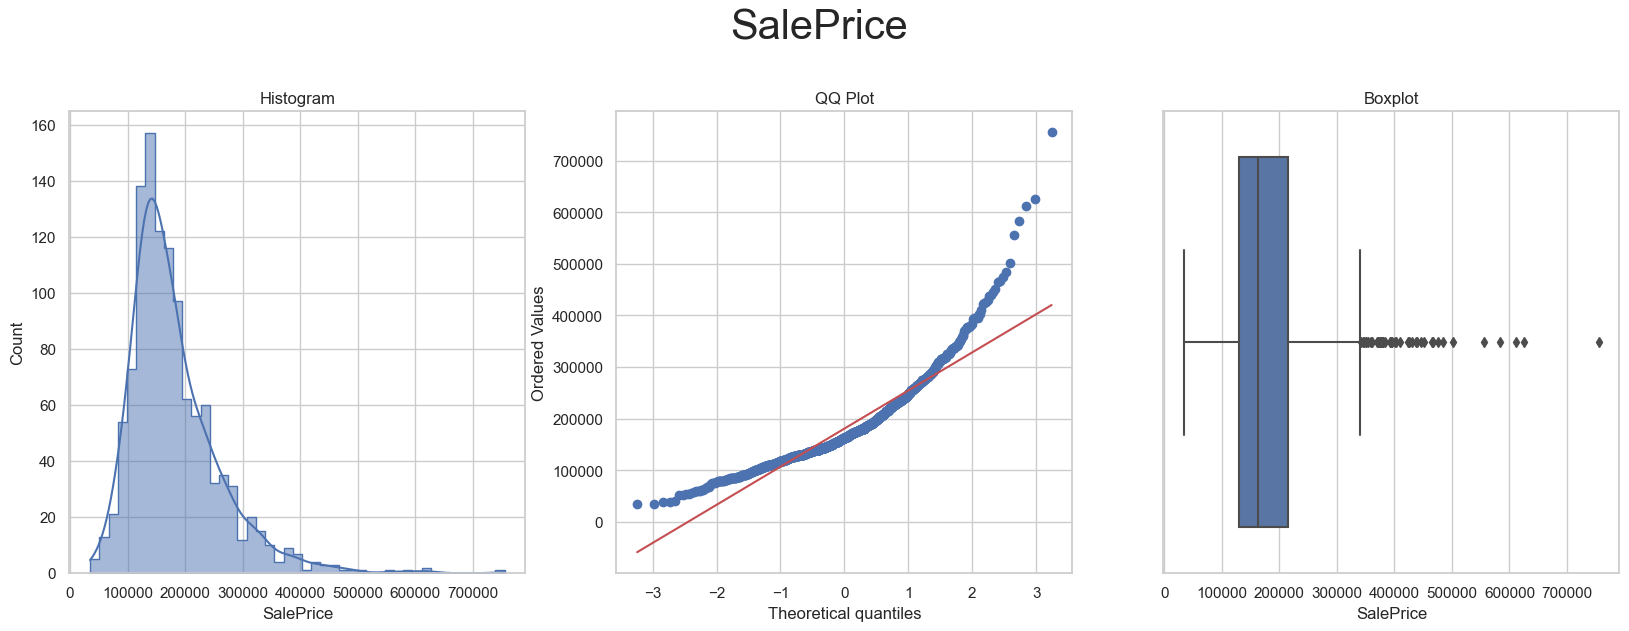

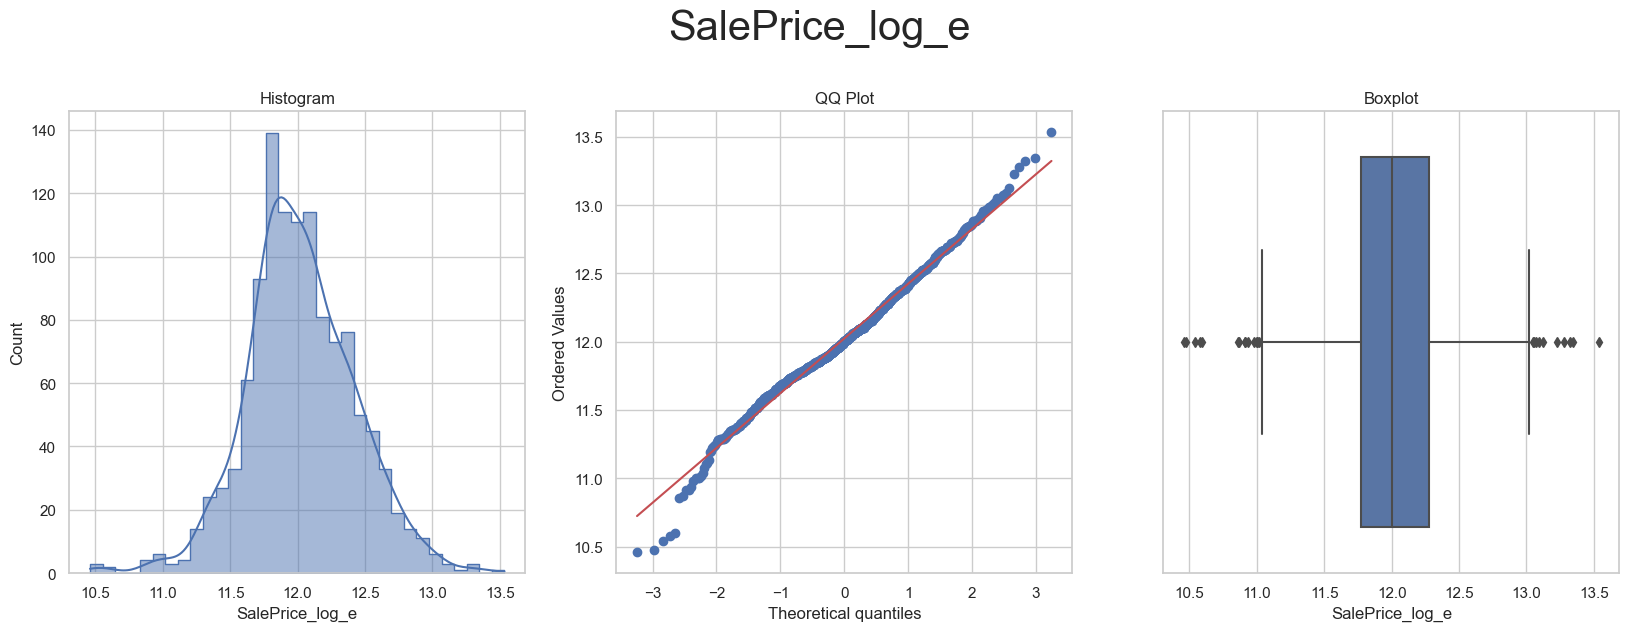

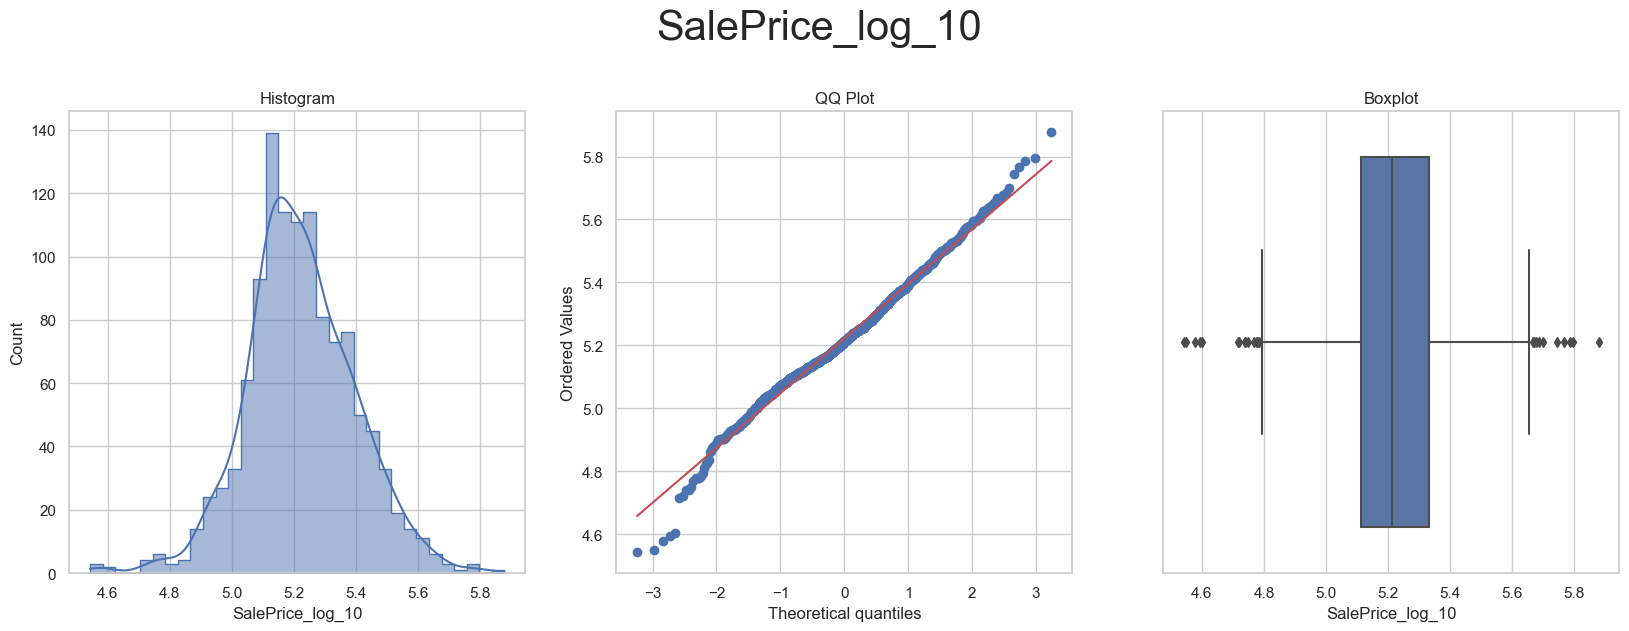

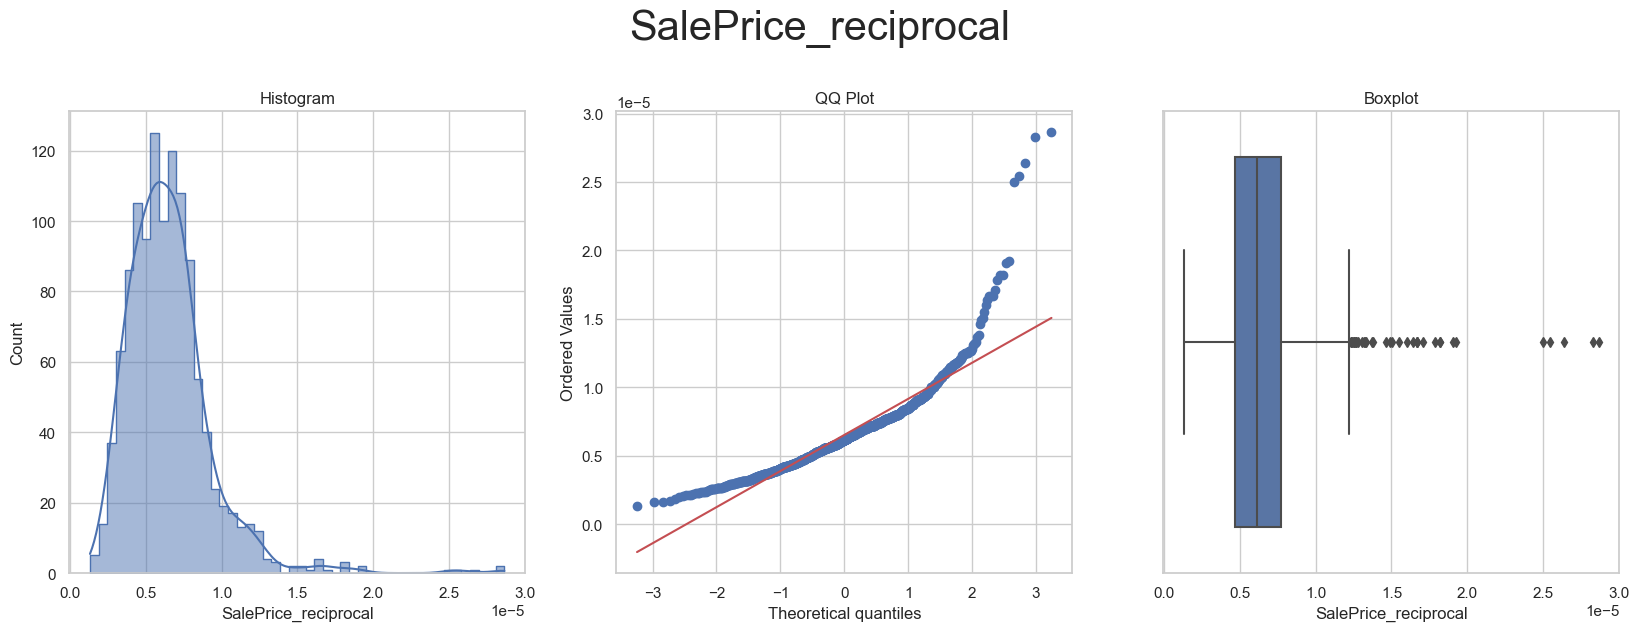

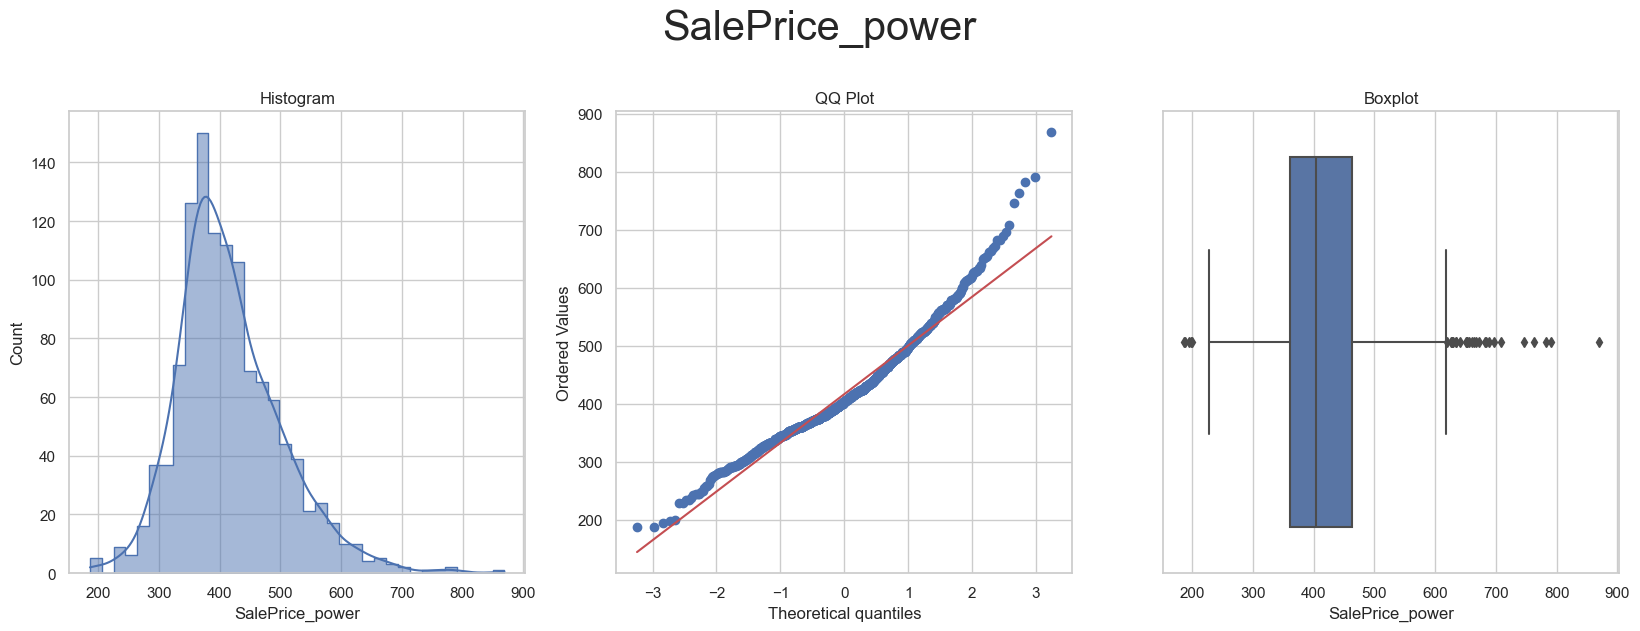

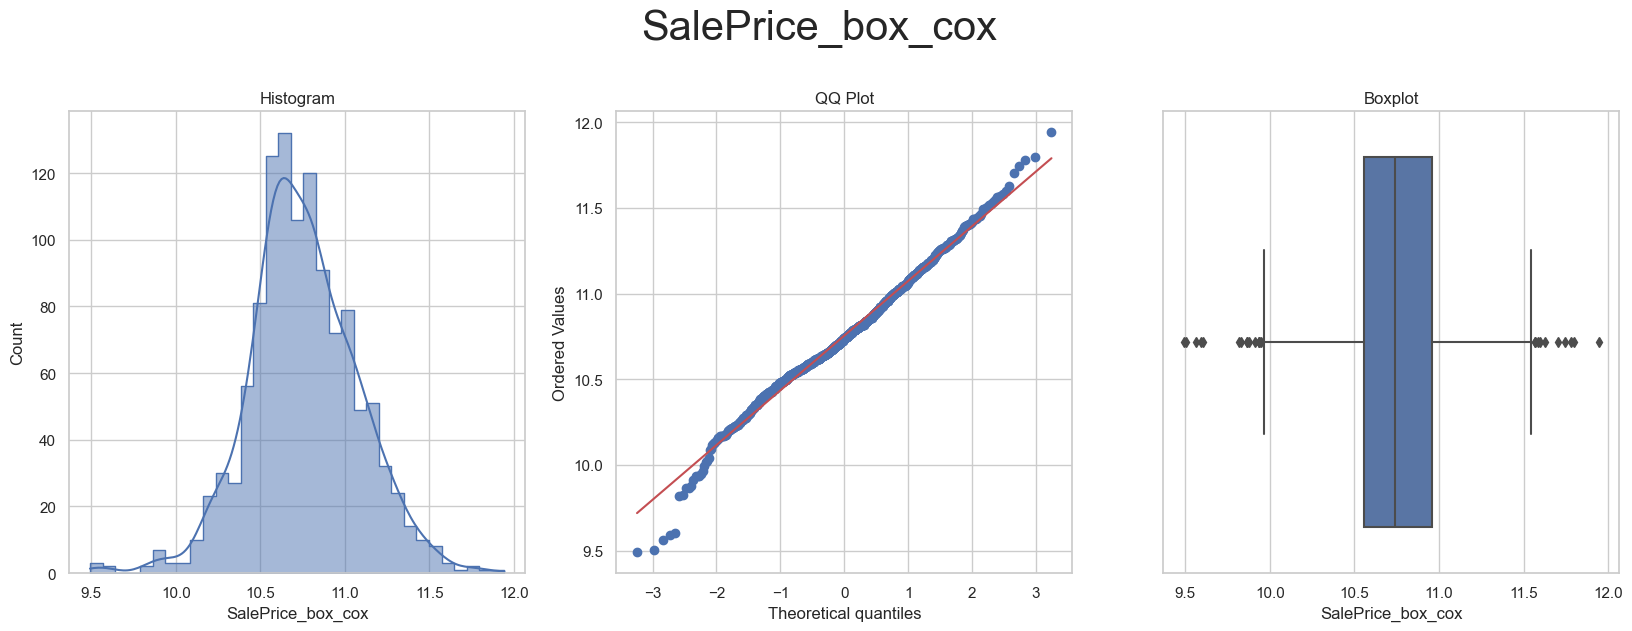

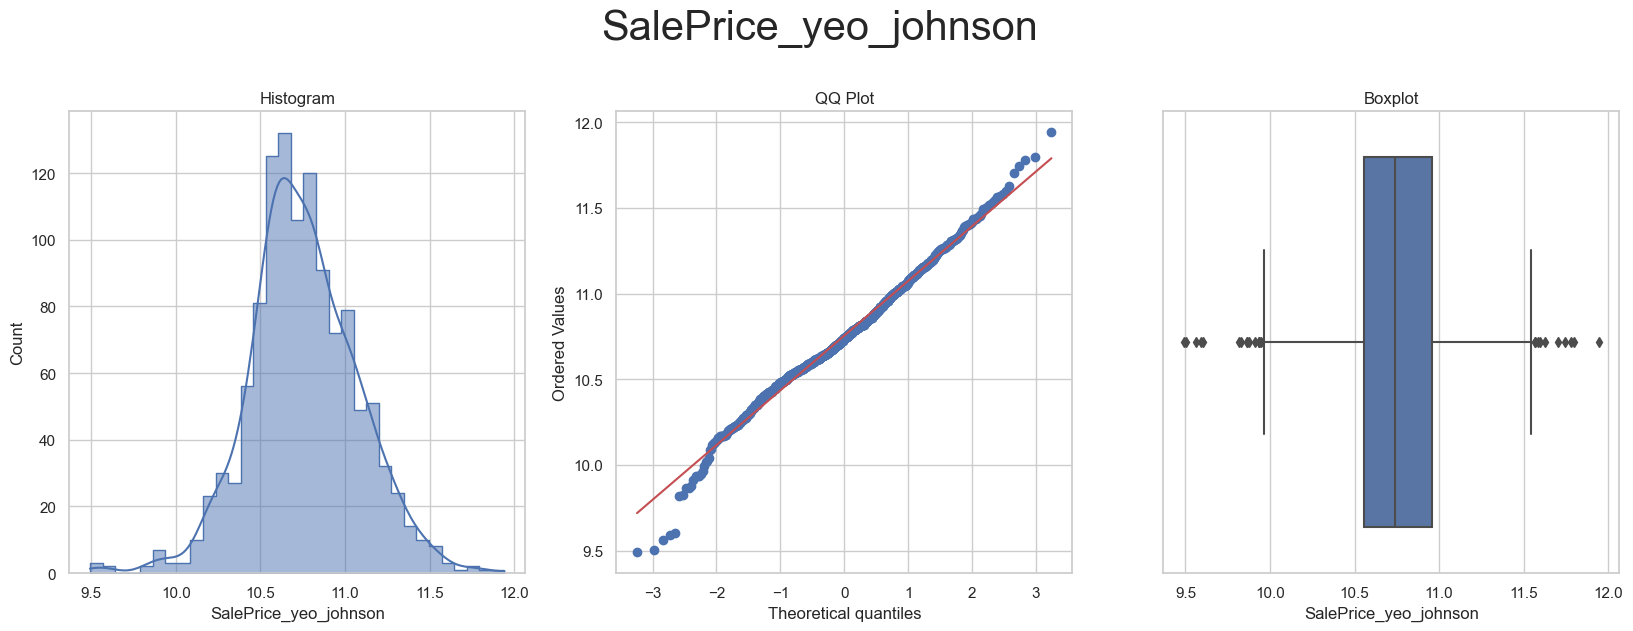

In [9]:
%matplotlib inline
df_feat_eng_numerical = FeatureEngineeringAnalysis(df=df_numerical,analysis_type='numerical')

## Results of Numerical Analysis
---

Of all the variables analysed, two distinct groups of transformations were created by the function, groups where:
* Log_e, Log_10, Reciprocal, Power, Box_Cox, Yeo_Johnson
* Power and Yeo_Johnson

### Transformation Group 1

Variables:
* 1stFlrSF
* GrLivArea
* LotArea
* LotFrontage
* YearBuilt
* YearRemodAdd

This group of numerical transformations was suggested by the CodeInstitue customer numerical analysis function.


### Results Breakdown

**1stFlrSF, GrLivArea, LotArea, LotFrontage**
* These variables showed improvements under all transformations except reciprocal.
* From the various plots, it can be seen that the histograms move closer to a normal distribution.
* There is improvment in the QQ plots, with most points moving closer to the line of best fit.
* The majority of outliers are eliminated, or their effect is reduced.

We can conclude that the Yeo Johnson, Box Cox, Log_10 and Log_e numerical transformations can be considered.

**YearBuilt, YearRemodAdd**
* These variables showed small improvements under the Yeo Johnson and Box Cox transformations.
* From the various plots, it can be seen that the histograms move closer to a normal distribution.
* There is marginal improvment in the QQ plots, with some points moving closer to the line of best fit.
* The majority of outliers are eliminated, or their effect is reduced.

We can conclude that the Yeo Johnson and Box Cox numerical transformations can be considered.

### Transformation Group 2

Variables:
* 2ndFlrSF
* BsmtFinSF1
* BsmtUnfSF
* GarageArea
* MasVnrArea
* OpenPorchSF
* TotalBsmtSF

### Results Breakdown

**2ndFlrSf, BsmtFinSF1**
* These variables had no noticeable improvement after transformation.
* Some outliers were removed.

We can conclude that these are good candidates for removal with smart feature selection.

**BsmtUnfSF, GarageArea, MasVnrArea, OpenPorchSF, TotalBsmtSF**
* These variables had small improvements after transformation, most noticeably with the power trasnformation.
* Some histograms had a wider distribution.
* QQ plots were slightly closer to the line of best fit.
* Some outliers were removed.

We can conclude that the Power numerical transformation can be considered.

We need to create a pipeline to handle the outliers.

Now categorical

In [10]:
# df_feat_eng_categorical = FeatureEngineeringAnalysis(df=df_categorical,analysis_type='ordinal_encoder')

## SmartCorrelatedSelection Variables
---

We can run this analysis on the entire dataset to select only the variables with the highest correlation to the target variable: SalePrice.

In [11]:
df_smart_corr = train_set.drop(['SalePrice'],axis=1)
df_smart_corr.head(3)

1stFlrSF  2ndFlrSF  BedroomAbvGr BsmtExposure  BsmtFinSF1 BsmtFinType1  \
0      1828         0             3           Av          48          Unf   
1       894         0             2           No           0          Unf   
2       964         0             2           No         713          ALQ   

   BsmtUnfSF  GarageArea GarageFinish  GarageYrBlt  ...  KitchenQual LotArea  \
0       1774         774          Unf       2007.0  ...           Gd   11694   
1        894         308          Unf       1962.0  ...           TA    6600   
2        163         432          Unf       1921.0  ...           TA   13360   

   LotFrontage  MasVnrArea  OpenPorchSF  OverallCond  OverallQual  \
0           90         452          108            4            8   
1           60           0            0            4            4   
2           80           0            0            6            4   

   TotalBsmtSF  YearBuilt  YearRemodAdd  
0         1822       2007          2007  
1          894       1962          1962  
2          876       1921          2006  

[3 rows x 21 columns]

In [12]:
from feature_engine.selection import SmartCorrelatedSelection
selection_method = 'cardinality'
corr_method = 'spearman'
smart_corr_spearman = SmartCorrelatedSelection(variables=None, method=corr_method, threshold=0.60, selection_method=selection_method)

smart_corr_spearman.fit_transform(df_smart_corr)
smart_corr_spearman.correlated_feature_sets_

[{'1stFlrSF', 'TotalBsmtSF'},
 {'2ndFlrSF', 'GrLivArea'},
 {'GarageYrBlt', 'YearBuilt', 'YearRemodAdd'}]

Now for pearson:

In [13]:
selection_method = 'cardinality'
corr_method = 'pearson'
smart_corr_pearson = SmartCorrelatedSelection(variables=None, method=corr_method, threshold=0.60, selection_method=selection_method)

smart_corr_pearson.fit_transform(df_smart_corr)
smart_corr_pearson.correlated_feature_sets_

[{'1stFlrSF', 'TotalBsmtSF'},
 {'2ndFlrSF', 'GrLivArea'},
 {'GarageYrBlt', 'YearBuilt'}]

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%  50%    75%    max
ppscore  462.0  0.058  0.103  0.0  0.0  0.0  0.075  0.572


* Analyse how the target variable for your ML models are correlated with other variables (features and target)
* Analyse multi-colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



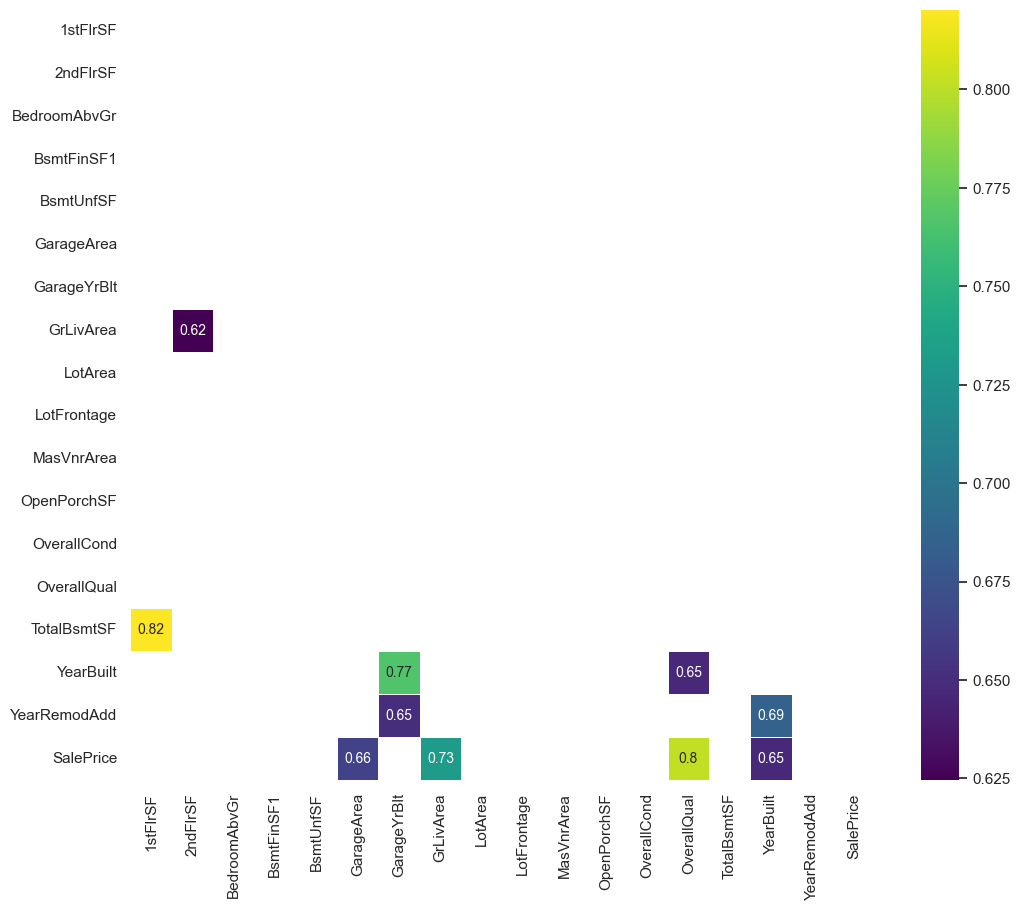



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



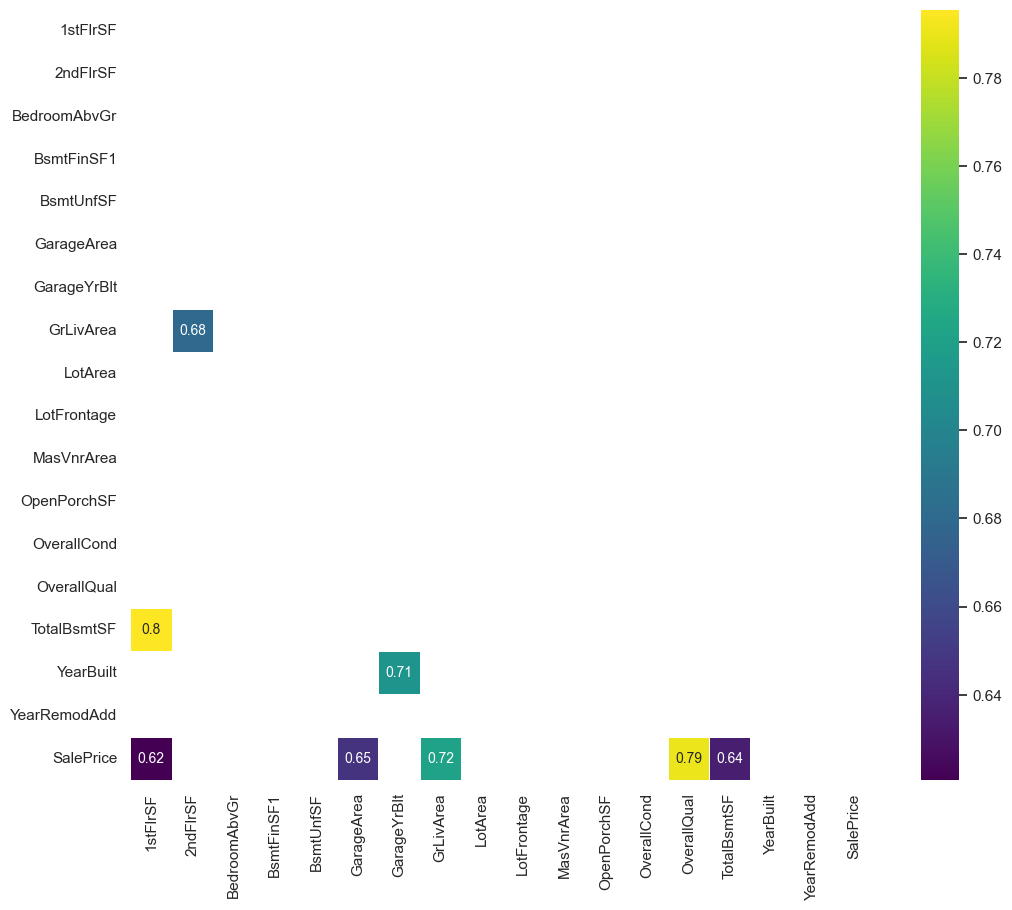



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



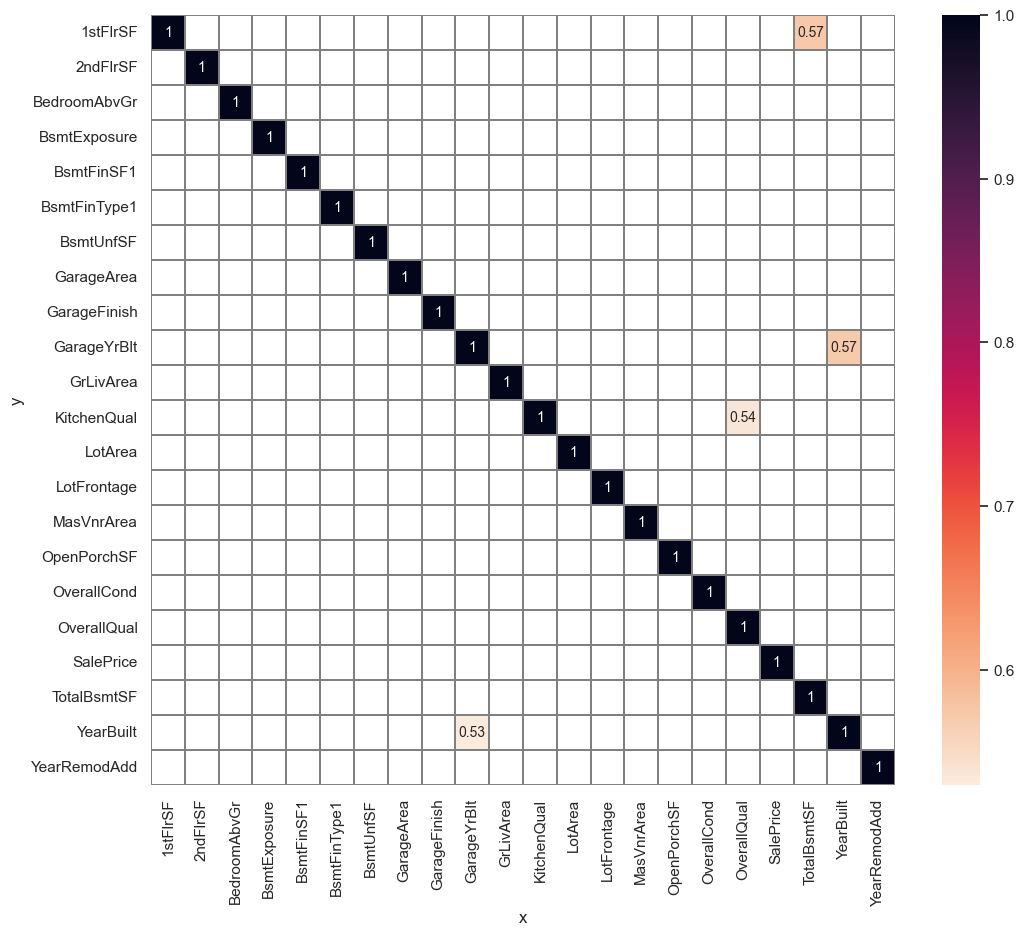

In [14]:
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(train_set)
%matplotlib inline
DisplayCorrAndPPS(df_corr_pearson = df_corr_pearson,
                  df_corr_spearman = df_corr_spearman, 
                  pps_matrix = pps_matrix,
                  CorrThreshold = 0.6, PPS_Threshold =0.5,
                  figsize=(12*1,10*1), font_annot=10)

## Conclusion
---

**Numerical Transformation**
* The ordinally encoded variables are BsmtExposure, BsmtFinType1, GarageFinish and KitchenQual.
* The variables for numerical transformation have been split into 3 groups:
    * 1stFlrSF, GrLivArea, LotArea, LotFrontage:
        * Log e, Log 10, Yeo Johnson and Box Cox are considered.
    * YearBuilt, YearRemodAdd:
        * Yeo Johnson and Box Cox are considered.
    * BsmtUnfSF, GarageArea, MasVnrArea, OpenPorchSF, TotalBsmtSF:
        * Power is considered.
    
**Chosen Transformers**
The following transformers will be employed:
* ('LogTransform', vt.LogTransformer(variables=['1stFlrSF', 'GrLivArea', 'LotArea', 'LotFrontage',]))
* ('YeoJohnsonTransform', vt.YeoJohnsonTransformer(variables=['YearBuilt', 'YearRemodAdd',]))
* ('PowerTransform', vt.LogTransformer(variables=['BsmtUnfSF', 'GarageArea', 'MasVnrArea', 'OpenPorchSF', 'TotalBsmtSF',]))


**Smart Correlation**
* From the correlation study in the VariableStudy notebook, we discovered that the following variables are the most correlated variables with SalePrice.:
    * 1stFlrSF
    * GarageArea
    * GarageFinish
    * GrLivArea
    * KitchenQual
    * OverallQual
    * TotalBsmtSF
    * YearBuilt
* From the SmartCorrelatedSelection, we can single out the overcorrelated variables in the dataset.
* Variables we can drop:
    * OverallCond
    * 2ndFlrSF
    * GarageYrBlt
    * TotalBsmtSF



## Save Pipeline
---

We can save the pipeline here are read it into the next jupyter notebook.

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from feature_engine.transformation import PowerTransformer
from feature_engine.transformation import YeoJohnsonTransformer
from feature_engine.transformation import LogTransformer


feature_engineering_pipeline = Pipeline([
      ('OrdinalEncoder',OrdinalEncoder(variables=['GarageFinish', 'BsmtFinType1', 'BsmtExposure', 'KitchenQual'])),
      ('LogTransform', LogTransformer(variables=['1stFlrSF', 'GrLivArea', 'LotArea', 'LotFrontage',])),
      ('YeoJohnsonTransform', YeoJohnsonTransformer(variables=['YearBuilt', 'YearRemodAdd',])),
      ('PowerTransform', PowerTransformer(variables=['BsmtUnfSF', 'GarageArea', 'MasVnrArea', 'OpenPorchSF', 'TotalBsmtSF',])),
      # ('StandardScaler', StandardScaler())
])

feature_engineering_pipeline

Pipeline(steps=[('OrdinalEncoder',
                 OrdinalEncoder(variables=['GarageFinish', 'BsmtFinType1',
                                           'BsmtExposure', 'KitchenQual'])),
                ('LogTransform',
                 LogTransformer(variables=['1stFlrSF', 'GrLivArea', 'LotArea',
                                           'LotFrontage'])),
                ('YeoJohnsonTransform',
                 YeoJohnsonTransformer(variables=['YearBuilt',
                                                  'YearRemodAdd'])),
                ('PowerTransform',
                 PowerTransformer(variables=['BsmtUnfSF', 'GarageArea',
                                             'MasVnrArea', 'OpenPorchSF',
                                             'TotalBsmtSF']))])

In [16]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1168 entries, 0 to 1167
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   1stFlrSF      1168 non-null   int64  
 1   2ndFlrSF      1168 non-null   int64  
 2   BedroomAbvGr  1168 non-null   int64  
 3   BsmtExposure  1168 non-null   object 
 4   BsmtFinSF1    1168 non-null   int64  
 5   BsmtFinType1  1168 non-null   object 
 6   BsmtUnfSF     1168 non-null   int64  
 7   GarageArea    1168 non-null   int64  
 8   GarageFinish  1168 non-null   object 
 9   GarageYrBlt   1168 non-null   float64
 10  GrLivArea     1168 non-null   int64  
 11  KitchenQual   1168 non-null   object 
 12  LotArea       1168 non-null   int64  
 13  LotFrontage   1168 non-null   int64  
 14  MasVnrArea    1168 non-null   int64  
 15  OpenPorchSF   1168 non-null   int64  
 16  OverallCond   1168 non-null   int64  
 17  OverallQual   1168 non-null   int64  
 18  TotalBsmtSF   1168 non-null 

In [17]:
categorical_variables = train_set.select_dtypes(include=['object']).columns
train_set[categorical_variables]=train_set[categorical_variables].astype('category')
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1168 entries, 0 to 1167
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   1stFlrSF      1168 non-null   int64   
 1   2ndFlrSF      1168 non-null   int64   
 2   BedroomAbvGr  1168 non-null   int64   
 3   BsmtExposure  1168 non-null   category
 4   BsmtFinSF1    1168 non-null   int64   
 5   BsmtFinType1  1168 non-null   category
 6   BsmtUnfSF     1168 non-null   int64   
 7   GarageArea    1168 non-null   int64   
 8   GarageFinish  1168 non-null   category
 9   GarageYrBlt   1168 non-null   float64 
 10  GrLivArea     1168 non-null   int64   
 11  KitchenQual   1168 non-null   category
 12  LotArea       1168 non-null   int64   
 13  LotFrontage   1168 non-null   int64   
 14  MasVnrArea    1168 non-null   int64   
 15  OpenPorchSF   1168 non-null   int64   
 16  OverallCond   1168 non-null   int64   
 17  OverallQual   1168 non-null   int64   
 18  TotalBsm

In [18]:
train_fe = feature_engineering_pipeline.fit_transform(train_set.drop(['SalePrice'],axis=1),train_set['SalePrice'])

In [19]:
print(train_fe.shape)

(1168, 21)


Try to create the directory for models:

In [20]:
import os
try:
    os.makedirs(name='outputs/pipelines') # create outputs/datasets/collection folder
except Exception as e:
    print(e)

[Errno 17] File exists: 'outputs/pipelines'


Save pipeline.

In [21]:
import joblib
joblib.dump(value=feature_engineering_pipeline ,filename=f"outputs/pipelines/feature_engineering_pipeline.pkl")

['outputs/pipelines/feature_engineering_pipeline.pkl']